In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                              | 1/2934 [00:00<38:00,  1.29it/s]

  0%|                                                                                              | 2/2934 [00:00<21:59,  2.22it/s]

  0%|                                                                                              | 3/2934 [00:01<16:51,  2.90it/s]

  0%|▏                                                                                             | 4/2934 [00:01<14:26,  3.38it/s]

  0%|▏                                                                                             | 5/2934 [00:01<13:06,  3.72it/s]

  0%|▏                                                                                             | 6/2934 [00:01<12:18,  3.96it/s]

  0%|▏                                                                                             | 7/2934 [00:02<11:48,  4.13it/s]

  0%|▎                                                                                             | 8/2934 [00:02<11:27,  4.25it/s]

  0%|▎                                                                                             | 9/2934 [00:02<11:13,  4.34it/s]

  0%|▎                                                                                            | 10/2934 [00:02<11:04,  4.40it/s]

  0%|▎                                                                                            | 11/2934 [00:02<10:58,  4.44it/s]

  0%|▍                                                                                            | 12/2934 [00:03<10:54,  4.47it/s]

  0%|▍                                                                                            | 13/2934 [00:03<10:50,  4.49it/s]

  0%|▍                                                                                            | 14/2934 [00:03<10:48,  4.50it/s]

  1%|▍                                                                                            | 15/2934 [00:03<10:46,  4.51it/s]

  1%|▌                                                                                            | 16/2934 [00:04<10:45,  4.52it/s]

  1%|▌                                                                                            | 17/2934 [00:04<10:44,  4.52it/s]

  1%|▌                                                                                            | 18/2934 [00:04<10:43,  4.53it/s]

  1%|▌                                                                                            | 19/2934 [00:04<10:43,  4.53it/s]

  1%|▋                                                                                            | 20/2934 [00:04<10:42,  4.53it/s]

  1%|▋                                                                                            | 21/2934 [00:05<10:42,  4.53it/s]

  1%|▋                                                                                            | 22/2934 [00:05<10:42,  4.53it/s]

  1%|▋                                                                                            | 23/2934 [00:05<10:41,  4.54it/s]

  1%|▊                                                                                            | 24/2934 [00:05<10:41,  4.54it/s]

  1%|▊                                                                                            | 25/2934 [00:06<10:41,  4.54it/s]

  1%|▊                                                                                            | 26/2934 [00:06<10:41,  4.54it/s]

  1%|▊                                                                                            | 27/2934 [00:06<10:40,  4.54it/s]

  1%|▉                                                                                            | 28/2934 [00:06<10:40,  4.54it/s]

  1%|▉                                                                                            | 29/2934 [00:06<10:40,  4.54it/s]

  1%|▉                                                                                            | 30/2934 [00:07<10:39,  4.54it/s]

  1%|▉                                                                                            | 31/2934 [00:07<10:39,  4.54it/s]

  1%|█                                                                                            | 32/2934 [00:07<10:43,  4.51it/s]

  1%|█                                                                                            | 33/2934 [00:07<10:42,  4.52it/s]

  1%|█                                                                                            | 34/2934 [00:08<10:40,  4.53it/s]

  1%|█                                                                                            | 35/2934 [00:08<10:40,  4.53it/s]

  1%|█▏                                                                                           | 36/2934 [00:08<10:40,  4.53it/s]

  1%|█▏                                                                                           | 37/2934 [00:08<10:40,  4.53it/s]

  1%|█▏                                                                                           | 38/2934 [00:08<10:40,  4.52it/s]

  1%|█▏                                                                                           | 39/2934 [00:09<10:39,  4.53it/s]

  1%|█▎                                                                                           | 40/2934 [00:09<10:39,  4.53it/s]

  1%|█▎                                                                                           | 41/2934 [00:09<10:39,  4.53it/s]

  1%|█▎                                                                                           | 42/2934 [00:09<10:38,  4.53it/s]

  1%|█▎                                                                                           | 43/2934 [00:10<10:38,  4.53it/s]

  1%|█▍                                                                                           | 44/2934 [00:10<10:38,  4.53it/s]

  2%|█▍                                                                                           | 45/2934 [00:10<10:37,  4.53it/s]

  2%|█▍                                                                                           | 46/2934 [00:10<10:37,  4.53it/s]

  2%|█▍                                                                                           | 47/2934 [00:10<10:37,  4.53it/s]

  2%|█▌                                                                                           | 48/2934 [00:11<10:37,  4.53it/s]

  2%|█▌                                                                                           | 49/2934 [00:11<10:37,  4.53it/s]

  2%|█▌                                                                                           | 50/2934 [00:11<10:36,  4.53it/s]

  2%|█▌                                                                                           | 51/2934 [00:11<10:36,  4.53it/s]

  2%|█▋                                                                                           | 52/2934 [00:12<10:36,  4.53it/s]

  2%|█▋                                                                                           | 53/2934 [00:12<10:36,  4.53it/s]

  2%|█▋                                                                                           | 54/2934 [00:12<10:36,  4.53it/s]

  2%|█▋                                                                                           | 55/2934 [00:12<10:35,  4.53it/s]

  2%|█▊                                                                                           | 56/2934 [00:12<10:35,  4.53it/s]

  2%|█▊                                                                                           | 57/2934 [00:13<10:35,  4.53it/s]

  2%|█▊                                                                                           | 58/2934 [00:13<10:35,  4.53it/s]

  2%|█▊                                                                                           | 59/2934 [00:13<10:35,  4.53it/s]

  2%|█▉                                                                                           | 60/2934 [00:13<10:34,  4.53it/s]

  2%|█▉                                                                                           | 61/2934 [00:14<10:34,  4.53it/s]

  2%|█▉                                                                                           | 62/2934 [00:14<10:34,  4.53it/s]

  2%|█▉                                                                                           | 63/2934 [00:14<10:34,  4.53it/s]

  2%|██                                                                                           | 64/2934 [00:14<10:34,  4.53it/s]

  2%|██                                                                                           | 65/2934 [00:14<10:33,  4.53it/s]

  2%|██                                                                                           | 66/2934 [00:15<10:33,  4.53it/s]

  2%|██                                                                                           | 67/2934 [00:15<10:33,  4.53it/s]

  2%|██▏                                                                                          | 68/2934 [00:15<10:33,  4.53it/s]

  2%|██▏                                                                                          | 69/2934 [00:15<10:32,  4.53it/s]

  2%|██▏                                                                                          | 70/2934 [00:16<10:32,  4.53it/s]

  2%|██▎                                                                                          | 71/2934 [00:16<10:32,  4.53it/s]

  2%|██▎                                                                                          | 72/2934 [00:16<10:32,  4.53it/s]

  2%|██▎                                                                                          | 73/2934 [00:16<10:32,  4.53it/s]

  3%|██▎                                                                                          | 74/2934 [00:16<10:31,  4.53it/s]

  3%|██▍                                                                                          | 75/2934 [00:17<10:31,  4.53it/s]

  3%|██▍                                                                                          | 76/2934 [00:17<10:31,  4.53it/s]

  3%|██▍                                                                                          | 77/2934 [00:17<10:30,  4.53it/s]

  3%|██▍                                                                                          | 78/2934 [00:17<10:30,  4.53it/s]

  3%|██▌                                                                                          | 79/2934 [00:17<10:30,  4.53it/s]

  3%|██▌                                                                                          | 80/2934 [00:18<10:30,  4.53it/s]

  3%|██▌                                                                                          | 81/2934 [00:18<10:30,  4.53it/s]

  3%|██▌                                                                                          | 82/2934 [00:18<10:29,  4.53it/s]

  3%|██▋                                                                                          | 83/2934 [00:18<10:29,  4.53it/s]

  3%|██▋                                                                                          | 84/2934 [00:19<10:29,  4.53it/s]

  3%|██▋                                                                                          | 85/2934 [00:19<10:29,  4.53it/s]

  3%|██▋                                                                                          | 86/2934 [00:19<10:28,  4.53it/s]

  3%|██▊                                                                                          | 87/2934 [00:19<10:28,  4.53it/s]

  3%|██▊                                                                                          | 88/2934 [00:19<10:28,  4.53it/s]

  3%|██▊                                                                                          | 89/2934 [00:20<10:28,  4.53it/s]

  3%|██▊                                                                                          | 90/2934 [00:20<10:28,  4.53it/s]

  3%|██▉                                                                                          | 91/2934 [00:20<10:27,  4.53it/s]

  3%|██▉                                                                                          | 92/2934 [00:20<10:27,  4.53it/s]

  3%|██▉                                                                                          | 93/2934 [00:21<10:27,  4.53it/s]

  3%|██▉                                                                                          | 94/2934 [00:21<10:27,  4.53it/s]

  3%|███                                                                                          | 95/2934 [00:21<10:26,  4.53it/s]

  3%|███                                                                                          | 96/2934 [00:21<10:26,  4.53it/s]

  3%|███                                                                                          | 97/2934 [00:21<10:26,  4.53it/s]

  3%|███                                                                                          | 98/2934 [00:22<10:26,  4.53it/s]

  3%|███▏                                                                                         | 99/2934 [00:22<10:25,  4.53it/s]

  3%|███▏                                                                                        | 100/2934 [00:22<10:25,  4.53it/s]

  3%|███▏                                                                                        | 101/2934 [00:22<10:25,  4.53it/s]

  3%|███▏                                                                                        | 102/2934 [00:23<10:24,  4.53it/s]

  4%|███▏                                                                                        | 103/2934 [00:23<10:24,  4.53it/s]

  4%|███▎                                                                                        | 104/2934 [00:23<10:24,  4.53it/s]

  4%|███▎                                                                                        | 105/2934 [00:23<10:24,  4.53it/s]

  4%|███▎                                                                                        | 106/2934 [00:23<10:24,  4.53it/s]

  4%|███▎                                                                                        | 107/2934 [00:24<10:24,  4.53it/s]

  4%|███▍                                                                                        | 108/2934 [00:24<10:23,  4.53it/s]

  4%|███▍                                                                                        | 109/2934 [00:24<10:23,  4.53it/s]

  4%|███▍                                                                                        | 110/2934 [00:24<10:23,  4.53it/s]

  4%|███▍                                                                                        | 111/2934 [00:25<10:23,  4.53it/s]

  4%|███▌                                                                                        | 112/2934 [00:25<10:23,  4.53it/s]

  4%|███▌                                                                                        | 113/2934 [00:25<10:22,  4.53it/s]

  4%|███▌                                                                                        | 114/2934 [00:25<10:22,  4.53it/s]

  4%|███▌                                                                                        | 115/2934 [00:25<10:22,  4.53it/s]

  4%|███▋                                                                                        | 116/2934 [00:26<10:22,  4.53it/s]

  4%|███▋                                                                                        | 117/2934 [00:26<10:21,  4.53it/s]

  4%|███▋                                                                                        | 118/2934 [00:26<10:21,  4.53it/s]

  4%|███▋                                                                                        | 119/2934 [00:26<10:21,  4.53it/s]

  4%|███▊                                                                                        | 120/2934 [00:27<10:21,  4.53it/s]

  4%|███▊                                                                                        | 121/2934 [00:27<10:21,  4.53it/s]

  4%|███▊                                                                                        | 122/2934 [00:27<10:20,  4.53it/s]

  4%|███▊                                                                                        | 123/2934 [00:27<10:20,  4.53it/s]

  4%|███▉                                                                                        | 124/2934 [00:27<10:20,  4.53it/s]

  4%|███▉                                                                                        | 125/2934 [00:28<10:20,  4.53it/s]

  4%|███▉                                                                                        | 126/2934 [00:28<10:19,  4.53it/s]

  4%|███▉                                                                                        | 127/2934 [00:28<10:19,  4.53it/s]

  4%|████                                                                                        | 128/2934 [00:28<10:19,  4.53it/s]

  4%|████                                                                                        | 129/2934 [00:29<10:19,  4.53it/s]

  4%|████                                                                                        | 130/2934 [00:29<10:19,  4.53it/s]

  4%|████                                                                                        | 131/2934 [00:29<10:18,  4.53it/s]

  4%|████▏                                                                                       | 132/2934 [00:29<10:18,  4.53it/s]

  5%|████▏                                                                                       | 133/2934 [00:29<10:18,  4.53it/s]

  5%|████▏                                                                                       | 134/2934 [00:30<10:18,  4.53it/s]

  5%|████▏                                                                                       | 135/2934 [00:30<10:18,  4.53it/s]

  5%|████▎                                                                                       | 136/2934 [00:30<10:17,  4.53it/s]

  5%|████▎                                                                                       | 137/2934 [00:30<10:17,  4.53it/s]

  5%|████▎                                                                                       | 138/2934 [00:31<10:17,  4.53it/s]

  5%|████▎                                                                                       | 139/2934 [00:31<10:16,  4.53it/s]

  5%|████▍                                                                                       | 140/2934 [00:31<10:16,  4.53it/s]

  5%|████▍                                                                                       | 141/2934 [00:31<10:16,  4.53it/s]

  5%|████▍                                                                                       | 142/2934 [00:31<10:16,  4.53it/s]

  5%|████▍                                                                                       | 143/2934 [00:32<10:16,  4.53it/s]

  5%|████▌                                                                                       | 144/2934 [00:32<10:15,  4.53it/s]

  5%|████▌                                                                                       | 145/2934 [00:32<10:15,  4.53it/s]

  5%|████▌                                                                                       | 146/2934 [00:32<10:15,  4.53it/s]

  5%|████▌                                                                                       | 147/2934 [00:33<10:15,  4.53it/s]

  5%|████▋                                                                                       | 148/2934 [00:33<10:14,  4.53it/s]

  5%|████▋                                                                                       | 149/2934 [00:33<10:14,  4.53it/s]

  5%|████▋                                                                                       | 150/2934 [00:33<10:14,  4.53it/s]

  5%|████▋                                                                                       | 151/2934 [00:33<10:14,  4.53it/s]

  5%|████▊                                                                                       | 152/2934 [00:34<10:14,  4.53it/s]

  5%|████▊                                                                                       | 153/2934 [00:34<10:13,  4.53it/s]

  5%|████▊                                                                                       | 154/2934 [00:34<10:13,  4.53it/s]

  5%|████▊                                                                                       | 155/2934 [00:34<10:13,  4.53it/s]

  5%|████▉                                                                                       | 156/2934 [00:34<10:13,  4.53it/s]

  5%|████▉                                                                                       | 157/2934 [00:35<10:13,  4.53it/s]

  5%|████▉                                                                                       | 158/2934 [00:35<10:12,  4.53it/s]

  5%|████▉                                                                                       | 159/2934 [00:35<10:12,  4.53it/s]

  5%|█████                                                                                       | 160/2934 [00:35<10:12,  4.53it/s]

  5%|█████                                                                                       | 161/2934 [00:36<10:12,  4.53it/s]

  6%|█████                                                                                       | 162/2934 [00:36<10:12,  4.53it/s]

  6%|█████                                                                                       | 163/2934 [00:36<10:11,  4.53it/s]

  6%|█████▏                                                                                      | 164/2934 [00:36<10:11,  4.53it/s]

  6%|█████▏                                                                                      | 165/2934 [00:36<10:11,  4.53it/s]

  6%|█████▏                                                                                      | 166/2934 [00:37<10:11,  4.53it/s]

  6%|█████▏                                                                                      | 167/2934 [00:37<10:10,  4.53it/s]

  6%|█████▎                                                                                      | 168/2934 [00:37<10:10,  4.53it/s]

  6%|█████▎                                                                                      | 169/2934 [00:37<10:10,  4.53it/s]

  6%|█████▎                                                                                      | 170/2934 [00:38<10:09,  4.53it/s]

  6%|█████▎                                                                                      | 171/2934 [00:38<10:09,  4.54it/s]

  6%|█████▍                                                                                      | 172/2934 [00:38<10:08,  4.54it/s]

  6%|█████▍                                                                                      | 173/2934 [00:38<10:08,  4.54it/s]

  6%|█████▍                                                                                      | 174/2934 [00:38<10:08,  4.54it/s]

  6%|█████▍                                                                                      | 175/2934 [00:39<10:08,  4.54it/s]

  6%|█████▌                                                                                      | 176/2934 [00:39<10:07,  4.54it/s]

  6%|█████▌                                                                                      | 177/2934 [00:39<10:07,  4.54it/s]

  6%|█████▌                                                                                      | 178/2934 [00:39<10:07,  4.54it/s]

  6%|█████▌                                                                                      | 179/2934 [00:40<10:06,  4.54it/s]

  6%|█████▋                                                                                      | 180/2934 [00:40<10:06,  4.54it/s]

  6%|█████▋                                                                                      | 181/2934 [00:40<10:06,  4.54it/s]

  6%|█████▋                                                                                      | 182/2934 [00:40<10:06,  4.54it/s]

  6%|█████▋                                                                                      | 183/2934 [00:40<10:05,  4.54it/s]

  6%|█████▊                                                                                      | 184/2934 [00:41<10:05,  4.54it/s]

  6%|█████▊                                                                                      | 185/2934 [00:41<10:05,  4.54it/s]

  6%|█████▊                                                                                      | 186/2934 [00:41<10:05,  4.54it/s]

  6%|█████▊                                                                                      | 187/2934 [00:41<10:04,  4.54it/s]

  6%|█████▉                                                                                      | 188/2934 [00:42<10:04,  4.54it/s]

  6%|█████▉                                                                                      | 189/2934 [00:42<10:04,  4.54it/s]

  6%|█████▉                                                                                      | 190/2934 [00:42<10:04,  4.54it/s]

  7%|█████▉                                                                                      | 191/2934 [00:42<10:04,  4.54it/s]

  7%|██████                                                                                      | 192/2934 [00:42<10:03,  4.54it/s]

  7%|██████                                                                                      | 193/2934 [00:43<10:03,  4.54it/s]

  7%|██████                                                                                      | 194/2934 [00:43<10:03,  4.54it/s]

  7%|██████                                                                                      | 195/2934 [00:43<10:03,  4.54it/s]

  7%|██████▏                                                                                     | 196/2934 [00:43<10:03,  4.54it/s]

  7%|██████▏                                                                                     | 197/2934 [00:44<10:02,  4.54it/s]

  7%|██████▏                                                                                     | 198/2934 [00:44<10:02,  4.54it/s]

  7%|██████▏                                                                                     | 199/2934 [00:44<10:02,  4.54it/s]

  7%|██████▎                                                                                     | 200/2934 [00:44<10:02,  4.54it/s]

  7%|██████▎                                                                                     | 201/2934 [00:44<10:01,  4.54it/s]

  7%|██████▎                                                                                     | 202/2934 [00:45<10:01,  4.54it/s]

  7%|██████▎                                                                                     | 203/2934 [00:45<10:01,  4.54it/s]

  7%|██████▍                                                                                     | 204/2934 [00:45<10:01,  4.54it/s]

  7%|██████▍                                                                                     | 205/2934 [00:45<10:01,  4.54it/s]

  7%|██████▍                                                                                     | 206/2934 [00:46<10:01,  4.54it/s]

  7%|██████▍                                                                                     | 207/2934 [00:46<10:00,  4.54it/s]

  7%|██████▌                                                                                     | 208/2934 [00:46<10:00,  4.54it/s]

  7%|██████▌                                                                                     | 209/2934 [00:46<10:00,  4.54it/s]

  7%|██████▌                                                                                     | 210/2934 [00:46<09:59,  4.54it/s]

  7%|██████▌                                                                                     | 211/2934 [00:47<09:59,  4.54it/s]

  7%|██████▋                                                                                     | 212/2934 [00:47<09:59,  4.54it/s]

  7%|██████▋                                                                                     | 213/2934 [00:47<09:59,  4.54it/s]

  7%|██████▋                                                                                     | 214/2934 [00:47<09:58,  4.54it/s]

  7%|██████▋                                                                                     | 215/2934 [00:47<09:58,  4.54it/s]

  7%|██████▊                                                                                     | 216/2934 [00:48<09:58,  4.54it/s]

  7%|██████▊                                                                                     | 217/2934 [00:48<09:58,  4.54it/s]

  7%|██████▊                                                                                     | 218/2934 [00:48<09:58,  4.54it/s]

  7%|██████▊                                                                                     | 219/2934 [00:48<09:57,  4.54it/s]

  7%|██████▉                                                                                     | 220/2934 [00:49<09:57,  4.54it/s]

  8%|██████▉                                                                                     | 221/2934 [00:49<09:57,  4.54it/s]

  8%|██████▉                                                                                     | 222/2934 [00:49<09:57,  4.54it/s]

  8%|██████▉                                                                                     | 223/2934 [00:49<09:57,  4.54it/s]

  8%|███████                                                                                     | 224/2934 [00:49<09:56,  4.54it/s]

  8%|███████                                                                                     | 225/2934 [00:50<09:56,  4.54it/s]

  8%|███████                                                                                     | 226/2934 [00:50<09:56,  4.54it/s]

  8%|███████                                                                                     | 227/2934 [00:50<09:56,  4.54it/s]

  8%|███████▏                                                                                    | 228/2934 [00:50<09:55,  4.54it/s]

  8%|███████▏                                                                                    | 229/2934 [00:51<09:55,  4.54it/s]

  8%|███████▏                                                                                    | 230/2934 [00:51<09:55,  4.54it/s]

  8%|███████▏                                                                                    | 231/2934 [00:51<09:55,  4.54it/s]

  8%|███████▎                                                                                    | 232/2934 [00:51<09:54,  4.54it/s]

  8%|███████▎                                                                                    | 233/2934 [00:51<09:54,  4.54it/s]

  8%|███████▎                                                                                    | 234/2934 [00:52<09:54,  4.54it/s]

  8%|███████▎                                                                                    | 235/2934 [00:52<09:54,  4.54it/s]

  8%|███████▍                                                                                    | 236/2934 [00:52<09:53,  4.54it/s]

  8%|███████▍                                                                                    | 237/2934 [00:52<09:53,  4.54it/s]

  8%|███████▍                                                                                    | 238/2934 [00:53<09:53,  4.54it/s]

  8%|███████▍                                                                                    | 239/2934 [00:53<09:53,  4.54it/s]

  8%|███████▌                                                                                    | 240/2934 [00:53<09:53,  4.54it/s]

  8%|███████▌                                                                                    | 241/2934 [00:53<09:53,  4.54it/s]

  8%|███████▌                                                                                    | 242/2934 [00:53<09:52,  4.54it/s]

  8%|███████▌                                                                                    | 243/2934 [00:54<09:52,  4.54it/s]

  8%|███████▋                                                                                    | 244/2934 [00:54<09:52,  4.54it/s]

  8%|███████▋                                                                                    | 245/2934 [00:54<09:52,  4.54it/s]

  8%|███████▋                                                                                    | 246/2934 [00:54<09:51,  4.54it/s]

  8%|███████▋                                                                                    | 247/2934 [00:55<09:51,  4.54it/s]

  8%|███████▊                                                                                    | 248/2934 [00:55<09:51,  4.54it/s]

  8%|███████▊                                                                                    | 249/2934 [00:55<09:51,  4.54it/s]

  9%|███████▊                                                                                    | 250/2934 [00:55<09:51,  4.54it/s]

  9%|███████▊                                                                                    | 251/2934 [00:55<09:50,  4.54it/s]

  9%|███████▉                                                                                    | 252/2934 [00:56<09:50,  4.54it/s]

  9%|███████▉                                                                                    | 253/2934 [00:56<09:50,  4.54it/s]

  9%|███████▉                                                                                    | 254/2934 [00:56<09:50,  4.54it/s]

  9%|███████▉                                                                                    | 255/2934 [00:56<09:49,  4.54it/s]

  9%|████████                                                                                    | 256/2934 [00:57<09:49,  4.54it/s]

  9%|████████                                                                                    | 257/2934 [00:57<09:49,  4.54it/s]

  9%|████████                                                                                    | 258/2934 [00:57<09:49,  4.54it/s]

  9%|████████                                                                                    | 259/2934 [00:57<09:48,  4.54it/s]

  9%|████████▏                                                                                   | 260/2934 [00:57<09:48,  4.54it/s]

  9%|████████▏                                                                                   | 261/2934 [00:58<09:48,  4.54it/s]

  9%|████████▏                                                                                   | 262/2934 [00:58<09:48,  4.54it/s]

  9%|████████▏                                                                                   | 263/2934 [00:58<09:48,  4.54it/s]

  9%|████████▎                                                                                   | 264/2934 [00:58<09:48,  4.54it/s]

  9%|████████▎                                                                                   | 265/2934 [00:59<09:47,  4.54it/s]

  9%|████████▎                                                                                   | 266/2934 [00:59<09:47,  4.54it/s]

  9%|████████▎                                                                                   | 267/2934 [00:59<09:48,  4.53it/s]

  9%|████████▍                                                                                   | 268/2934 [00:59<09:47,  4.54it/s]

  9%|████████▍                                                                                   | 269/2934 [00:59<09:47,  4.54it/s]

  9%|████████▍                                                                                   | 270/2934 [01:00<09:46,  4.54it/s]

  9%|████████▍                                                                                   | 271/2934 [01:00<09:46,  4.54it/s]

  9%|████████▌                                                                                   | 272/2934 [01:00<09:46,  4.54it/s]

  9%|████████▌                                                                                   | 273/2934 [01:00<09:46,  4.54it/s]

  9%|████████▌                                                                                   | 274/2934 [01:00<09:45,  4.54it/s]

  9%|████████▌                                                                                   | 275/2934 [01:01<09:45,  4.54it/s]

  9%|████████▋                                                                                   | 276/2934 [01:01<09:45,  4.54it/s]

  9%|████████▋                                                                                   | 277/2934 [01:01<09:45,  4.54it/s]

  9%|████████▋                                                                                   | 278/2934 [01:01<09:44,  4.54it/s]

 10%|████████▋                                                                                   | 279/2934 [01:02<09:44,  4.54it/s]

 10%|████████▊                                                                                   | 280/2934 [01:02<09:44,  4.54it/s]

 10%|████████▊                                                                                   | 281/2934 [01:02<09:44,  4.54it/s]

 10%|████████▊                                                                                   | 282/2934 [01:02<09:44,  4.54it/s]

 10%|████████▊                                                                                   | 283/2934 [01:02<09:43,  4.54it/s]

 10%|████████▉                                                                                   | 284/2934 [01:03<09:43,  4.54it/s]

 10%|████████▉                                                                                   | 285/2934 [01:03<09:43,  4.54it/s]

 10%|████████▉                                                                                   | 286/2934 [01:03<09:43,  4.54it/s]

 10%|████████▉                                                                                   | 287/2934 [01:03<09:42,  4.54it/s]

 10%|█████████                                                                                   | 288/2934 [01:04<09:42,  4.54it/s]

 10%|█████████                                                                                   | 289/2934 [01:04<09:42,  4.54it/s]

 10%|█████████                                                                                   | 290/2934 [01:04<09:42,  4.54it/s]

 10%|█████████                                                                                   | 291/2934 [01:04<09:42,  4.54it/s]

 10%|█████████▏                                                                                  | 292/2934 [01:04<09:41,  4.54it/s]

 10%|█████████▏                                                                                  | 293/2934 [01:05<09:41,  4.54it/s]

 10%|█████████▏                                                                                  | 294/2934 [01:05<09:41,  4.54it/s]

 10%|█████████▎                                                                                  | 295/2934 [01:05<09:41,  4.54it/s]

 10%|█████████▎                                                                                  | 296/2934 [01:05<09:41,  4.54it/s]

 10%|█████████▎                                                                                  | 297/2934 [01:06<09:40,  4.54it/s]

 10%|█████████▎                                                                                  | 298/2934 [01:06<09:40,  4.54it/s]

 10%|█████████▍                                                                                  | 299/2934 [01:06<09:40,  4.54it/s]

 10%|█████████▍                                                                                  | 300/2934 [01:06<09:40,  4.54it/s]

 10%|█████████▍                                                                                  | 301/2934 [01:06<09:39,  4.54it/s]

 10%|█████████▍                                                                                  | 302/2934 [01:07<09:39,  4.54it/s]

 10%|█████████▌                                                                                  | 303/2934 [01:07<09:39,  4.54it/s]

 10%|█████████▌                                                                                  | 304/2934 [01:07<09:39,  4.54it/s]

 10%|█████████▌                                                                                  | 305/2934 [01:07<09:39,  4.54it/s]

 10%|█████████▌                                                                                  | 306/2934 [01:08<09:38,  4.54it/s]

 10%|█████████▋                                                                                  | 307/2934 [01:08<09:38,  4.54it/s]

 10%|█████████▋                                                                                  | 308/2934 [01:08<09:38,  4.54it/s]

 11%|█████████▋                                                                                  | 309/2934 [01:08<09:38,  4.54it/s]

 11%|█████████▋                                                                                  | 310/2934 [01:08<09:37,  4.54it/s]

 11%|█████████▊                                                                                  | 311/2934 [01:09<09:37,  4.54it/s]

 11%|█████████▊                                                                                  | 312/2934 [01:09<09:37,  4.54it/s]

 11%|█████████▊                                                                                  | 313/2934 [01:09<09:37,  4.54it/s]

 11%|█████████▊                                                                                  | 314/2934 [01:09<09:37,  4.54it/s]

 11%|█████████▉                                                                                  | 315/2934 [01:10<09:36,  4.54it/s]

 11%|█████████▉                                                                                  | 316/2934 [01:10<09:36,  4.54it/s]

 11%|█████████▉                                                                                  | 317/2934 [01:10<09:37,  4.53it/s]

 11%|█████████▉                                                                                  | 318/2934 [01:10<09:36,  4.54it/s]

 11%|██████████                                                                                  | 319/2934 [01:10<09:36,  4.54it/s]

 11%|██████████                                                                                  | 320/2934 [01:11<09:35,  4.54it/s]

 11%|██████████                                                                                  | 321/2934 [01:11<09:36,  4.54it/s]

 11%|██████████                                                                                  | 322/2934 [01:11<09:35,  4.54it/s]

 11%|██████████▏                                                                                 | 323/2934 [01:11<09:35,  4.54it/s]

 11%|██████████▏                                                                                 | 324/2934 [01:12<09:35,  4.54it/s]

 11%|██████████▏                                                                                 | 325/2934 [01:12<09:34,  4.54it/s]

 11%|██████████▏                                                                                 | 326/2934 [01:12<09:34,  4.54it/s]

 11%|██████████▎                                                                                 | 327/2934 [01:12<09:34,  4.54it/s]

 11%|██████████▎                                                                                 | 328/2934 [01:12<09:33,  4.54it/s]

 11%|██████████▎                                                                                 | 329/2934 [01:13<09:33,  4.54it/s]

 11%|██████████▎                                                                                 | 330/2934 [01:13<09:33,  4.54it/s]

 11%|██████████▍                                                                                 | 331/2934 [01:13<09:33,  4.54it/s]

 11%|██████████▍                                                                                 | 332/2934 [01:13<09:33,  4.54it/s]

 11%|██████████▍                                                                                 | 333/2934 [01:13<09:32,  4.54it/s]

 11%|██████████▍                                                                                 | 334/2934 [01:14<09:32,  4.54it/s]

 11%|██████████▌                                                                                 | 335/2934 [01:14<09:32,  4.54it/s]

 11%|██████████▌                                                                                 | 336/2934 [01:14<09:32,  4.54it/s]

 11%|██████████▌                                                                                 | 337/2934 [01:14<09:32,  4.54it/s]

 12%|██████████▌                                                                                 | 338/2934 [01:15<09:31,  4.54it/s]

 12%|██████████▋                                                                                 | 339/2934 [01:15<09:31,  4.54it/s]

 12%|██████████▋                                                                                 | 340/2934 [01:15<09:31,  4.54it/s]

 12%|██████████▋                                                                                 | 341/2934 [01:15<09:31,  4.54it/s]

 12%|██████████▋                                                                                 | 342/2934 [01:15<09:31,  4.54it/s]

 12%|██████████▊                                                                                 | 343/2934 [01:16<09:31,  4.54it/s]

 12%|██████████▊                                                                                 | 344/2934 [01:16<09:30,  4.54it/s]

 12%|██████████▊                                                                                 | 345/2934 [01:16<09:30,  4.54it/s]

 12%|██████████▊                                                                                 | 346/2934 [01:16<09:30,  4.54it/s]

 12%|██████████▉                                                                                 | 347/2934 [01:17<09:29,  4.54it/s]

 12%|██████████▉                                                                                 | 348/2934 [01:17<09:29,  4.54it/s]

 12%|██████████▉                                                                                 | 349/2934 [01:17<09:29,  4.54it/s]

 12%|██████████▉                                                                                 | 350/2934 [01:17<09:29,  4.54it/s]

 12%|███████████                                                                                 | 351/2934 [01:17<09:28,  4.54it/s]

 12%|███████████                                                                                 | 352/2934 [01:18<09:28,  4.54it/s]

 12%|███████████                                                                                 | 353/2934 [01:18<09:28,  4.54it/s]

 12%|███████████                                                                                 | 354/2934 [01:18<09:28,  4.54it/s]

 12%|███████████▏                                                                                | 355/2934 [01:18<09:28,  4.53it/s]

 12%|███████████▏                                                                                | 356/2934 [01:19<09:28,  4.54it/s]

 12%|███████████▏                                                                                | 357/2934 [01:19<09:28,  4.53it/s]

 12%|███████████▏                                                                                | 358/2934 [01:19<09:28,  4.53it/s]

 12%|███████████▎                                                                                | 359/2934 [01:19<09:28,  4.53it/s]

 12%|███████████▎                                                                                | 360/2934 [01:19<09:27,  4.53it/s]

 12%|███████████▎                                                                                | 361/2934 [01:20<09:27,  4.54it/s]

 12%|███████████▎                                                                                | 362/2934 [01:20<09:26,  4.54it/s]

 12%|███████████▍                                                                                | 363/2934 [01:20<09:26,  4.54it/s]

 12%|███████████▍                                                                                | 364/2934 [01:20<09:26,  4.54it/s]

 12%|███████████▍                                                                                | 365/2934 [01:21<09:26,  4.54it/s]

 12%|███████████▍                                                                                | 366/2934 [01:21<09:25,  4.54it/s]

 13%|███████████▌                                                                                | 367/2934 [01:21<09:25,  4.54it/s]

 13%|███████████▌                                                                                | 368/2934 [01:21<09:25,  4.54it/s]

 13%|███████████▌                                                                                | 369/2934 [01:21<09:25,  4.54it/s]

 13%|███████████▌                                                                                | 370/2934 [01:22<09:24,  4.54it/s]

 13%|███████████▋                                                                                | 371/2934 [01:22<09:24,  4.54it/s]

 13%|███████████▋                                                                                | 372/2934 [01:22<09:24,  4.54it/s]

 13%|███████████▋                                                                                | 373/2934 [01:22<09:24,  4.54it/s]

 13%|███████████▋                                                                                | 374/2934 [01:23<09:24,  4.54it/s]

 13%|███████████▊                                                                                | 375/2934 [01:23<09:23,  4.54it/s]

 13%|███████████▊                                                                                | 376/2934 [01:23<09:23,  4.54it/s]

 13%|███████████▊                                                                                | 377/2934 [01:23<09:23,  4.54it/s]

 13%|███████████▊                                                                                | 378/2934 [01:23<09:23,  4.54it/s]

 13%|███████████▉                                                                                | 379/2934 [01:24<09:23,  4.54it/s]

 13%|███████████▉                                                                                | 380/2934 [01:24<09:22,  4.54it/s]

 13%|███████████▉                                                                                | 381/2934 [01:24<09:22,  4.54it/s]

 13%|███████████▉                                                                                | 382/2934 [01:24<09:22,  4.54it/s]

 13%|████████████                                                                                | 383/2934 [01:25<09:22,  4.54it/s]

 13%|████████████                                                                                | 384/2934 [01:25<09:21,  4.54it/s]

 13%|████████████                                                                                | 385/2934 [01:25<09:21,  4.54it/s]

 13%|████████████                                                                                | 386/2934 [01:25<09:21,  4.54it/s]

 13%|████████████▏                                                                               | 387/2934 [01:25<09:21,  4.54it/s]

 13%|████████████▏                                                                               | 388/2934 [01:26<09:20,  4.54it/s]

 13%|████████████▏                                                                               | 389/2934 [01:26<09:20,  4.54it/s]

 13%|████████████▏                                                                               | 390/2934 [01:26<09:20,  4.54it/s]

 13%|████████████▎                                                                               | 391/2934 [01:26<09:20,  4.54it/s]

 13%|████████████▎                                                                               | 392/2934 [01:26<09:20,  4.54it/s]

 13%|████████████▎                                                                               | 393/2934 [01:27<09:19,  4.54it/s]

 13%|████████████▎                                                                               | 394/2934 [01:27<09:19,  4.54it/s]

 13%|████████████▍                                                                               | 395/2934 [01:27<09:19,  4.54it/s]

 13%|████████████▍                                                                               | 396/2934 [01:27<09:19,  4.54it/s]

 14%|████████████▍                                                                               | 397/2934 [01:28<09:19,  4.54it/s]

 14%|████████████▍                                                                               | 398/2934 [01:28<09:18,  4.54it/s]

 14%|████████████▌                                                                               | 399/2934 [01:28<09:18,  4.54it/s]

 14%|████████████▌                                                                               | 400/2934 [01:28<09:18,  4.54it/s]

 14%|████████████▌                                                                               | 401/2934 [01:28<09:18,  4.54it/s]

 14%|████████████▌                                                                               | 402/2934 [01:29<09:18,  4.53it/s]

 14%|████████████▋                                                                               | 403/2934 [01:29<09:18,  4.53it/s]

 14%|████████████▋                                                                               | 404/2934 [01:29<09:17,  4.53it/s]

 14%|████████████▋                                                                               | 405/2934 [01:29<09:17,  4.54it/s]

 14%|████████████▋                                                                               | 406/2934 [01:30<09:17,  4.54it/s]

 14%|████████████▊                                                                               | 407/2934 [01:30<09:16,  4.54it/s]

 14%|████████████▊                                                                               | 408/2934 [01:30<09:16,  4.54it/s]

 14%|████████████▊                                                                               | 409/2934 [01:30<09:16,  4.54it/s]

 14%|████████████▊                                                                               | 410/2934 [01:30<09:16,  4.54it/s]

 14%|████████████▉                                                                               | 411/2934 [01:31<09:15,  4.54it/s]

 14%|████████████▉                                                                               | 412/2934 [01:31<09:15,  4.54it/s]

 14%|████████████▉                                                                               | 413/2934 [01:31<09:15,  4.54it/s]

 14%|████████████▉                                                                               | 414/2934 [01:31<09:15,  4.54it/s]

 14%|█████████████                                                                               | 415/2934 [01:32<09:15,  4.54it/s]

 14%|█████████████                                                                               | 416/2934 [01:32<09:14,  4.54it/s]

 14%|█████████████                                                                               | 417/2934 [01:32<09:14,  4.54it/s]

 14%|█████████████                                                                               | 418/2934 [01:32<09:14,  4.54it/s]

 14%|█████████████▏                                                                              | 419/2934 [01:32<09:14,  4.54it/s]

 14%|█████████████▏                                                                              | 420/2934 [01:33<09:14,  4.54it/s]

 14%|█████████████▏                                                                              | 421/2934 [01:33<09:14,  4.53it/s]

 14%|█████████████▏                                                                              | 422/2934 [01:33<09:14,  4.53it/s]

 14%|█████████████▎                                                                              | 423/2934 [01:33<09:13,  4.54it/s]

 14%|█████████████▎                                                                              | 424/2934 [01:34<09:13,  4.54it/s]

 14%|█████████████▎                                                                              | 425/2934 [01:34<09:13,  4.54it/s]

 15%|█████████████▎                                                                              | 426/2934 [01:34<09:12,  4.54it/s]

 15%|█████████████▍                                                                              | 427/2934 [01:34<09:12,  4.54it/s]

 15%|█████████████▍                                                                              | 428/2934 [01:34<09:12,  4.54it/s]

 15%|█████████████▍                                                                              | 429/2934 [01:35<09:12,  4.53it/s]

 15%|█████████████▍                                                                              | 430/2934 [01:35<09:12,  4.54it/s]

 15%|█████████████▌                                                                              | 431/2934 [01:35<09:11,  4.53it/s]

 15%|█████████████▌                                                                              | 432/2934 [01:35<09:11,  4.54it/s]

 15%|█████████████▌                                                                              | 433/2934 [01:36<09:11,  4.54it/s]

 15%|█████████████▌                                                                              | 434/2934 [01:36<09:11,  4.54it/s]

 15%|█████████████▋                                                                              | 435/2934 [01:36<09:11,  4.53it/s]

 15%|█████████████▋                                                                              | 436/2934 [01:36<09:10,  4.53it/s]

 15%|█████████████▋                                                                              | 437/2934 [01:36<09:10,  4.54it/s]

 15%|█████████████▋                                                                              | 438/2934 [01:37<09:10,  4.54it/s]

 15%|█████████████▊                                                                              | 439/2934 [01:37<09:10,  4.54it/s]

 15%|█████████████▊                                                                              | 440/2934 [01:37<09:09,  4.54it/s]

 15%|█████████████▊                                                                              | 441/2934 [01:37<09:09,  4.54it/s]

 15%|█████████████▊                                                                              | 442/2934 [01:38<09:09,  4.54it/s]

 15%|█████████████▉                                                                              | 443/2934 [01:38<09:09,  4.53it/s]

 15%|█████████████▉                                                                              | 444/2934 [01:38<09:09,  4.53it/s]

 15%|█████████████▉                                                                              | 445/2934 [01:38<09:08,  4.53it/s]

 15%|█████████████▉                                                                              | 446/2934 [01:38<09:08,  4.53it/s]

 15%|██████████████                                                                              | 447/2934 [01:39<09:08,  4.53it/s]

 15%|██████████████                                                                              | 448/2934 [01:39<09:08,  4.54it/s]

 15%|██████████████                                                                              | 449/2934 [01:39<09:07,  4.54it/s]

 15%|██████████████                                                                              | 450/2934 [01:39<09:07,  4.54it/s]

 15%|██████████████▏                                                                             | 451/2934 [01:39<09:07,  4.54it/s]

 15%|██████████████▏                                                                             | 452/2934 [01:40<09:07,  4.54it/s]

 15%|██████████████▏                                                                             | 453/2934 [01:40<09:08,  4.52it/s]

 15%|██████████████▏                                                                             | 454/2934 [01:40<09:07,  4.53it/s]

 16%|██████████████▎                                                                             | 455/2934 [01:40<09:07,  4.53it/s]

 16%|██████████████▎                                                                             | 456/2934 [01:41<09:06,  4.53it/s]

 16%|██████████████▎                                                                             | 457/2934 [01:41<09:06,  4.53it/s]

 16%|██████████████▎                                                                             | 458/2934 [01:41<09:06,  4.53it/s]

 16%|██████████████▍                                                                             | 459/2934 [01:41<09:05,  4.53it/s]

 16%|██████████████▍                                                                             | 460/2934 [01:41<09:05,  4.53it/s]

 16%|██████████████▍                                                                             | 461/2934 [01:42<09:06,  4.53it/s]

 16%|██████████████▍                                                                             | 462/2934 [01:42<09:05,  4.53it/s]

 16%|██████████████▌                                                                             | 463/2934 [01:42<09:05,  4.53it/s]

 16%|██████████████▌                                                                             | 464/2934 [01:42<09:05,  4.53it/s]

 16%|██████████████▌                                                                             | 465/2934 [01:43<09:04,  4.53it/s]

 16%|██████████████▌                                                                             | 466/2934 [01:43<09:04,  4.53it/s]

 16%|██████████████▋                                                                             | 467/2934 [01:43<09:04,  4.53it/s]

 16%|██████████████▋                                                                             | 468/2934 [01:43<09:03,  4.53it/s]

 16%|██████████████▋                                                                             | 469/2934 [01:43<09:03,  4.54it/s]

 16%|██████████████▋                                                                             | 470/2934 [01:44<09:03,  4.54it/s]

 16%|██████████████▊                                                                             | 471/2934 [01:44<09:02,  4.54it/s]

 16%|██████████████▊                                                                             | 472/2934 [01:44<09:02,  4.54it/s]

 16%|██████████████▊                                                                             | 473/2934 [01:44<09:02,  4.54it/s]

 16%|██████████████▊                                                                             | 474/2934 [01:45<09:02,  4.54it/s]

 16%|██████████████▉                                                                             | 475/2934 [01:45<09:02,  4.54it/s]

 16%|██████████████▉                                                                             | 476/2934 [01:45<09:01,  4.54it/s]

 16%|██████████████▉                                                                             | 477/2934 [01:45<09:01,  4.54it/s]

 16%|██████████████▉                                                                             | 478/2934 [01:45<09:01,  4.54it/s]

 16%|███████████████                                                                             | 479/2934 [01:46<09:01,  4.54it/s]

 16%|███████████████                                                                             | 480/2934 [01:46<09:01,  4.54it/s]

 16%|███████████████                                                                             | 481/2934 [01:46<09:00,  4.54it/s]

 16%|███████████████                                                                             | 482/2934 [01:46<09:00,  4.54it/s]

 16%|███████████████▏                                                                            | 483/2934 [01:47<09:00,  4.54it/s]

 16%|███████████████▏                                                                            | 484/2934 [01:47<09:00,  4.54it/s]

 17%|███████████████▏                                                                            | 485/2934 [01:47<08:59,  4.54it/s]

 17%|███████████████▏                                                                            | 486/2934 [01:47<08:59,  4.53it/s]

 17%|███████████████▎                                                                            | 487/2934 [01:47<08:59,  4.53it/s]

 17%|███████████████▎                                                                            | 488/2934 [01:48<08:59,  4.53it/s]

 17%|███████████████▎                                                                            | 489/2934 [01:48<08:59,  4.53it/s]

 17%|███████████████▎                                                                            | 490/2934 [01:48<08:59,  4.53it/s]

 17%|███████████████▍                                                                            | 491/2934 [01:48<08:59,  4.53it/s]

 17%|███████████████▍                                                                            | 492/2934 [01:49<08:58,  4.53it/s]

 17%|███████████████▍                                                                            | 493/2934 [01:49<08:58,  4.53it/s]

 17%|███████████████▍                                                                            | 494/2934 [01:49<08:58,  4.53it/s]

 17%|███████████████▌                                                                            | 495/2934 [01:49<08:57,  4.53it/s]

 17%|███████████████▌                                                                            | 496/2934 [01:49<08:57,  4.53it/s]

 17%|███████████████▌                                                                            | 497/2934 [01:50<08:57,  4.53it/s]

 17%|███████████████▌                                                                            | 498/2934 [01:50<08:57,  4.53it/s]

 17%|███████████████▋                                                                            | 499/2934 [01:50<08:57,  4.53it/s]

 17%|███████████████▋                                                                            | 500/2934 [01:50<08:56,  4.53it/s]

 17%|███████████████▋                                                                            | 501/2934 [01:51<08:56,  4.53it/s]

 17%|███████████████▋                                                                            | 502/2934 [01:51<08:56,  4.53it/s]

 17%|███████████████▊                                                                            | 503/2934 [01:51<08:56,  4.53it/s]

 17%|███████████████▊                                                                            | 504/2934 [01:51<08:55,  4.54it/s]

 17%|███████████████▊                                                                            | 505/2934 [01:51<08:55,  4.54it/s]

 17%|███████████████▊                                                                            | 506/2934 [01:52<08:55,  4.54it/s]

 17%|███████████████▉                                                                            | 507/2934 [01:52<08:55,  4.54it/s]

 17%|███████████████▉                                                                            | 508/2934 [01:52<08:54,  4.54it/s]

 17%|███████████████▉                                                                            | 509/2934 [01:52<08:54,  4.54it/s]

 17%|███████████████▉                                                                            | 510/2934 [01:53<08:54,  4.53it/s]

 17%|████████████████                                                                            | 511/2934 [01:53<08:54,  4.53it/s]

 17%|████████████████                                                                            | 512/2934 [01:53<08:54,  4.53it/s]

 17%|████████████████                                                                            | 513/2934 [01:53<08:53,  4.53it/s]

 18%|████████████████                                                                            | 514/2934 [01:53<08:53,  4.54it/s]

 18%|████████████████▏                                                                           | 515/2934 [01:54<08:53,  4.54it/s]

 18%|████████████████▏                                                                           | 516/2934 [01:54<08:53,  4.54it/s]

 18%|████████████████▏                                                                           | 517/2934 [01:54<08:52,  4.54it/s]

 18%|████████████████▏                                                                           | 518/2934 [01:54<08:52,  4.54it/s]

 18%|████████████████▎                                                                           | 519/2934 [01:54<08:52,  4.54it/s]

 18%|████████████████▎                                                                           | 520/2934 [01:55<08:52,  4.54it/s]

 18%|████████████████▎                                                                           | 521/2934 [01:55<08:52,  4.54it/s]

 18%|████████████████▎                                                                           | 522/2934 [01:55<08:51,  4.54it/s]

 18%|████████████████▍                                                                           | 523/2934 [01:55<08:51,  4.54it/s]

 18%|████████████████▍                                                                           | 524/2934 [01:56<08:51,  4.54it/s]

 18%|████████████████▍                                                                           | 525/2934 [01:56<08:50,  4.54it/s]

 18%|████████████████▍                                                                           | 526/2934 [01:56<08:50,  4.54it/s]

 18%|████████████████▌                                                                           | 527/2934 [01:56<08:50,  4.54it/s]

 18%|████████████████▌                                                                           | 528/2934 [01:56<08:50,  4.54it/s]

 18%|████████████████▌                                                                           | 529/2934 [01:57<08:49,  4.54it/s]

 18%|████████████████▌                                                                           | 530/2934 [01:57<08:49,  4.54it/s]

 18%|████████████████▋                                                                           | 531/2934 [01:57<08:49,  4.54it/s]

 18%|████████████████▋                                                                           | 532/2934 [01:57<08:49,  4.54it/s]

 18%|████████████████▋                                                                           | 533/2934 [01:58<08:48,  4.54it/s]

 18%|████████████████▋                                                                           | 534/2934 [01:58<08:48,  4.54it/s]

 18%|████████████████▊                                                                           | 535/2934 [01:58<08:48,  4.54it/s]

 18%|████████████████▊                                                                           | 536/2934 [01:58<08:48,  4.54it/s]

 18%|████████████████▊                                                                           | 537/2934 [01:58<08:48,  4.54it/s]

 18%|████████████████▊                                                                           | 538/2934 [01:59<08:47,  4.54it/s]

 18%|████████████████▉                                                                           | 539/2934 [01:59<08:47,  4.54it/s]

 18%|████████████████▉                                                                           | 540/2934 [01:59<08:47,  4.54it/s]

 18%|████████████████▉                                                                           | 541/2934 [01:59<08:47,  4.54it/s]

 18%|████████████████▉                                                                           | 542/2934 [02:00<08:47,  4.54it/s]

 19%|█████████████████                                                                           | 543/2934 [02:00<08:47,  4.54it/s]

 19%|█████████████████                                                                           | 544/2934 [02:00<08:46,  4.54it/s]

 19%|█████████████████                                                                           | 545/2934 [02:00<08:46,  4.54it/s]

 19%|█████████████████                                                                           | 546/2934 [02:00<08:46,  4.54it/s]

 19%|█████████████████▏                                                                          | 547/2934 [02:01<08:46,  4.54it/s]

 19%|█████████████████▏                                                                          | 548/2934 [02:01<08:45,  4.54it/s]

 19%|█████████████████▏                                                                          | 549/2934 [02:01<08:45,  4.54it/s]

 19%|█████████████████▏                                                                          | 550/2934 [02:01<08:45,  4.54it/s]

 19%|█████████████████▎                                                                          | 551/2934 [02:02<08:45,  4.54it/s]

 19%|█████████████████▎                                                                          | 552/2934 [02:02<08:44,  4.54it/s]

 19%|█████████████████▎                                                                          | 553/2934 [02:02<08:44,  4.54it/s]

 19%|█████████████████▎                                                                          | 554/2934 [02:02<08:44,  4.54it/s]

 19%|█████████████████▍                                                                          | 555/2934 [02:02<08:44,  4.53it/s]

 19%|█████████████████▍                                                                          | 556/2934 [02:03<08:44,  4.53it/s]

 19%|█████████████████▍                                                                          | 557/2934 [02:03<08:44,  4.53it/s]

 19%|█████████████████▍                                                                          | 558/2934 [02:03<08:44,  4.53it/s]

 19%|█████████████████▌                                                                          | 559/2934 [02:03<08:44,  4.53it/s]

 19%|█████████████████▌                                                                          | 560/2934 [02:04<08:44,  4.53it/s]

 19%|█████████████████▌                                                                          | 561/2934 [02:04<08:43,  4.53it/s]

 19%|█████████████████▌                                                                          | 562/2934 [02:04<08:43,  4.53it/s]

 19%|█████████████████▋                                                                          | 563/2934 [02:04<08:43,  4.53it/s]

 19%|█████████████████▋                                                                          | 564/2934 [02:04<08:42,  4.53it/s]

 19%|█████████████████▋                                                                          | 565/2934 [02:05<08:42,  4.53it/s]

 19%|█████████████████▋                                                                          | 566/2934 [02:05<08:42,  4.53it/s]

 19%|█████████████████▊                                                                          | 567/2934 [02:05<08:42,  4.53it/s]

 19%|█████████████████▊                                                                          | 568/2934 [02:05<08:42,  4.53it/s]

 19%|█████████████████▊                                                                          | 569/2934 [02:06<08:42,  4.53it/s]

 19%|█████████████████▊                                                                          | 570/2934 [02:06<08:42,  4.53it/s]

 19%|█████████████████▉                                                                          | 571/2934 [02:06<08:41,  4.53it/s]

 19%|█████████████████▉                                                                          | 572/2934 [02:06<08:41,  4.53it/s]

 20%|█████████████████▉                                                                          | 573/2934 [02:06<08:41,  4.53it/s]

 20%|█████████████████▉                                                                          | 574/2934 [02:07<08:42,  4.52it/s]

 20%|██████████████████                                                                          | 575/2934 [02:07<08:41,  4.52it/s]

 20%|██████████████████                                                                          | 576/2934 [02:07<08:41,  4.52it/s]

 20%|██████████████████                                                                          | 577/2934 [02:07<08:40,  4.52it/s]

 20%|██████████████████                                                                          | 578/2934 [02:08<08:40,  4.53it/s]

 20%|██████████████████▏                                                                         | 579/2934 [02:08<08:40,  4.53it/s]

 20%|██████████████████▏                                                                         | 580/2934 [02:08<08:39,  4.53it/s]

 20%|██████████████████▏                                                                         | 581/2934 [02:08<08:39,  4.53it/s]

 20%|██████████████████▏                                                                         | 582/2934 [02:08<08:39,  4.53it/s]

 20%|██████████████████▎                                                                         | 583/2934 [02:09<08:39,  4.53it/s]

 20%|██████████████████▎                                                                         | 584/2934 [02:09<08:38,  4.53it/s]

 20%|██████████████████▎                                                                         | 585/2934 [02:09<08:38,  4.53it/s]

 20%|██████████████████▎                                                                         | 586/2934 [02:09<08:38,  4.53it/s]

 20%|██████████████████▍                                                                         | 587/2934 [02:09<08:38,  4.53it/s]

 20%|██████████████████▍                                                                         | 588/2934 [02:10<08:38,  4.53it/s]

 20%|██████████████████▍                                                                         | 589/2934 [02:10<08:38,  4.53it/s]

 20%|██████████████████▌                                                                         | 590/2934 [02:10<08:37,  4.53it/s]

 20%|██████████████████▌                                                                         | 591/2934 [02:10<08:37,  4.53it/s]

 20%|██████████████████▌                                                                         | 592/2934 [02:11<08:37,  4.53it/s]

 20%|██████████████████▌                                                                         | 593/2934 [02:11<08:37,  4.53it/s]

 20%|██████████████████▋                                                                         | 594/2934 [02:11<08:37,  4.53it/s]

 20%|██████████████████▋                                                                         | 595/2934 [02:11<08:36,  4.53it/s]

 20%|██████████████████▋                                                                         | 596/2934 [02:11<08:36,  4.53it/s]

 20%|██████████████████▋                                                                         | 597/2934 [02:12<08:36,  4.53it/s]

 20%|██████████████████▊                                                                         | 598/2934 [02:12<08:36,  4.53it/s]

 20%|██████████████████▊                                                                         | 599/2934 [02:12<08:35,  4.53it/s]

 20%|██████████████████▊                                                                         | 600/2934 [02:12<08:35,  4.53it/s]

 20%|██████████████████▊                                                                         | 601/2934 [02:13<08:35,  4.53it/s]

 21%|██████████████████▉                                                                         | 602/2934 [02:13<08:34,  4.53it/s]

 21%|██████████████████▉                                                                         | 603/2934 [02:13<08:34,  4.53it/s]

 21%|██████████████████▉                                                                         | 604/2934 [02:13<08:34,  4.53it/s]

 21%|██████████████████▉                                                                         | 605/2934 [02:13<08:34,  4.53it/s]

 21%|███████████████████                                                                         | 606/2934 [02:14<08:33,  4.53it/s]

 21%|███████████████████                                                                         | 607/2934 [02:14<08:33,  4.53it/s]

 21%|███████████████████                                                                         | 608/2934 [02:14<08:33,  4.53it/s]

 21%|███████████████████                                                                         | 609/2934 [02:14<08:33,  4.53it/s]

 21%|███████████████████▏                                                                        | 610/2934 [02:15<08:33,  4.53it/s]

 21%|███████████████████▏                                                                        | 611/2934 [02:15<08:33,  4.53it/s]

 21%|███████████████████▏                                                                        | 612/2934 [02:15<08:32,  4.53it/s]

 21%|███████████████████▏                                                                        | 613/2934 [02:15<08:32,  4.53it/s]

 21%|███████████████████▎                                                                        | 614/2934 [02:15<08:32,  4.53it/s]

 21%|███████████████████▎                                                                        | 615/2934 [02:16<08:32,  4.52it/s]

 21%|███████████████████▎                                                                        | 616/2934 [02:16<08:32,  4.52it/s]

 21%|███████████████████▎                                                                        | 617/2934 [02:16<08:31,  4.53it/s]

 21%|███████████████████▍                                                                        | 618/2934 [02:16<08:31,  4.53it/s]

 21%|███████████████████▍                                                                        | 619/2934 [02:17<08:31,  4.53it/s]

 21%|███████████████████▍                                                                        | 620/2934 [02:17<08:31,  4.53it/s]

 21%|███████████████████▍                                                                        | 621/2934 [02:17<08:30,  4.53it/s]

 21%|███████████████████▌                                                                        | 622/2934 [02:17<08:30,  4.53it/s]

 21%|███████████████████▌                                                                        | 623/2934 [02:17<08:30,  4.52it/s]

 21%|███████████████████▌                                                                        | 624/2934 [02:18<08:30,  4.53it/s]

 21%|███████████████████▌                                                                        | 625/2934 [02:18<08:30,  4.53it/s]

 21%|███████████████████▋                                                                        | 626/2934 [02:18<08:29,  4.53it/s]

 21%|███████████████████▋                                                                        | 627/2934 [02:18<08:29,  4.53it/s]

 21%|███████████████████▋                                                                        | 628/2934 [02:19<08:29,  4.53it/s]

 21%|███████████████████▋                                                                        | 629/2934 [02:19<08:29,  4.53it/s]

 21%|███████████████████▊                                                                        | 630/2934 [02:19<08:28,  4.53it/s]

 22%|███████████████████▊                                                                        | 631/2934 [02:19<08:28,  4.53it/s]

 22%|███████████████████▊                                                                        | 632/2934 [02:19<08:28,  4.53it/s]

 22%|███████████████████▊                                                                        | 633/2934 [02:20<08:28,  4.53it/s]

 22%|███████████████████▉                                                                        | 634/2934 [02:20<08:27,  4.53it/s]

 22%|███████████████████▉                                                                        | 635/2934 [02:20<08:27,  4.53it/s]

 22%|███████████████████▉                                                                        | 636/2934 [02:20<08:27,  4.53it/s]

 22%|███████████████████▉                                                                        | 637/2934 [02:21<08:27,  4.53it/s]

 22%|████████████████████                                                                        | 638/2934 [02:21<08:27,  4.53it/s]

 22%|████████████████████                                                                        | 639/2934 [02:21<08:26,  4.53it/s]

 22%|████████████████████                                                                        | 640/2934 [02:21<08:26,  4.53it/s]

 22%|████████████████████                                                                        | 641/2934 [02:21<08:26,  4.53it/s]

 22%|████████████████████▏                                                                       | 642/2934 [02:22<08:25,  4.53it/s]

 22%|████████████████████▏                                                                       | 643/2934 [02:22<08:25,  4.53it/s]

 22%|████████████████████▏                                                                       | 644/2934 [02:22<08:25,  4.53it/s]

 22%|████████████████████▏                                                                       | 645/2934 [02:22<08:26,  4.52it/s]

 22%|████████████████████▎                                                                       | 646/2934 [02:23<08:27,  4.51it/s]

 22%|████████████████████▎                                                                       | 647/2934 [02:23<08:25,  4.52it/s]

 22%|████████████████████▎                                                                       | 648/2934 [02:23<08:25,  4.52it/s]

 22%|████████████████████▎                                                                       | 649/2934 [02:23<08:25,  4.52it/s]

 22%|████████████████████▍                                                                       | 650/2934 [02:23<08:24,  4.53it/s]

 22%|████████████████████▍                                                                       | 651/2934 [02:24<08:24,  4.53it/s]

 22%|████████████████████▍                                                                       | 652/2934 [02:24<08:23,  4.53it/s]

 22%|████████████████████▍                                                                       | 653/2934 [02:24<08:23,  4.53it/s]

 22%|████████████████████▌                                                                       | 654/2934 [02:24<08:23,  4.53it/s]

 22%|████████████████████▌                                                                       | 655/2934 [02:25<08:23,  4.53it/s]

 22%|████████████████████▌                                                                       | 656/2934 [02:25<08:23,  4.53it/s]

 22%|████████████████████▌                                                                       | 657/2934 [02:25<08:22,  4.53it/s]

 22%|████████████████████▋                                                                       | 658/2934 [02:25<08:22,  4.53it/s]

 22%|████████████████████▋                                                                       | 659/2934 [02:25<08:22,  4.53it/s]

 22%|████████████████████▋                                                                       | 660/2934 [02:26<08:22,  4.53it/s]

 23%|████████████████████▋                                                                       | 661/2934 [02:26<08:22,  4.53it/s]

 23%|████████████████████▊                                                                       | 662/2934 [02:26<08:21,  4.53it/s]

 23%|████████████████████▊                                                                       | 663/2934 [02:26<08:21,  4.53it/s]

 23%|████████████████████▊                                                                       | 664/2934 [02:27<08:21,  4.53it/s]

 23%|████████████████████▊                                                                       | 665/2934 [02:27<08:21,  4.53it/s]

 23%|████████████████████▉                                                                       | 666/2934 [02:27<08:20,  4.53it/s]

 23%|████████████████████▉                                                                       | 667/2934 [02:27<08:20,  4.53it/s]

 23%|████████████████████▉                                                                       | 668/2934 [02:27<08:20,  4.53it/s]

 23%|████████████████████▉                                                                       | 669/2934 [02:28<08:20,  4.53it/s]

 23%|█████████████████████                                                                       | 670/2934 [02:28<08:19,  4.53it/s]

 23%|█████████████████████                                                                       | 671/2934 [02:28<08:19,  4.53it/s]

 23%|█████████████████████                                                                       | 672/2934 [02:28<08:19,  4.53it/s]

 23%|█████████████████████                                                                       | 673/2934 [02:28<08:19,  4.53it/s]

 23%|█████████████████████▏                                                                      | 674/2934 [02:29<08:19,  4.53it/s]

 23%|█████████████████████▏                                                                      | 675/2934 [02:29<08:18,  4.53it/s]

 23%|█████████████████████▏                                                                      | 676/2934 [02:29<08:18,  4.53it/s]

 23%|█████████████████████▏                                                                      | 677/2934 [02:29<08:18,  4.53it/s]

 23%|█████████████████████▎                                                                      | 678/2934 [02:30<08:18,  4.53it/s]

 23%|█████████████████████▎                                                                      | 679/2934 [02:30<08:17,  4.53it/s]

 23%|█████████████████████▎                                                                      | 680/2934 [02:30<08:17,  4.53it/s]

 23%|█████████████████████▎                                                                      | 681/2934 [02:30<08:17,  4.53it/s]

 23%|█████████████████████▍                                                                      | 682/2934 [02:30<08:17,  4.53it/s]

 23%|█████████████████████▍                                                                      | 683/2934 [02:31<08:17,  4.53it/s]

 23%|█████████████████████▍                                                                      | 684/2934 [02:31<08:16,  4.53it/s]

 23%|█████████████████████▍                                                                      | 685/2934 [02:31<08:16,  4.53it/s]

 23%|█████████████████████▌                                                                      | 686/2934 [02:31<08:16,  4.53it/s]

 23%|█████████████████████▌                                                                      | 687/2934 [02:32<08:16,  4.53it/s]

 23%|█████████████████████▌                                                                      | 688/2934 [02:32<08:16,  4.53it/s]

 23%|█████████████████████▌                                                                      | 689/2934 [02:32<08:15,  4.53it/s]

 24%|█████████████████████▋                                                                      | 690/2934 [02:32<08:15,  4.53it/s]

 24%|█████████████████████▋                                                                      | 691/2934 [02:32<08:15,  4.53it/s]

 24%|█████████████████████▋                                                                      | 692/2934 [02:33<08:15,  4.53it/s]

 24%|█████████████████████▋                                                                      | 693/2934 [02:33<08:14,  4.53it/s]

 24%|█████████████████████▊                                                                      | 694/2934 [02:33<08:14,  4.53it/s]

 24%|█████████████████████▊                                                                      | 695/2934 [02:33<08:14,  4.53it/s]

 24%|█████████████████████▊                                                                      | 696/2934 [02:34<08:14,  4.53it/s]

 24%|█████████████████████▊                                                                      | 697/2934 [02:34<08:14,  4.53it/s]

 24%|█████████████████████▉                                                                      | 698/2934 [02:34<08:13,  4.53it/s]

 24%|█████████████████████▉                                                                      | 699/2934 [02:34<08:13,  4.53it/s]

 24%|█████████████████████▉                                                                      | 700/2934 [02:34<08:13,  4.53it/s]

 24%|█████████████████████▉                                                                      | 701/2934 [02:35<08:13,  4.53it/s]

 24%|██████████████████████                                                                      | 702/2934 [02:35<08:13,  4.53it/s]

 24%|██████████████████████                                                                      | 703/2934 [02:35<08:12,  4.53it/s]

 24%|██████████████████████                                                                      | 704/2934 [02:35<08:12,  4.53it/s]

 24%|██████████████████████                                                                      | 705/2934 [02:36<08:12,  4.53it/s]

 24%|██████████████████████▏                                                                     | 706/2934 [02:36<08:12,  4.53it/s]

 24%|██████████████████████▏                                                                     | 707/2934 [02:36<08:11,  4.53it/s]

 24%|██████████████████████▏                                                                     | 708/2934 [02:36<08:11,  4.53it/s]

 24%|██████████████████████▏                                                                     | 709/2934 [02:36<08:11,  4.53it/s]

 24%|██████████████████████▎                                                                     | 710/2934 [02:37<08:10,  4.53it/s]

 24%|██████████████████████▎                                                                     | 711/2934 [02:37<08:10,  4.53it/s]

 24%|██████████████████████▎                                                                     | 712/2934 [02:37<08:10,  4.53it/s]

 24%|██████████████████████▎                                                                     | 713/2934 [02:37<08:10,  4.53it/s]

 24%|██████████████████████▍                                                                     | 714/2934 [02:38<08:10,  4.53it/s]

 24%|██████████████████████▍                                                                     | 715/2934 [02:38<08:09,  4.53it/s]

 24%|██████████████████████▍                                                                     | 716/2934 [02:38<08:09,  4.53it/s]

 24%|██████████████████████▍                                                                     | 717/2934 [02:38<08:09,  4.53it/s]

 24%|██████████████████████▌                                                                     | 718/2934 [02:38<08:09,  4.53it/s]

 25%|██████████████████████▌                                                                     | 719/2934 [02:39<08:09,  4.53it/s]

 25%|██████████████████████▌                                                                     | 720/2934 [02:39<08:08,  4.53it/s]

 25%|██████████████████████▌                                                                     | 721/2934 [02:39<08:08,  4.53it/s]

 25%|██████████████████████▋                                                                     | 722/2934 [02:39<08:08,  4.53it/s]

 25%|██████████████████████▋                                                                     | 723/2934 [02:40<08:08,  4.53it/s]

 25%|██████████████████████▋                                                                     | 724/2934 [02:40<08:08,  4.53it/s]

 25%|██████████████████████▋                                                                     | 725/2934 [02:40<08:07,  4.53it/s]

 25%|██████████████████████▊                                                                     | 726/2934 [02:40<08:07,  4.53it/s]

 25%|██████████████████████▊                                                                     | 727/2934 [02:40<08:08,  4.52it/s]

 25%|██████████████████████▊                                                                     | 728/2934 [02:41<08:08,  4.52it/s]

 25%|██████████████████████▊                                                                     | 729/2934 [02:41<08:07,  4.52it/s]

 25%|██████████████████████▉                                                                     | 730/2934 [02:41<08:07,  4.52it/s]

 25%|██████████████████████▉                                                                     | 731/2934 [02:41<08:06,  4.53it/s]

 25%|██████████████████████▉                                                                     | 732/2934 [02:42<08:06,  4.52it/s]

 25%|██████████████████████▉                                                                     | 733/2934 [02:42<08:06,  4.52it/s]

 25%|███████████████████████                                                                     | 734/2934 [02:42<08:06,  4.52it/s]

 25%|███████████████████████                                                                     | 735/2934 [02:42<08:05,  4.53it/s]

 25%|███████████████████████                                                                     | 736/2934 [02:42<08:05,  4.53it/s]

 25%|███████████████████████                                                                     | 737/2934 [02:43<08:05,  4.53it/s]

 25%|███████████████████████▏                                                                    | 738/2934 [02:43<08:05,  4.53it/s]

 25%|███████████████████████▏                                                                    | 739/2934 [02:43<08:04,  4.53it/s]

 25%|███████████████████████▏                                                                    | 740/2934 [02:43<08:04,  4.53it/s]

 25%|███████████████████████▏                                                                    | 741/2934 [02:44<08:04,  4.53it/s]

 25%|███████████████████████▎                                                                    | 742/2934 [02:44<08:03,  4.53it/s]

 25%|███████████████████████▎                                                                    | 743/2934 [02:44<08:03,  4.53it/s]

 25%|███████████████████████▎                                                                    | 744/2934 [02:44<08:03,  4.53it/s]

 25%|███████████████████████▎                                                                    | 745/2934 [02:44<08:03,  4.53it/s]

 25%|███████████████████████▍                                                                    | 746/2934 [02:45<08:03,  4.53it/s]

 25%|███████████████████████▍                                                                    | 747/2934 [02:45<08:02,  4.53it/s]

 25%|███████████████████████▍                                                                    | 748/2934 [02:45<08:02,  4.53it/s]

 26%|███████████████████████▍                                                                    | 749/2934 [02:45<08:02,  4.53it/s]

 26%|███████████████████████▌                                                                    | 750/2934 [02:45<08:02,  4.53it/s]

 26%|███████████████████████▌                                                                    | 751/2934 [02:46<08:02,  4.53it/s]

 26%|███████████████████████▌                                                                    | 752/2934 [02:46<08:01,  4.53it/s]

 26%|███████████████████████▌                                                                    | 753/2934 [02:46<08:01,  4.53it/s]

 26%|███████████████████████▋                                                                    | 754/2934 [02:46<08:01,  4.53it/s]

 26%|███████████████████████▋                                                                    | 755/2934 [02:47<08:01,  4.53it/s]

 26%|███████████████████████▋                                                                    | 756/2934 [02:47<08:00,  4.53it/s]

 26%|███████████████████████▋                                                                    | 757/2934 [02:47<08:00,  4.53it/s]

 26%|███████████████████████▊                                                                    | 758/2934 [02:47<08:00,  4.53it/s]

 26%|███████████████████████▊                                                                    | 759/2934 [02:47<08:00,  4.53it/s]

 26%|███████████████████████▊                                                                    | 760/2934 [02:48<07:59,  4.53it/s]

 26%|███████████████████████▊                                                                    | 761/2934 [02:48<07:59,  4.53it/s]

 26%|███████████████████████▉                                                                    | 762/2934 [02:48<07:59,  4.53it/s]

 26%|███████████████████████▉                                                                    | 763/2934 [02:48<07:59,  4.53it/s]

 26%|███████████████████████▉                                                                    | 764/2934 [02:49<07:59,  4.53it/s]

 26%|███████████████████████▉                                                                    | 765/2934 [02:49<07:59,  4.53it/s]

 26%|████████████████████████                                                                    | 766/2934 [02:49<07:58,  4.53it/s]

 26%|████████████████████████                                                                    | 767/2934 [02:49<07:58,  4.53it/s]

 26%|████████████████████████                                                                    | 768/2934 [02:49<07:58,  4.53it/s]

 26%|████████████████████████                                                                    | 769/2934 [02:50<07:58,  4.53it/s]

 26%|████████████████████████▏                                                                   | 770/2934 [02:50<07:58,  4.53it/s]

 26%|████████████████████████▏                                                                   | 771/2934 [02:50<07:57,  4.53it/s]

 26%|████████████████████████▏                                                                   | 772/2934 [02:50<07:57,  4.53it/s]

 26%|████████████████████████▏                                                                   | 773/2934 [02:51<07:57,  4.53it/s]

 26%|████████████████████████▎                                                                   | 774/2934 [02:51<07:57,  4.53it/s]

 26%|████████████████████████▎                                                                   | 775/2934 [02:51<07:56,  4.53it/s]

 26%|████████████████████████▎                                                                   | 776/2934 [02:51<07:56,  4.53it/s]

 26%|████████████████████████▎                                                                   | 777/2934 [02:51<07:56,  4.53it/s]

 27%|████████████████████████▍                                                                   | 778/2934 [02:52<07:56,  4.53it/s]

 27%|████████████████████████▍                                                                   | 779/2934 [02:52<07:56,  4.53it/s]

 27%|████████████████████████▍                                                                   | 780/2934 [02:52<07:55,  4.53it/s]

 27%|████████████████████████▍                                                                   | 781/2934 [02:52<07:55,  4.53it/s]

 27%|████████████████████████▌                                                                   | 782/2934 [02:53<07:55,  4.53it/s]

 27%|████████████████████████▌                                                                   | 783/2934 [02:53<07:54,  4.53it/s]

 27%|████████████████████████▌                                                                   | 784/2934 [02:53<07:55,  4.52it/s]

 27%|████████████████████████▌                                                                   | 785/2934 [02:53<07:55,  4.52it/s]

 27%|████████████████████████▋                                                                   | 786/2934 [02:53<07:54,  4.52it/s]

 27%|████████████████████████▋                                                                   | 787/2934 [02:54<07:54,  4.52it/s]

 27%|████████████████████████▋                                                                   | 788/2934 [02:54<07:53,  4.53it/s]

 27%|████████████████████████▋                                                                   | 789/2934 [02:54<07:53,  4.53it/s]

 27%|████████████████████████▊                                                                   | 790/2934 [02:54<07:53,  4.53it/s]

 27%|████████████████████████▊                                                                   | 791/2934 [02:55<07:53,  4.53it/s]

 27%|████████████████████████▊                                                                   | 792/2934 [02:55<07:53,  4.53it/s]

 27%|████████████████████████▊                                                                   | 793/2934 [02:55<07:52,  4.53it/s]

 27%|████████████████████████▉                                                                   | 794/2934 [02:55<07:52,  4.53it/s]

 27%|████████████████████████▉                                                                   | 795/2934 [02:55<07:52,  4.53it/s]

 27%|████████████████████████▉                                                                   | 796/2934 [02:56<07:52,  4.53it/s]

 27%|████████████████████████▉                                                                   | 797/2934 [02:56<07:52,  4.53it/s]

 27%|█████████████████████████                                                                   | 798/2934 [02:56<07:51,  4.53it/s]

 27%|█████████████████████████                                                                   | 799/2934 [02:56<07:51,  4.53it/s]

 27%|█████████████████████████                                                                   | 800/2934 [02:57<07:51,  4.53it/s]

 27%|█████████████████████████                                                                   | 801/2934 [02:57<07:51,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 802/2934 [02:57<07:51,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 803/2934 [02:57<07:50,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 804/2934 [02:57<07:50,  4.53it/s]

 27%|█████████████████████████▏                                                                  | 805/2934 [02:58<07:50,  4.53it/s]

 27%|█████████████████████████▎                                                                  | 806/2934 [02:58<07:49,  4.53it/s]

 28%|█████████████████████████▎                                                                  | 807/2934 [02:58<07:49,  4.53it/s]

 28%|█████████████████████████▎                                                                  | 808/2934 [02:58<07:49,  4.53it/s]

 28%|█████████████████████████▎                                                                  | 809/2934 [02:59<07:49,  4.53it/s]

 28%|█████████████████████████▍                                                                  | 810/2934 [02:59<07:49,  4.53it/s]

 28%|█████████████████████████▍                                                                  | 811/2934 [02:59<07:48,  4.53it/s]

 28%|█████████████████████████▍                                                                  | 812/2934 [02:59<07:48,  4.53it/s]

 28%|█████████████████████████▍                                                                  | 813/2934 [02:59<07:48,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 814/2934 [03:00<07:47,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 815/2934 [03:00<07:47,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 816/2934 [03:00<07:47,  4.53it/s]

 28%|█████████████████████████▌                                                                  | 817/2934 [03:00<07:47,  4.53it/s]

 28%|█████████████████████████▋                                                                  | 818/2934 [03:01<07:48,  4.51it/s]

 28%|█████████████████████████▋                                                                  | 819/2934 [03:01<07:48,  4.51it/s]

 28%|█████████████████████████▋                                                                  | 820/2934 [03:01<07:47,  4.52it/s]

 28%|█████████████████████████▋                                                                  | 821/2934 [03:01<07:47,  4.52it/s]

 28%|█████████████████████████▊                                                                  | 822/2934 [03:01<07:47,  4.52it/s]

 28%|█████████████████████████▊                                                                  | 823/2934 [03:02<07:46,  4.52it/s]

 28%|█████████████████████████▊                                                                  | 824/2934 [03:02<07:45,  4.53it/s]

 28%|█████████████████████████▊                                                                  | 825/2934 [03:02<07:45,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 826/2934 [03:02<07:45,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 827/2934 [03:03<07:45,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 828/2934 [03:03<07:45,  4.53it/s]

 28%|█████████████████████████▉                                                                  | 829/2934 [03:03<07:44,  4.53it/s]

 28%|██████████████████████████                                                                  | 830/2934 [03:03<07:44,  4.53it/s]

 28%|██████████████████████████                                                                  | 831/2934 [03:03<07:44,  4.53it/s]

 28%|██████████████████████████                                                                  | 832/2934 [03:04<07:44,  4.53it/s]

 28%|██████████████████████████                                                                  | 833/2934 [03:04<07:44,  4.53it/s]

 28%|██████████████████████████▏                                                                 | 834/2934 [03:04<07:43,  4.53it/s]

 28%|██████████████████████████▏                                                                 | 835/2934 [03:04<07:43,  4.53it/s]

 28%|██████████████████████████▏                                                                 | 836/2934 [03:04<07:43,  4.53it/s]

 29%|██████████████████████████▏                                                                 | 837/2934 [03:05<07:43,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 838/2934 [03:05<07:42,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 839/2934 [03:05<07:42,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 840/2934 [03:05<07:42,  4.53it/s]

 29%|██████████████████████████▎                                                                 | 841/2934 [03:06<07:42,  4.53it/s]

 29%|██████████████████████████▍                                                                 | 842/2934 [03:06<07:41,  4.53it/s]

 29%|██████████████████████████▍                                                                 | 843/2934 [03:06<07:41,  4.53it/s]

 29%|██████████████████████████▍                                                                 | 844/2934 [03:06<07:41,  4.53it/s]

 29%|██████████████████████████▍                                                                 | 845/2934 [03:06<07:41,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 846/2934 [03:07<07:41,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 847/2934 [03:07<07:40,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 848/2934 [03:07<07:40,  4.53it/s]

 29%|██████████████████████████▌                                                                 | 849/2934 [03:07<07:40,  4.53it/s]

 29%|██████████████████████████▋                                                                 | 850/2934 [03:08<07:40,  4.53it/s]

 29%|██████████████████████████▋                                                                 | 851/2934 [03:08<07:39,  4.53it/s]

 29%|██████████████████████████▋                                                                 | 852/2934 [03:08<07:39,  4.53it/s]

 29%|██████████████████████████▋                                                                 | 853/2934 [03:08<07:39,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 854/2934 [03:08<07:39,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 855/2934 [03:09<07:38,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 856/2934 [03:09<07:38,  4.53it/s]

 29%|██████████████████████████▊                                                                 | 857/2934 [03:09<07:38,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 858/2934 [03:09<07:38,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 859/2934 [03:10<07:38,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 860/2934 [03:10<07:37,  4.53it/s]

 29%|██████████████████████████▉                                                                 | 861/2934 [03:10<07:37,  4.53it/s]

 29%|███████████████████████████                                                                 | 862/2934 [03:10<07:37,  4.53it/s]

 29%|███████████████████████████                                                                 | 863/2934 [03:10<07:37,  4.52it/s]

 29%|███████████████████████████                                                                 | 864/2934 [03:11<07:37,  4.53it/s]

 29%|███████████████████████████                                                                 | 865/2934 [03:11<07:37,  4.53it/s]

 30%|███████████████████████████▏                                                                | 866/2934 [03:11<07:36,  4.53it/s]

 30%|███████████████████████████▏                                                                | 867/2934 [03:11<07:36,  4.53it/s]

 30%|███████████████████████████▏                                                                | 868/2934 [03:12<07:36,  4.53it/s]

 30%|███████████████████████████▏                                                                | 869/2934 [03:12<07:36,  4.53it/s]

 30%|███████████████████████████▎                                                                | 870/2934 [03:12<07:35,  4.53it/s]

 30%|███████████████████████████▎                                                                | 871/2934 [03:12<07:35,  4.53it/s]

 30%|███████████████████████████▎                                                                | 872/2934 [03:12<07:35,  4.53it/s]

 30%|███████████████████████████▎                                                                | 873/2934 [03:13<07:35,  4.53it/s]

 30%|███████████████████████████▍                                                                | 874/2934 [03:13<07:34,  4.53it/s]

 30%|███████████████████████████▍                                                                | 875/2934 [03:13<07:34,  4.53it/s]

 30%|███████████████████████████▍                                                                | 876/2934 [03:13<07:34,  4.53it/s]

 30%|███████████████████████████▍                                                                | 877/2934 [03:14<07:34,  4.53it/s]

 30%|███████████████████████████▌                                                                | 878/2934 [03:14<07:34,  4.53it/s]

 30%|███████████████████████████▌                                                                | 879/2934 [03:14<07:33,  4.53it/s]

 30%|███████████████████████████▌                                                                | 880/2934 [03:14<07:33,  4.53it/s]

 30%|███████████████████████████▋                                                                | 881/2934 [03:14<07:33,  4.53it/s]

 30%|███████████████████████████▋                                                                | 882/2934 [03:15<07:33,  4.53it/s]

 30%|███████████████████████████▋                                                                | 883/2934 [03:15<07:33,  4.53it/s]

 30%|███████████████████████████▋                                                                | 884/2934 [03:15<07:32,  4.53it/s]

 30%|███████████████████████████▊                                                                | 885/2934 [03:15<07:32,  4.53it/s]

 30%|███████████████████████████▊                                                                | 886/2934 [03:16<07:32,  4.53it/s]

 30%|███████████████████████████▊                                                                | 887/2934 [03:16<07:32,  4.53it/s]

 30%|███████████████████████████▊                                                                | 888/2934 [03:16<07:31,  4.53it/s]

 30%|███████████████████████████▉                                                                | 889/2934 [03:16<07:31,  4.53it/s]

 30%|███████████████████████████▉                                                                | 890/2934 [03:16<07:31,  4.53it/s]

 30%|███████████████████████████▉                                                                | 891/2934 [03:17<07:31,  4.53it/s]

 30%|███████████████████████████▉                                                                | 892/2934 [03:17<07:30,  4.53it/s]

 30%|████████████████████████████                                                                | 893/2934 [03:17<07:30,  4.53it/s]

 30%|████████████████████████████                                                                | 894/2934 [03:17<07:30,  4.53it/s]

 31%|████████████████████████████                                                                | 895/2934 [03:18<07:30,  4.53it/s]

 31%|████████████████████████████                                                                | 896/2934 [03:18<07:29,  4.53it/s]

 31%|████████████████████████████▏                                                               | 897/2934 [03:18<07:29,  4.53it/s]

 31%|████████████████████████████▏                                                               | 898/2934 [03:18<07:29,  4.53it/s]

 31%|████████████████████████████▏                                                               | 899/2934 [03:18<07:29,  4.53it/s]

 31%|████████████████████████████▏                                                               | 900/2934 [03:19<07:29,  4.52it/s]

 31%|████████████████████████████▎                                                               | 901/2934 [03:19<07:29,  4.52it/s]

 31%|████████████████████████████▎                                                               | 902/2934 [03:19<07:29,  4.53it/s]

 31%|████████████████████████████▎                                                               | 903/2934 [03:19<07:28,  4.52it/s]

 31%|████████████████████████████▎                                                               | 904/2934 [03:20<07:28,  4.52it/s]

 31%|████████████████████████████▍                                                               | 905/2934 [03:20<07:28,  4.52it/s]

 31%|████████████████████████████▍                                                               | 906/2934 [03:20<07:28,  4.53it/s]

 31%|████████████████████████████▍                                                               | 907/2934 [03:20<07:27,  4.53it/s]

 31%|████████████████████████████▍                                                               | 908/2934 [03:20<07:27,  4.53it/s]

 31%|████████████████████████████▌                                                               | 909/2934 [03:21<07:27,  4.53it/s]

 31%|████████████████████████████▌                                                               | 910/2934 [03:21<07:27,  4.53it/s]

 31%|████████████████████████████▌                                                               | 911/2934 [03:21<07:26,  4.53it/s]

 31%|████████████████████████████▌                                                               | 912/2934 [03:21<07:26,  4.53it/s]

 31%|████████████████████████████▋                                                               | 913/2934 [03:22<07:26,  4.53it/s]

 31%|████████████████████████████▋                                                               | 914/2934 [03:22<07:26,  4.53it/s]

 31%|████████████████████████████▋                                                               | 915/2934 [03:22<07:26,  4.53it/s]

 31%|████████████████████████████▋                                                               | 916/2934 [03:22<07:25,  4.53it/s]

 31%|████████████████████████████▊                                                               | 917/2934 [03:22<07:25,  4.53it/s]

 31%|████████████████████████████▊                                                               | 918/2934 [03:23<07:24,  4.53it/s]

 31%|████████████████████████████▊                                                               | 919/2934 [03:23<07:24,  4.53it/s]

 31%|████████████████████████████▊                                                               | 920/2934 [03:23<07:24,  4.53it/s]

 31%|████████████████████████████▉                                                               | 921/2934 [03:23<07:26,  4.51it/s]

 31%|████████████████████████████▉                                                               | 922/2934 [03:23<07:25,  4.52it/s]

 31%|████████████████████████████▉                                                               | 923/2934 [03:24<07:24,  4.52it/s]

 31%|████████████████████████████▉                                                               | 924/2934 [03:24<07:24,  4.52it/s]

 32%|█████████████████████████████                                                               | 925/2934 [03:24<07:24,  4.52it/s]

 32%|█████████████████████████████                                                               | 926/2934 [03:24<07:23,  4.53it/s]

 32%|█████████████████████████████                                                               | 927/2934 [03:25<07:23,  4.53it/s]

 32%|█████████████████████████████                                                               | 928/2934 [03:25<07:22,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 929/2934 [03:25<07:22,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 930/2934 [03:25<07:22,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 931/2934 [03:25<07:22,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 932/2934 [03:26<07:22,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 933/2934 [03:26<07:21,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 934/2934 [03:26<07:21,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 935/2934 [03:26<07:21,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 936/2934 [03:27<07:21,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 937/2934 [03:27<07:21,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 938/2934 [03:27<07:20,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 939/2934 [03:27<07:20,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 940/2934 [03:27<07:20,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 941/2934 [03:28<07:20,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 942/2934 [03:28<07:19,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 943/2934 [03:28<07:19,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 944/2934 [03:28<07:19,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 945/2934 [03:29<07:19,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 946/2934 [03:29<07:19,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 947/2934 [03:29<07:19,  4.52it/s]

 32%|█████████████████████████████▋                                                              | 948/2934 [03:29<07:18,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 949/2934 [03:29<07:18,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 950/2934 [03:30<07:18,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 951/2934 [03:30<07:18,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 952/2934 [03:30<07:17,  4.53it/s]

 32%|█████████████████████████████▉                                                              | 953/2934 [03:30<07:17,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 954/2934 [03:31<07:17,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 955/2934 [03:31<07:17,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 956/2934 [03:31<07:16,  4.53it/s]

 33%|██████████████████████████████                                                              | 957/2934 [03:31<07:16,  4.53it/s]

 33%|██████████████████████████████                                                              | 958/2934 [03:31<07:16,  4.53it/s]

 33%|██████████████████████████████                                                              | 959/2934 [03:32<07:15,  4.53it/s]

 33%|██████████████████████████████                                                              | 960/2934 [03:32<07:15,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 961/2934 [03:32<07:15,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 962/2934 [03:32<07:15,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 963/2934 [03:33<07:15,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 964/2934 [03:33<07:14,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 965/2934 [03:33<07:14,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 966/2934 [03:33<07:14,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 967/2934 [03:33<07:14,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 968/2934 [03:34<07:14,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 969/2934 [03:34<07:13,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 970/2934 [03:34<07:13,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 971/2934 [03:34<07:13,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 972/2934 [03:35<07:13,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 973/2934 [03:35<07:13,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 974/2934 [03:35<07:12,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 975/2934 [03:35<07:12,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 976/2934 [03:35<07:12,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 977/2934 [03:36<07:12,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 978/2934 [03:36<07:12,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 979/2934 [03:36<07:11,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 980/2934 [03:36<07:11,  4.53it/s]

 33%|██████████████████████████████▊                                                             | 981/2934 [03:37<07:11,  4.53it/s]

 33%|██████████████████████████████▊                                                             | 982/2934 [03:37<07:11,  4.53it/s]

 34%|██████████████████████████████▊                                                             | 983/2934 [03:37<07:10,  4.53it/s]

 34%|██████████████████████████████▊                                                             | 984/2934 [03:37<07:10,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 985/2934 [03:37<07:10,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 986/2934 [03:38<07:10,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 987/2934 [03:38<07:10,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 988/2934 [03:38<07:10,  4.52it/s]

 34%|███████████████████████████████                                                             | 989/2934 [03:38<07:09,  4.52it/s]

 34%|███████████████████████████████                                                             | 990/2934 [03:39<07:09,  4.53it/s]

 34%|███████████████████████████████                                                             | 991/2934 [03:39<07:09,  4.53it/s]

 34%|███████████████████████████████                                                             | 992/2934 [03:39<07:09,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 993/2934 [03:39<07:08,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 994/2934 [03:39<07:08,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 995/2934 [03:40<07:08,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 996/2934 [03:40<07:07,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 997/2934 [03:40<07:07,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 998/2934 [03:40<07:07,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 999/2934 [03:40<07:07,  4.53it/s]

 34%|███████████████████████████████                                                            | 1000/2934 [03:41<07:07,  4.53it/s]

 34%|███████████████████████████████                                                            | 1001/2934 [03:41<07:06,  4.53it/s]

 34%|███████████████████████████████                                                            | 1002/2934 [03:41<07:06,  4.53it/s]

 34%|███████████████████████████████                                                            | 1003/2934 [03:41<07:06,  4.53it/s]

 34%|███████████████████████████████▏                                                           | 1004/2934 [03:42<07:06,  4.53it/s]

 34%|███████████████████████████████▏                                                           | 1005/2934 [03:42<07:05,  4.53it/s]

 34%|███████████████████████████████▏                                                           | 1006/2934 [03:42<07:05,  4.53it/s]

 34%|███████████████████████████████▏                                                           | 1007/2934 [03:42<07:05,  4.53it/s]

 34%|███████████████████████████████▎                                                           | 1008/2934 [03:42<07:05,  4.53it/s]

 34%|███████████████████████████████▎                                                           | 1009/2934 [03:43<07:05,  4.53it/s]

 34%|███████████████████████████████▎                                                           | 1010/2934 [03:43<07:04,  4.53it/s]

 34%|███████████████████████████████▎                                                           | 1011/2934 [03:43<07:04,  4.53it/s]

 34%|███████████████████████████████▍                                                           | 1012/2934 [03:43<07:04,  4.53it/s]

 35%|███████████████████████████████▍                                                           | 1013/2934 [03:44<07:04,  4.53it/s]

 35%|███████████████████████████████▍                                                           | 1014/2934 [03:44<07:04,  4.53it/s]

 35%|███████████████████████████████▍                                                           | 1015/2934 [03:44<07:03,  4.53it/s]

 35%|███████████████████████████████▌                                                           | 1016/2934 [03:44<07:03,  4.53it/s]

 35%|███████████████████████████████▌                                                           | 1017/2934 [03:44<07:03,  4.53it/s]

 35%|███████████████████████████████▌                                                           | 1018/2934 [03:45<07:03,  4.53it/s]

 35%|███████████████████████████████▌                                                           | 1019/2934 [03:45<07:03,  4.53it/s]

 35%|███████████████████████████████▋                                                           | 1020/2934 [03:45<07:02,  4.53it/s]

 35%|███████████████████████████████▋                                                           | 1021/2934 [03:45<07:02,  4.53it/s]

 35%|███████████████████████████████▋                                                           | 1022/2934 [03:46<07:02,  4.53it/s]

 35%|███████████████████████████████▋                                                           | 1023/2934 [03:46<07:02,  4.53it/s]

 35%|███████████████████████████████▊                                                           | 1024/2934 [03:46<07:01,  4.53it/s]

 35%|███████████████████████████████▊                                                           | 1025/2934 [03:46<07:01,  4.53it/s]

 35%|███████████████████████████████▊                                                           | 1026/2934 [03:46<07:01,  4.52it/s]

 35%|███████████████████████████████▊                                                           | 1027/2934 [03:47<07:01,  4.52it/s]

 35%|███████████████████████████████▉                                                           | 1028/2934 [03:47<07:01,  4.52it/s]

 35%|███████████████████████████████▉                                                           | 1029/2934 [03:47<07:01,  4.52it/s]

 35%|███████████████████████████████▉                                                           | 1030/2934 [03:47<07:00,  4.52it/s]

 35%|███████████████████████████████▉                                                           | 1031/2934 [03:48<07:02,  4.51it/s]

 35%|████████████████████████████████                                                           | 1032/2934 [03:48<07:01,  4.51it/s]

 35%|████████████████████████████████                                                           | 1033/2934 [03:48<07:00,  4.52it/s]

 35%|████████████████████████████████                                                           | 1034/2934 [03:48<07:00,  4.52it/s]

 35%|████████████████████████████████                                                           | 1035/2934 [03:48<06:59,  4.52it/s]

 35%|████████████████████████████████▏                                                          | 1036/2934 [03:49<06:59,  4.52it/s]

 35%|████████████████████████████████▏                                                          | 1037/2934 [03:49<07:00,  4.51it/s]

 35%|████████████████████████████████▏                                                          | 1038/2934 [03:49<07:00,  4.51it/s]

 35%|████████████████████████████████▏                                                          | 1039/2934 [03:49<06:59,  4.52it/s]

 35%|████████████████████████████████▎                                                          | 1040/2934 [03:50<06:58,  4.52it/s]

 35%|████████████████████████████████▎                                                          | 1041/2934 [03:50<06:58,  4.52it/s]

 36%|████████████████████████████████▎                                                          | 1042/2934 [03:50<06:57,  4.53it/s]

 36%|████████████████████████████████▎                                                          | 1043/2934 [03:50<06:57,  4.53it/s]

 36%|████████████████████████████████▍                                                          | 1044/2934 [03:50<06:57,  4.53it/s]

 36%|████████████████████████████████▍                                                          | 1045/2934 [03:51<06:57,  4.53it/s]

 36%|████████████████████████████████▍                                                          | 1046/2934 [03:51<06:57,  4.53it/s]

 36%|████████████████████████████████▍                                                          | 1047/2934 [03:51<06:56,  4.53it/s]

 36%|████████████████████████████████▌                                                          | 1048/2934 [03:51<06:56,  4.53it/s]

 36%|████████████████████████████████▌                                                          | 1049/2934 [03:52<06:56,  4.53it/s]

 36%|████████████████████████████████▌                                                          | 1050/2934 [03:52<06:56,  4.53it/s]

 36%|████████████████████████████████▌                                                          | 1051/2934 [03:52<06:55,  4.53it/s]

 36%|████████████████████████████████▋                                                          | 1052/2934 [03:52<06:55,  4.53it/s]

 36%|████████████████████████████████▋                                                          | 1053/2934 [03:52<06:55,  4.53it/s]

 36%|████████████████████████████████▋                                                          | 1054/2934 [03:53<06:55,  4.53it/s]

 36%|████████████████████████████████▋                                                          | 1055/2934 [03:53<06:55,  4.53it/s]

 36%|████████████████████████████████▊                                                          | 1056/2934 [03:53<06:54,  4.53it/s]

 36%|████████████████████████████████▊                                                          | 1057/2934 [03:53<06:54,  4.53it/s]

 36%|████████████████████████████████▊                                                          | 1058/2934 [03:54<06:54,  4.53it/s]

 36%|████████████████████████████████▊                                                          | 1059/2934 [03:54<06:54,  4.53it/s]

 36%|████████████████████████████████▉                                                          | 1060/2934 [03:54<06:53,  4.53it/s]

 36%|████████████████████████████████▉                                                          | 1061/2934 [03:54<06:53,  4.53it/s]

 36%|████████████████████████████████▉                                                          | 1062/2934 [03:54<06:53,  4.53it/s]

 36%|████████████████████████████████▉                                                          | 1063/2934 [03:55<06:53,  4.53it/s]

 36%|█████████████████████████████████                                                          | 1064/2934 [03:55<06:52,  4.53it/s]

 36%|█████████████████████████████████                                                          | 1065/2934 [03:55<06:52,  4.53it/s]

 36%|█████████████████████████████████                                                          | 1066/2934 [03:55<06:52,  4.53it/s]

 36%|█████████████████████████████████                                                          | 1067/2934 [03:56<06:52,  4.53it/s]

 36%|█████████████████████████████████                                                          | 1068/2934 [03:56<06:52,  4.53it/s]

 36%|█████████████████████████████████▏                                                         | 1069/2934 [03:56<06:51,  4.53it/s]

 36%|█████████████████████████████████▏                                                         | 1070/2934 [03:56<06:51,  4.53it/s]

 37%|█████████████████████████████████▏                                                         | 1071/2934 [03:56<06:51,  4.53it/s]

 37%|█████████████████████████████████▏                                                         | 1072/2934 [03:57<06:51,  4.53it/s]

 37%|█████████████████████████████████▎                                                         | 1073/2934 [03:57<06:51,  4.53it/s]

 37%|█████████████████████████████████▎                                                         | 1074/2934 [03:57<06:51,  4.52it/s]

 37%|█████████████████████████████████▎                                                         | 1075/2934 [03:57<06:51,  4.52it/s]

 37%|█████████████████████████████████▎                                                         | 1076/2934 [03:58<06:50,  4.52it/s]

 37%|█████████████████████████████████▍                                                         | 1077/2934 [03:58<06:50,  4.52it/s]

 37%|█████████████████████████████████▍                                                         | 1078/2934 [03:58<06:50,  4.53it/s]

 37%|█████████████████████████████████▍                                                         | 1079/2934 [03:58<06:49,  4.53it/s]

 37%|█████████████████████████████████▍                                                         | 1080/2934 [03:58<06:49,  4.53it/s]

 37%|█████████████████████████████████▌                                                         | 1081/2934 [03:59<06:49,  4.53it/s]

 37%|█████████████████████████████████▌                                                         | 1082/2934 [03:59<06:49,  4.53it/s]

 37%|█████████████████████████████████▌                                                         | 1083/2934 [03:59<06:48,  4.53it/s]

 37%|█████████████████████████████████▌                                                         | 1084/2934 [03:59<06:48,  4.53it/s]

 37%|█████████████████████████████████▋                                                         | 1085/2934 [03:59<06:48,  4.52it/s]

 37%|█████████████████████████████████▋                                                         | 1086/2934 [04:00<06:48,  4.52it/s]

 37%|█████████████████████████████████▋                                                         | 1087/2934 [04:00<06:48,  4.52it/s]

 37%|█████████████████████████████████▋                                                         | 1088/2934 [04:00<06:47,  4.53it/s]

 37%|█████████████████████████████████▊                                                         | 1089/2934 [04:00<06:47,  4.53it/s]

 37%|█████████████████████████████████▊                                                         | 1090/2934 [04:01<06:47,  4.53it/s]

 37%|█████████████████████████████████▊                                                         | 1091/2934 [04:01<06:47,  4.53it/s]

 37%|█████████████████████████████████▊                                                         | 1092/2934 [04:01<06:47,  4.53it/s]

 37%|█████████████████████████████████▉                                                         | 1093/2934 [04:01<06:46,  4.53it/s]

 37%|█████████████████████████████████▉                                                         | 1094/2934 [04:01<06:46,  4.53it/s]

 37%|█████████████████████████████████▉                                                         | 1095/2934 [04:02<06:46,  4.53it/s]

 37%|█████████████████████████████████▉                                                         | 1096/2934 [04:02<06:46,  4.52it/s]

 37%|██████████████████████████████████                                                         | 1097/2934 [04:02<06:45,  4.53it/s]

 37%|██████████████████████████████████                                                         | 1098/2934 [04:02<06:45,  4.53it/s]

 37%|██████████████████████████████████                                                         | 1099/2934 [04:03<06:45,  4.53it/s]

 37%|██████████████████████████████████                                                         | 1100/2934 [04:03<06:45,  4.53it/s]

 38%|██████████████████████████████████▏                                                        | 1101/2934 [04:03<06:45,  4.53it/s]

 38%|██████████████████████████████████▏                                                        | 1102/2934 [04:03<06:44,  4.53it/s]

 38%|██████████████████████████████████▏                                                        | 1103/2934 [04:03<06:44,  4.53it/s]

 38%|██████████████████████████████████▏                                                        | 1104/2934 [04:04<06:44,  4.53it/s]

 38%|██████████████████████████████████▎                                                        | 1105/2934 [04:04<06:44,  4.53it/s]

 38%|██████████████████████████████████▎                                                        | 1106/2934 [04:04<06:43,  4.53it/s]

 38%|██████████████████████████████████▎                                                        | 1107/2934 [04:04<06:43,  4.53it/s]

 38%|██████████████████████████████████▎                                                        | 1108/2934 [04:05<06:43,  4.53it/s]

 38%|██████████████████████████████████▍                                                        | 1109/2934 [04:05<06:43,  4.53it/s]

 38%|██████████████████████████████████▍                                                        | 1110/2934 [04:05<06:43,  4.53it/s]

 38%|██████████████████████████████████▍                                                        | 1111/2934 [04:05<06:42,  4.53it/s]

 38%|██████████████████████████████████▍                                                        | 1112/2934 [04:05<06:42,  4.53it/s]

 38%|██████████████████████████████████▌                                                        | 1113/2934 [04:06<06:42,  4.53it/s]

 38%|██████████████████████████████████▌                                                        | 1114/2934 [04:06<06:41,  4.53it/s]

 38%|██████████████████████████████████▌                                                        | 1115/2934 [04:06<06:42,  4.52it/s]

 38%|██████████████████████████████████▌                                                        | 1116/2934 [04:06<06:41,  4.52it/s]

 38%|██████████████████████████████████▋                                                        | 1117/2934 [04:07<06:41,  4.52it/s]

 38%|██████████████████████████████████▋                                                        | 1118/2934 [04:07<06:41,  4.52it/s]

 38%|██████████████████████████████████▋                                                        | 1119/2934 [04:07<06:40,  4.53it/s]

 38%|██████████████████████████████████▋                                                        | 1120/2934 [04:07<06:40,  4.53it/s]

 38%|██████████████████████████████████▊                                                        | 1121/2934 [04:07<06:40,  4.53it/s]

 38%|██████████████████████████████████▊                                                        | 1122/2934 [04:08<06:40,  4.53it/s]

 38%|██████████████████████████████████▊                                                        | 1123/2934 [04:08<06:40,  4.53it/s]

 38%|██████████████████████████████████▊                                                        | 1124/2934 [04:08<06:39,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1125/2934 [04:08<06:39,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1126/2934 [04:09<06:39,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1127/2934 [04:09<06:39,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1128/2934 [04:09<06:39,  4.53it/s]

 38%|███████████████████████████████████                                                        | 1129/2934 [04:09<06:38,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1130/2934 [04:09<06:38,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1131/2934 [04:10<06:38,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1132/2934 [04:10<06:38,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1133/2934 [04:10<06:37,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1134/2934 [04:10<06:37,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1135/2934 [04:11<06:37,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1136/2934 [04:11<06:37,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1137/2934 [04:11<06:37,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1138/2934 [04:11<06:36,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1139/2934 [04:11<06:36,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1140/2934 [04:12<06:36,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1141/2934 [04:12<06:36,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1142/2934 [04:12<06:35,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1143/2934 [04:12<06:35,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1144/2934 [04:13<06:35,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1145/2934 [04:13<06:35,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1146/2934 [04:13<06:34,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1147/2934 [04:13<06:34,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1148/2934 [04:13<06:34,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1149/2934 [04:14<06:34,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1150/2934 [04:14<06:34,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1151/2934 [04:14<06:33,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1152/2934 [04:14<06:33,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1153/2934 [04:15<06:33,  4.52it/s]

 39%|███████████████████████████████████▊                                                       | 1154/2934 [04:15<06:33,  4.52it/s]

 39%|███████████████████████████████████▊                                                       | 1155/2934 [04:15<06:33,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1156/2934 [04:15<06:32,  4.53it/s]

 39%|███████████████████████████████████▉                                                       | 1157/2934 [04:15<06:32,  4.53it/s]

 39%|███████████████████████████████████▉                                                       | 1158/2934 [04:16<06:32,  4.53it/s]

 40%|███████████████████████████████████▉                                                       | 1159/2934 [04:16<06:32,  4.53it/s]

 40%|███████████████████████████████████▉                                                       | 1160/2934 [04:16<06:31,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1161/2934 [04:16<06:31,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1162/2934 [04:17<06:31,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1163/2934 [04:17<06:31,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1164/2934 [04:17<06:31,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1165/2934 [04:17<06:30,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1166/2934 [04:17<06:30,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1167/2934 [04:18<06:32,  4.51it/s]

 40%|████████████████████████████████████▏                                                      | 1168/2934 [04:18<06:31,  4.51it/s]

 40%|████████████████████████████████████▎                                                      | 1169/2934 [04:18<06:31,  4.51it/s]

 40%|████████████████████████████████████▎                                                      | 1170/2934 [04:18<06:30,  4.52it/s]

 40%|████████████████████████████████████▎                                                      | 1171/2934 [04:19<06:29,  4.52it/s]

 40%|████████████████████████████████████▎                                                      | 1172/2934 [04:19<06:29,  4.52it/s]

 40%|████████████████████████████████████▍                                                      | 1173/2934 [04:19<06:29,  4.52it/s]

 40%|████████████████████████████████████▍                                                      | 1174/2934 [04:19<06:29,  4.52it/s]

 40%|████████████████████████████████████▍                                                      | 1175/2934 [04:19<06:28,  4.53it/s]

 40%|████████████████████████████████████▍                                                      | 1176/2934 [04:20<06:28,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1177/2934 [04:20<06:28,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1178/2934 [04:20<06:27,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1179/2934 [04:20<06:27,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1180/2934 [04:20<06:27,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1181/2934 [04:21<06:27,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1182/2934 [04:21<06:26,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1183/2934 [04:21<06:26,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1184/2934 [04:21<06:26,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1185/2934 [04:22<06:26,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1186/2934 [04:22<06:25,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1187/2934 [04:22<06:25,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1188/2934 [04:22<06:25,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1189/2934 [04:22<06:25,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1190/2934 [04:23<06:24,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1191/2934 [04:23<06:24,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1192/2934 [04:23<06:24,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1193/2934 [04:23<06:24,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1194/2934 [04:24<06:24,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1195/2934 [04:24<06:23,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1196/2934 [04:24<06:23,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1197/2934 [04:24<06:23,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1198/2934 [04:24<06:23,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1199/2934 [04:25<06:23,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1200/2934 [04:25<06:23,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1201/2934 [04:25<06:22,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1202/2934 [04:25<06:22,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1203/2934 [04:26<06:21,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1204/2934 [04:26<06:21,  4.54it/s]

 41%|█████████████████████████████████████▎                                                     | 1205/2934 [04:26<06:21,  4.54it/s]

 41%|█████████████████████████████████████▍                                                     | 1206/2934 [04:26<06:20,  4.54it/s]

 41%|█████████████████████████████████████▍                                                     | 1207/2934 [04:26<06:20,  4.54it/s]

 41%|█████████████████████████████████████▍                                                     | 1208/2934 [04:27<06:20,  4.54it/s]

 41%|█████████████████████████████████████▍                                                     | 1209/2934 [04:27<06:19,  4.54it/s]

 41%|█████████████████████████████████████▌                                                     | 1210/2934 [04:27<06:19,  4.54it/s]

 41%|█████████████████████████████████████▌                                                     | 1211/2934 [04:27<06:19,  4.54it/s]

 41%|█████████████████████████████████████▌                                                     | 1212/2934 [04:28<06:19,  4.54it/s]

 41%|█████████████████████████████████████▌                                                     | 1213/2934 [04:28<06:19,  4.54it/s]

 41%|█████████████████████████████████████▋                                                     | 1214/2934 [04:28<06:18,  4.54it/s]

 41%|█████████████████████████████████████▋                                                     | 1215/2934 [04:28<06:18,  4.54it/s]

 41%|█████████████████████████████████████▋                                                     | 1216/2934 [04:28<06:18,  4.54it/s]

 41%|█████████████████████████████████████▋                                                     | 1217/2934 [04:29<06:18,  4.54it/s]

 42%|█████████████████████████████████████▊                                                     | 1218/2934 [04:29<06:17,  4.54it/s]

 42%|█████████████████████████████████████▊                                                     | 1219/2934 [04:29<06:17,  4.54it/s]

 42%|█████████████████████████████████████▊                                                     | 1220/2934 [04:29<06:17,  4.54it/s]

 42%|█████████████████████████████████████▊                                                     | 1221/2934 [04:30<06:17,  4.54it/s]

 42%|█████████████████████████████████████▉                                                     | 1222/2934 [04:30<06:17,  4.54it/s]

 42%|█████████████████████████████████████▉                                                     | 1223/2934 [04:30<06:16,  4.54it/s]

 42%|█████████████████████████████████████▉                                                     | 1224/2934 [04:30<06:16,  4.54it/s]

 42%|█████████████████████████████████████▉                                                     | 1225/2934 [04:30<06:16,  4.53it/s]

 42%|██████████████████████████████████████                                                     | 1226/2934 [04:31<06:16,  4.54it/s]

 42%|██████████████████████████████████████                                                     | 1227/2934 [04:31<06:16,  4.54it/s]

 42%|██████████████████████████████████████                                                     | 1228/2934 [04:31<06:16,  4.54it/s]

 42%|██████████████████████████████████████                                                     | 1229/2934 [04:31<06:15,  4.54it/s]

 42%|██████████████████████████████████████▏                                                    | 1230/2934 [04:32<06:15,  4.54it/s]

 42%|██████████████████████████████████████▏                                                    | 1231/2934 [04:32<06:15,  4.54it/s]

 42%|██████████████████████████████████████▏                                                    | 1232/2934 [04:32<06:14,  4.54it/s]

 42%|██████████████████████████████████████▏                                                    | 1233/2934 [04:32<06:14,  4.54it/s]

 42%|██████████████████████████████████████▎                                                    | 1234/2934 [04:32<06:14,  4.54it/s]

 42%|██████████████████████████████████████▎                                                    | 1235/2934 [04:33<06:14,  4.54it/s]

 42%|██████████████████████████████████████▎                                                    | 1236/2934 [04:33<06:14,  4.54it/s]

 42%|██████████████████████████████████████▎                                                    | 1237/2934 [04:33<06:13,  4.54it/s]

 42%|██████████████████████████████████████▍                                                    | 1238/2934 [04:33<06:13,  4.54it/s]

 42%|██████████████████████████████████████▍                                                    | 1239/2934 [04:33<06:13,  4.54it/s]

 42%|██████████████████████████████████████▍                                                    | 1240/2934 [04:34<06:13,  4.54it/s]

 42%|██████████████████████████████████████▍                                                    | 1241/2934 [04:34<06:13,  4.54it/s]

 42%|██████████████████████████████████████▌                                                    | 1242/2934 [04:34<06:12,  4.54it/s]

 42%|██████████████████████████████████████▌                                                    | 1243/2934 [04:34<06:12,  4.54it/s]

 42%|██████████████████████████████████████▌                                                    | 1244/2934 [04:35<06:12,  4.54it/s]

 42%|██████████████████████████████████████▌                                                    | 1245/2934 [04:35<06:12,  4.54it/s]

 42%|██████████████████████████████████████▋                                                    | 1246/2934 [04:35<06:11,  4.54it/s]

 43%|██████████████████████████████████████▋                                                    | 1247/2934 [04:35<06:11,  4.54it/s]

 43%|██████████████████████████████████████▋                                                    | 1248/2934 [04:35<06:11,  4.54it/s]

 43%|██████████████████████████████████████▋                                                    | 1249/2934 [04:36<06:11,  4.54it/s]

 43%|██████████████████████████████████████▊                                                    | 1250/2934 [04:36<06:11,  4.54it/s]

 43%|██████████████████████████████████████▊                                                    | 1251/2934 [04:36<06:10,  4.54it/s]

 43%|██████████████████████████████████████▊                                                    | 1252/2934 [04:36<06:10,  4.54it/s]

 43%|██████████████████████████████████████▊                                                    | 1253/2934 [04:37<06:10,  4.54it/s]

 43%|██████████████████████████████████████▉                                                    | 1254/2934 [04:37<06:10,  4.54it/s]

 43%|██████████████████████████████████████▉                                                    | 1255/2934 [04:37<06:09,  4.54it/s]

 43%|██████████████████████████████████████▉                                                    | 1256/2934 [04:37<06:09,  4.54it/s]

 43%|██████████████████████████████████████▉                                                    | 1257/2934 [04:37<06:09,  4.54it/s]

 43%|███████████████████████████████████████                                                    | 1258/2934 [04:38<06:09,  4.54it/s]

 43%|███████████████████████████████████████                                                    | 1259/2934 [04:38<06:09,  4.54it/s]

 43%|███████████████████████████████████████                                                    | 1260/2934 [04:38<06:08,  4.54it/s]

 43%|███████████████████████████████████████                                                    | 1261/2934 [04:38<06:08,  4.54it/s]

 43%|███████████████████████████████████████▏                                                   | 1262/2934 [04:39<06:08,  4.54it/s]

 43%|███████████████████████████████████████▏                                                   | 1263/2934 [04:39<06:08,  4.54it/s]

 43%|███████████████████████████████████████▏                                                   | 1264/2934 [04:39<06:07,  4.54it/s]

 43%|███████████████████████████████████████▏                                                   | 1265/2934 [04:39<06:07,  4.54it/s]

 43%|███████████████████████████████████████▎                                                   | 1266/2934 [04:39<06:07,  4.54it/s]

 43%|███████████████████████████████████████▎                                                   | 1267/2934 [04:40<06:07,  4.54it/s]

 43%|███████████████████████████████████████▎                                                   | 1268/2934 [04:40<06:07,  4.54it/s]

 43%|███████████████████████████████████████▎                                                   | 1269/2934 [04:40<06:06,  4.54it/s]

 43%|███████████████████████████████████████▍                                                   | 1270/2934 [04:40<06:06,  4.54it/s]

 43%|███████████████████████████████████████▍                                                   | 1271/2934 [04:41<06:06,  4.54it/s]

 43%|███████████████████████████████████████▍                                                   | 1272/2934 [04:41<06:06,  4.54it/s]

 43%|███████████████████████████████████████▍                                                   | 1273/2934 [04:41<06:05,  4.54it/s]

 43%|███████████████████████████████████████▌                                                   | 1274/2934 [04:41<06:05,  4.54it/s]

 43%|███████████████████████████████████████▌                                                   | 1275/2934 [04:41<06:05,  4.54it/s]

 43%|███████████████████████████████████████▌                                                   | 1276/2934 [04:42<06:05,  4.54it/s]

 44%|███████████████████████████████████████▌                                                   | 1277/2934 [04:42<06:04,  4.54it/s]

 44%|███████████████████████████████████████▋                                                   | 1278/2934 [04:42<06:04,  4.54it/s]

 44%|███████████████████████████████████████▋                                                   | 1279/2934 [04:42<06:04,  4.54it/s]

 44%|███████████████████████████████████████▋                                                   | 1280/2934 [04:43<06:04,  4.54it/s]

 44%|███████████████████████████████████████▋                                                   | 1281/2934 [04:43<06:04,  4.54it/s]

 44%|███████████████████████████████████████▊                                                   | 1282/2934 [04:43<06:03,  4.54it/s]

 44%|███████████████████████████████████████▊                                                   | 1283/2934 [04:43<06:03,  4.54it/s]

 44%|███████████████████████████████████████▊                                                   | 1284/2934 [04:43<06:03,  4.54it/s]

 44%|███████████████████████████████████████▊                                                   | 1285/2934 [04:44<06:03,  4.54it/s]

 44%|███████████████████████████████████████▉                                                   | 1286/2934 [04:44<06:03,  4.54it/s]

 44%|███████████████████████████████████████▉                                                   | 1287/2934 [04:44<06:02,  4.54it/s]

 44%|███████████████████████████████████████▉                                                   | 1288/2934 [04:44<06:02,  4.54it/s]

 44%|███████████████████████████████████████▉                                                   | 1289/2934 [04:45<06:02,  4.54it/s]

 44%|████████████████████████████████████████                                                   | 1290/2934 [04:45<06:02,  4.54it/s]

 44%|████████████████████████████████████████                                                   | 1291/2934 [04:45<06:01,  4.54it/s]

 44%|████████████████████████████████████████                                                   | 1292/2934 [04:45<06:01,  4.54it/s]

 44%|████████████████████████████████████████                                                   | 1293/2934 [04:45<06:01,  4.54it/s]

 44%|████████████████████████████████████████▏                                                  | 1294/2934 [04:46<06:01,  4.54it/s]

 44%|████████████████████████████████████████▏                                                  | 1295/2934 [04:46<06:00,  4.54it/s]

 44%|████████████████████████████████████████▏                                                  | 1296/2934 [04:46<06:00,  4.54it/s]

 44%|████████████████████████████████████████▏                                                  | 1297/2934 [04:46<06:00,  4.54it/s]

 44%|████████████████████████████████████████▎                                                  | 1298/2934 [04:46<06:00,  4.54it/s]

 44%|████████████████████████████████████████▎                                                  | 1299/2934 [04:47<06:00,  4.54it/s]

 44%|████████████████████████████████████████▎                                                  | 1300/2934 [04:47<05:59,  4.54it/s]

 44%|████████████████████████████████████████▎                                                  | 1301/2934 [04:47<05:59,  4.54it/s]

 44%|████████████████████████████████████████▍                                                  | 1302/2934 [04:47<05:59,  4.54it/s]

 44%|████████████████████████████████████████▍                                                  | 1303/2934 [04:48<05:59,  4.54it/s]

 44%|████████████████████████████████████████▍                                                  | 1304/2934 [04:48<05:59,  4.54it/s]

 44%|████████████████████████████████████████▍                                                  | 1305/2934 [04:48<05:58,  4.54it/s]

 45%|████████████████████████████████████████▌                                                  | 1306/2934 [04:48<05:58,  4.54it/s]

 45%|████████████████████████████████████████▌                                                  | 1307/2934 [04:48<05:58,  4.54it/s]

 45%|████████████████████████████████████████▌                                                  | 1308/2934 [04:49<05:58,  4.54it/s]

 45%|████████████████████████████████████████▌                                                  | 1309/2934 [04:49<05:57,  4.54it/s]

 45%|████████████████████████████████████████▋                                                  | 1310/2934 [04:49<05:57,  4.54it/s]

 45%|████████████████████████████████████████▋                                                  | 1311/2934 [04:49<05:57,  4.54it/s]

 45%|████████████████████████████████████████▋                                                  | 1312/2934 [04:50<05:57,  4.54it/s]

 45%|████████████████████████████████████████▋                                                  | 1313/2934 [04:50<05:59,  4.51it/s]

 45%|████████████████████████████████████████▊                                                  | 1314/2934 [04:50<05:58,  4.52it/s]

 45%|████████████████████████████████████████▊                                                  | 1315/2934 [04:50<05:57,  4.52it/s]

 45%|████████████████████████████████████████▊                                                  | 1316/2934 [04:50<05:57,  4.53it/s]

 45%|████████████████████████████████████████▊                                                  | 1317/2934 [04:51<05:56,  4.53it/s]

 45%|████████████████████████████████████████▉                                                  | 1318/2934 [04:51<05:56,  4.53it/s]

 45%|████████████████████████████████████████▉                                                  | 1319/2934 [04:51<05:56,  4.53it/s]

 45%|████████████████████████████████████████▉                                                  | 1320/2934 [04:51<05:55,  4.54it/s]

 45%|████████████████████████████████████████▉                                                  | 1321/2934 [04:52<05:55,  4.54it/s]

 45%|█████████████████████████████████████████                                                  | 1322/2934 [04:52<05:55,  4.54it/s]

 45%|█████████████████████████████████████████                                                  | 1323/2934 [04:52<05:55,  4.54it/s]

 45%|█████████████████████████████████████████                                                  | 1324/2934 [04:52<05:54,  4.54it/s]

 45%|█████████████████████████████████████████                                                  | 1325/2934 [04:52<05:54,  4.54it/s]

 45%|█████████████████████████████████████████▏                                                 | 1326/2934 [04:53<05:54,  4.54it/s]

 45%|█████████████████████████████████████████▏                                                 | 1327/2934 [04:53<05:54,  4.54it/s]

 45%|█████████████████████████████████████████▏                                                 | 1328/2934 [04:53<05:53,  4.54it/s]

 45%|█████████████████████████████████████████▏                                                 | 1329/2934 [04:53<05:53,  4.54it/s]

 45%|█████████████████████████████████████████▎                                                 | 1330/2934 [04:54<05:53,  4.54it/s]

 45%|█████████████████████████████████████████▎                                                 | 1331/2934 [04:54<05:52,  4.54it/s]

 45%|█████████████████████████████████████████▎                                                 | 1332/2934 [04:54<05:52,  4.54it/s]

 45%|█████████████████████████████████████████▎                                                 | 1333/2934 [04:54<05:52,  4.54it/s]

 45%|█████████████████████████████████████████▎                                                 | 1334/2934 [04:54<05:52,  4.54it/s]

 46%|█████████████████████████████████████████▍                                                 | 1335/2934 [04:55<05:52,  4.54it/s]

 46%|█████████████████████████████████████████▍                                                 | 1336/2934 [04:55<05:51,  4.54it/s]

 46%|█████████████████████████████████████████▍                                                 | 1337/2934 [04:55<05:51,  4.54it/s]

 46%|█████████████████████████████████████████▍                                                 | 1338/2934 [04:55<05:51,  4.54it/s]

 46%|█████████████████████████████████████████▌                                                 | 1339/2934 [04:56<05:51,  4.54it/s]

 46%|█████████████████████████████████████████▌                                                 | 1340/2934 [04:56<05:50,  4.54it/s]

 46%|█████████████████████████████████████████▌                                                 | 1341/2934 [04:56<05:50,  4.54it/s]

 46%|█████████████████████████████████████████▌                                                 | 1342/2934 [04:56<05:50,  4.54it/s]

 46%|█████████████████████████████████████████▋                                                 | 1343/2934 [04:56<05:50,  4.54it/s]

 46%|█████████████████████████████████████████▋                                                 | 1344/2934 [04:57<05:50,  4.54it/s]

 46%|█████████████████████████████████████████▋                                                 | 1345/2934 [04:57<05:49,  4.54it/s]

 46%|█████████████████████████████████████████▋                                                 | 1346/2934 [04:57<05:49,  4.54it/s]

 46%|█████████████████████████████████████████▊                                                 | 1347/2934 [04:57<05:49,  4.54it/s]

 46%|█████████████████████████████████████████▊                                                 | 1348/2934 [04:58<05:49,  4.54it/s]

 46%|█████████████████████████████████████████▊                                                 | 1349/2934 [04:58<05:49,  4.54it/s]

 46%|█████████████████████████████████████████▊                                                 | 1350/2934 [04:58<05:48,  4.54it/s]

 46%|█████████████████████████████████████████▉                                                 | 1351/2934 [04:58<05:48,  4.54it/s]

 46%|█████████████████████████████████████████▉                                                 | 1352/2934 [04:58<05:48,  4.54it/s]

 46%|█████████████████████████████████████████▉                                                 | 1353/2934 [04:59<05:48,  4.54it/s]

 46%|█████████████████████████████████████████▉                                                 | 1354/2934 [04:59<05:48,  4.54it/s]

 46%|██████████████████████████████████████████                                                 | 1355/2934 [04:59<05:47,  4.54it/s]

 46%|██████████████████████████████████████████                                                 | 1356/2934 [04:59<05:47,  4.54it/s]

 46%|██████████████████████████████████████████                                                 | 1357/2934 [04:59<05:47,  4.54it/s]

 46%|██████████████████████████████████████████                                                 | 1358/2934 [05:00<05:47,  4.54it/s]

 46%|██████████████████████████████████████████▏                                                | 1359/2934 [05:00<05:46,  4.54it/s]

 46%|██████████████████████████████████████████▏                                                | 1360/2934 [05:00<05:46,  4.54it/s]

 46%|██████████████████████████████████████████▏                                                | 1361/2934 [05:00<05:46,  4.54it/s]

 46%|██████████████████████████████████████████▏                                                | 1362/2934 [05:01<05:46,  4.54it/s]

 46%|██████████████████████████████████████████▎                                                | 1363/2934 [05:01<05:45,  4.54it/s]

 46%|██████████████████████████████████████████▎                                                | 1364/2934 [05:01<05:45,  4.54it/s]

 47%|██████████████████████████████████████████▎                                                | 1365/2934 [05:01<05:45,  4.54it/s]

 47%|██████████████████████████████████████████▎                                                | 1366/2934 [05:01<05:45,  4.54it/s]

 47%|██████████████████████████████████████████▍                                                | 1367/2934 [05:02<05:45,  4.54it/s]

 47%|██████████████████████████████████████████▍                                                | 1368/2934 [05:02<05:44,  4.54it/s]

 47%|██████████████████████████████████████████▍                                                | 1369/2934 [05:02<05:44,  4.54it/s]

 47%|██████████████████████████████████████████▍                                                | 1370/2934 [05:02<05:44,  4.54it/s]

 47%|██████████████████████████████████████████▌                                                | 1371/2934 [05:03<05:44,  4.53it/s]

 47%|██████████████████████████████████████████▌                                                | 1372/2934 [05:03<05:44,  4.54it/s]

 47%|██████████████████████████████████████████▌                                                | 1373/2934 [05:03<05:44,  4.54it/s]

 47%|██████████████████████████████████████████▌                                                | 1374/2934 [05:03<05:43,  4.54it/s]

 47%|██████████████████████████████████████████▋                                                | 1375/2934 [05:03<05:43,  4.54it/s]

 47%|██████████████████████████████████████████▋                                                | 1376/2934 [05:04<05:43,  4.54it/s]

 47%|██████████████████████████████████████████▋                                                | 1377/2934 [05:04<05:42,  4.54it/s]

 47%|██████████████████████████████████████████▋                                                | 1378/2934 [05:04<05:42,  4.54it/s]

 47%|██████████████████████████████████████████▊                                                | 1379/2934 [05:04<05:42,  4.54it/s]

 47%|██████████████████████████████████████████▊                                                | 1380/2934 [05:05<05:42,  4.54it/s]

 47%|██████████████████████████████████████████▊                                                | 1381/2934 [05:05<05:42,  4.54it/s]

 47%|██████████████████████████████████████████▊                                                | 1382/2934 [05:05<05:41,  4.54it/s]

 47%|██████████████████████████████████████████▉                                                | 1383/2934 [05:05<05:41,  4.54it/s]

 47%|██████████████████████████████████████████▉                                                | 1384/2934 [05:05<05:41,  4.54it/s]

 47%|██████████████████████████████████████████▉                                                | 1385/2934 [05:06<05:41,  4.54it/s]

 47%|██████████████████████████████████████████▉                                                | 1386/2934 [05:06<05:40,  4.54it/s]

 47%|███████████████████████████████████████████                                                | 1387/2934 [05:06<05:40,  4.54it/s]

 47%|███████████████████████████████████████████                                                | 1388/2934 [05:06<05:40,  4.54it/s]

 47%|███████████████████████████████████████████                                                | 1389/2934 [05:07<05:40,  4.54it/s]

 47%|███████████████████████████████████████████                                                | 1390/2934 [05:07<05:40,  4.54it/s]

 47%|███████████████████████████████████████████▏                                               | 1391/2934 [05:07<05:39,  4.54it/s]

 47%|███████████████████████████████████████████▏                                               | 1392/2934 [05:07<05:39,  4.54it/s]

 47%|███████████████████████████████████████████▏                                               | 1393/2934 [05:07<05:39,  4.54it/s]

 48%|███████████████████████████████████████████▏                                               | 1394/2934 [05:08<05:39,  4.54it/s]

 48%|███████████████████████████████████████████▎                                               | 1395/2934 [05:08<05:39,  4.54it/s]

 48%|███████████████████████████████████████████▎                                               | 1396/2934 [05:08<05:38,  4.54it/s]

 48%|███████████████████████████████████████████▎                                               | 1397/2934 [05:08<05:38,  4.54it/s]

 48%|███████████████████████████████████████████▎                                               | 1398/2934 [05:09<05:38,  4.54it/s]

 48%|███████████████████████████████████████████▍                                               | 1399/2934 [05:09<05:38,  4.54it/s]

 48%|███████████████████████████████████████████▍                                               | 1400/2934 [05:09<05:37,  4.54it/s]

 48%|███████████████████████████████████████████▍                                               | 1401/2934 [05:09<05:37,  4.54it/s]

 48%|███████████████████████████████████████████▍                                               | 1402/2934 [05:09<05:37,  4.54it/s]

 48%|███████████████████████████████████████████▌                                               | 1403/2934 [05:10<05:37,  4.54it/s]

 48%|███████████████████████████████████████████▌                                               | 1404/2934 [05:10<05:36,  4.54it/s]

 48%|███████████████████████████████████████████▌                                               | 1405/2934 [05:10<05:36,  4.54it/s]

 48%|███████████████████████████████████████████▌                                               | 1406/2934 [05:10<05:36,  4.54it/s]

 48%|███████████████████████████████████████████▋                                               | 1407/2934 [05:11<05:36,  4.54it/s]

 48%|███████████████████████████████████████████▋                                               | 1408/2934 [05:11<05:36,  4.53it/s]

 48%|███████████████████████████████████████████▋                                               | 1409/2934 [05:11<05:36,  4.53it/s]

 48%|███████████████████████████████████████████▋                                               | 1410/2934 [05:11<05:36,  4.53it/s]

 48%|███████████████████████████████████████████▊                                               | 1411/2934 [05:11<05:35,  4.54it/s]

 48%|███████████████████████████████████████████▊                                               | 1412/2934 [05:12<05:35,  4.54it/s]

 48%|███████████████████████████████████████████▊                                               | 1413/2934 [05:12<05:35,  4.54it/s]

 48%|███████████████████████████████████████████▊                                               | 1414/2934 [05:12<05:34,  4.54it/s]

 48%|███████████████████████████████████████████▉                                               | 1415/2934 [05:12<05:34,  4.54it/s]

 48%|███████████████████████████████████████████▉                                               | 1416/2934 [05:12<05:34,  4.54it/s]

 48%|███████████████████████████████████████████▉                                               | 1417/2934 [05:13<05:34,  4.54it/s]

 48%|███████████████████████████████████████████▉                                               | 1418/2934 [05:13<05:33,  4.54it/s]

 48%|████████████████████████████████████████████                                               | 1419/2934 [05:13<05:33,  4.54it/s]

 48%|████████████████████████████████████████████                                               | 1420/2934 [05:13<05:33,  4.54it/s]

 48%|████████████████████████████████████████████                                               | 1421/2934 [05:14<05:33,  4.54it/s]

 48%|████████████████████████████████████████████                                               | 1422/2934 [05:14<05:33,  4.54it/s]

 49%|████████████████████████████████████████████▏                                              | 1423/2934 [05:14<05:32,  4.54it/s]

 49%|████████████████████████████████████████████▏                                              | 1424/2934 [05:14<05:32,  4.54it/s]

 49%|████████████████████████████████████████████▏                                              | 1425/2934 [05:14<05:32,  4.54it/s]

 49%|████████████████████████████████████████████▏                                              | 1426/2934 [05:15<05:32,  4.54it/s]

 49%|████████████████████████████████████████████▎                                              | 1427/2934 [05:15<05:31,  4.54it/s]

 49%|████████████████████████████████████████████▎                                              | 1428/2934 [05:15<05:31,  4.54it/s]

 49%|████████████████████████████████████████████▎                                              | 1429/2934 [05:15<05:31,  4.54it/s]

 49%|████████████████████████████████████████████▎                                              | 1430/2934 [05:16<05:31,  4.54it/s]

 49%|████████████████████████████████████████████▍                                              | 1431/2934 [05:16<05:31,  4.54it/s]

 49%|████████████████████████████████████████████▍                                              | 1432/2934 [05:16<05:30,  4.54it/s]

 49%|████████████████████████████████████████████▍                                              | 1433/2934 [05:16<05:30,  4.54it/s]

 49%|████████████████████████████████████████████▍                                              | 1434/2934 [05:16<05:30,  4.54it/s]

 49%|████████████████████████████████████████████▌                                              | 1435/2934 [05:17<05:30,  4.54it/s]

 49%|████████████████████████████████████████████▌                                              | 1436/2934 [05:17<05:29,  4.54it/s]

 49%|████████████████████████████████████████████▌                                              | 1437/2934 [05:17<05:29,  4.54it/s]

 49%|████████████████████████████████████████████▌                                              | 1438/2934 [05:17<05:29,  4.54it/s]

 49%|████████████████████████████████████████████▋                                              | 1439/2934 [05:18<05:29,  4.54it/s]

 49%|████████████████████████████████████████████▋                                              | 1440/2934 [05:18<05:29,  4.54it/s]

 49%|████████████████████████████████████████████▋                                              | 1441/2934 [05:18<05:28,  4.54it/s]

 49%|████████████████████████████████████████████▋                                              | 1442/2934 [05:18<05:28,  4.54it/s]

 49%|████████████████████████████████████████████▊                                              | 1443/2934 [05:18<05:28,  4.54it/s]

 49%|████████████████████████████████████████████▊                                              | 1444/2934 [05:19<05:28,  4.54it/s]

 49%|████████████████████████████████████████████▊                                              | 1445/2934 [05:19<05:27,  4.54it/s]

 49%|████████████████████████████████████████████▊                                              | 1446/2934 [05:19<05:27,  4.54it/s]

 49%|████████████████████████████████████████████▉                                              | 1447/2934 [05:19<05:27,  4.54it/s]

 49%|████████████████████████████████████████████▉                                              | 1448/2934 [05:20<05:27,  4.54it/s]

 49%|████████████████████████████████████████████▉                                              | 1449/2934 [05:20<05:27,  4.54it/s]

 49%|████████████████████████████████████████████▉                                              | 1450/2934 [05:20<05:26,  4.54it/s]

 49%|█████████████████████████████████████████████                                              | 1451/2934 [05:20<05:26,  4.54it/s]

 49%|█████████████████████████████████████████████                                              | 1452/2934 [05:20<05:26,  4.53it/s]

 50%|█████████████████████████████████████████████                                              | 1453/2934 [05:21<05:26,  4.54it/s]

 50%|█████████████████████████████████████████████                                              | 1454/2934 [05:21<05:26,  4.54it/s]

 50%|█████████████████████████████████████████████▏                                             | 1455/2934 [05:21<05:25,  4.54it/s]

 50%|█████████████████████████████████████████████▏                                             | 1456/2934 [05:21<05:25,  4.54it/s]

 50%|█████████████████████████████████████████████▏                                             | 1457/2934 [05:22<05:25,  4.54it/s]

 50%|█████████████████████████████████████████████▏                                             | 1458/2934 [05:22<05:25,  4.54it/s]

 50%|█████████████████████████████████████████████▎                                             | 1459/2934 [05:22<05:24,  4.54it/s]

 50%|█████████████████████████████████████████████▎                                             | 1460/2934 [05:22<05:24,  4.54it/s]

 50%|█████████████████████████████████████████████▎                                             | 1461/2934 [05:22<05:24,  4.54it/s]

 50%|█████████████████████████████████████████████▎                                             | 1462/2934 [05:23<05:24,  4.54it/s]

 50%|█████████████████████████████████████████████▍                                             | 1463/2934 [05:23<05:24,  4.54it/s]

 50%|█████████████████████████████████████████████▍                                             | 1464/2934 [05:23<05:23,  4.54it/s]

 50%|█████████████████████████████████████████████▍                                             | 1465/2934 [05:23<05:23,  4.54it/s]

 50%|█████████████████████████████████████████████▍                                             | 1466/2934 [05:24<05:23,  4.54it/s]

 50%|█████████████████████████████████████████████▌                                             | 1467/2934 [05:24<05:23,  4.54it/s]

 50%|█████████████████████████████████████████████▌                                             | 1468/2934 [05:24<05:22,  4.54it/s]

 50%|█████████████████████████████████████████████▌                                             | 1469/2934 [05:24<05:22,  4.54it/s]

 50%|█████████████████████████████████████████████▌                                             | 1470/2934 [05:24<05:22,  4.54it/s]

 50%|█████████████████████████████████████████████▌                                             | 1471/2934 [05:25<05:22,  4.54it/s]

 50%|█████████████████████████████████████████████▋                                             | 1472/2934 [05:25<05:22,  4.54it/s]

 50%|█████████████████████████████████████████████▋                                             | 1473/2934 [05:25<05:21,  4.54it/s]

 50%|█████████████████████████████████████████████▋                                             | 1474/2934 [05:25<05:21,  4.54it/s]

 50%|█████████████████████████████████████████████▋                                             | 1475/2934 [05:25<05:21,  4.54it/s]

 50%|█████████████████████████████████████████████▊                                             | 1476/2934 [05:26<05:21,  4.54it/s]

 50%|█████████████████████████████████████████████▊                                             | 1477/2934 [05:26<05:20,  4.54it/s]

 50%|█████████████████████████████████████████████▊                                             | 1478/2934 [05:26<05:22,  4.51it/s]

 50%|█████████████████████████████████████████████▊                                             | 1479/2934 [05:26<05:21,  4.52it/s]

 50%|█████████████████████████████████████████████▉                                             | 1480/2934 [05:27<05:21,  4.53it/s]

 50%|█████████████████████████████████████████████▉                                             | 1481/2934 [05:27<05:20,  4.53it/s]

 51%|█████████████████████████████████████████████▉                                             | 1482/2934 [05:27<05:20,  4.53it/s]

 51%|█████████████████████████████████████████████▉                                             | 1483/2934 [05:27<05:19,  4.54it/s]

 51%|██████████████████████████████████████████████                                             | 1484/2934 [05:27<05:19,  4.54it/s]

 51%|██████████████████████████████████████████████                                             | 1485/2934 [05:28<05:19,  4.54it/s]

 51%|██████████████████████████████████████████████                                             | 1486/2934 [05:28<05:18,  4.54it/s]

 51%|██████████████████████████████████████████████                                             | 1487/2934 [05:28<05:18,  4.54it/s]

 51%|██████████████████████████████████████████████▏                                            | 1488/2934 [05:28<05:18,  4.54it/s]

 51%|██████████████████████████████████████████████▏                                            | 1489/2934 [05:29<05:18,  4.54it/s]

 51%|██████████████████████████████████████████████▏                                            | 1490/2934 [05:29<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▏                                            | 1491/2934 [05:29<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▎                                            | 1492/2934 [05:29<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▎                                            | 1493/2934 [05:29<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▎                                            | 1494/2934 [05:30<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▎                                            | 1495/2934 [05:30<05:17,  4.54it/s]

 51%|██████████████████████████████████████████████▍                                            | 1496/2934 [05:30<05:16,  4.54it/s]

 51%|██████████████████████████████████████████████▍                                            | 1497/2934 [05:30<05:16,  4.54it/s]

 51%|██████████████████████████████████████████████▍                                            | 1498/2934 [05:31<05:16,  4.54it/s]

 51%|██████████████████████████████████████████████▍                                            | 1499/2934 [05:31<05:16,  4.54it/s]

 51%|██████████████████████████████████████████████▌                                            | 1500/2934 [05:31<05:15,  4.54it/s]

 51%|██████████████████████████████████████████████▌                                            | 1501/2934 [05:31<05:15,  4.54it/s]

 51%|██████████████████████████████████████████████▌                                            | 1502/2934 [05:31<05:15,  4.54it/s]

 51%|██████████████████████████████████████████████▌                                            | 1503/2934 [05:32<05:15,  4.54it/s]

 51%|██████████████████████████████████████████████▋                                            | 1504/2934 [05:32<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████▋                                            | 1505/2934 [05:32<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████▋                                            | 1506/2934 [05:32<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████▋                                            | 1507/2934 [05:33<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████▊                                            | 1508/2934 [05:33<05:14,  4.54it/s]

 51%|██████████████████████████████████████████████▊                                            | 1509/2934 [05:33<05:13,  4.54it/s]

 51%|██████████████████████████████████████████████▊                                            | 1510/2934 [05:33<05:13,  4.54it/s]

 51%|██████████████████████████████████████████████▊                                            | 1511/2934 [05:33<05:13,  4.54it/s]

 52%|██████████████████████████████████████████████▉                                            | 1512/2934 [05:34<05:13,  4.54it/s]

 52%|██████████████████████████████████████████████▉                                            | 1513/2934 [05:34<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████▉                                            | 1514/2934 [05:34<05:12,  4.54it/s]

 52%|██████████████████████████████████████████████▉                                            | 1515/2934 [05:34<05:12,  4.54it/s]

 52%|███████████████████████████████████████████████                                            | 1516/2934 [05:35<05:12,  4.54it/s]

 52%|███████████████████████████████████████████████                                            | 1517/2934 [05:35<05:12,  4.54it/s]

 52%|███████████████████████████████████████████████                                            | 1518/2934 [05:35<05:11,  4.54it/s]

 52%|███████████████████████████████████████████████                                            | 1519/2934 [05:35<05:11,  4.54it/s]

 52%|███████████████████████████████████████████████▏                                           | 1520/2934 [05:35<05:11,  4.54it/s]

 52%|███████████████████████████████████████████████▏                                           | 1521/2934 [05:36<05:11,  4.54it/s]

 52%|███████████████████████████████████████████████▏                                           | 1522/2934 [05:36<05:11,  4.54it/s]

 52%|███████████████████████████████████████████████▏                                           | 1523/2934 [05:36<05:10,  4.54it/s]

 52%|███████████████████████████████████████████████▎                                           | 1524/2934 [05:36<05:10,  4.54it/s]

 52%|███████████████████████████████████████████████▎                                           | 1525/2934 [05:37<05:10,  4.54it/s]

 52%|███████████████████████████████████████████████▎                                           | 1526/2934 [05:37<05:10,  4.54it/s]

 52%|███████████████████████████████████████████████▎                                           | 1527/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████▍                                           | 1528/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████▍                                           | 1529/2934 [05:37<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████▍                                           | 1530/2934 [05:38<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████▍                                           | 1531/2934 [05:38<05:09,  4.54it/s]

 52%|███████████████████████████████████████████████▌                                           | 1532/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████▌                                           | 1533/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████▌                                           | 1534/2934 [05:38<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████▌                                           | 1535/2934 [05:39<05:08,  4.54it/s]

 52%|███████████████████████████████████████████████▋                                           | 1536/2934 [05:39<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████▋                                           | 1537/2934 [05:39<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████▋                                           | 1538/2934 [05:39<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████▋                                           | 1539/2934 [05:40<05:07,  4.54it/s]

 52%|███████████████████████████████████████████████▊                                           | 1540/2934 [05:40<05:07,  4.54it/s]

 53%|███████████████████████████████████████████████▊                                           | 1541/2934 [05:40<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████▊                                           | 1542/2934 [05:40<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████▊                                           | 1543/2934 [05:40<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████▉                                           | 1544/2934 [05:41<05:06,  4.54it/s]

 53%|███████████████████████████████████████████████▉                                           | 1545/2934 [05:41<05:05,  4.54it/s]

 53%|███████████████████████████████████████████████▉                                           | 1546/2934 [05:41<05:05,  4.54it/s]

 53%|███████████████████████████████████████████████▉                                           | 1547/2934 [05:41<05:05,  4.54it/s]

 53%|████████████████████████████████████████████████                                           | 1548/2934 [05:42<05:05,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1549/2934 [05:42<05:05,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1550/2934 [05:42<05:05,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1551/2934 [05:42<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████▏                                          | 1552/2934 [05:42<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████▏                                          | 1553/2934 [05:43<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████▏                                          | 1554/2934 [05:43<05:04,  4.54it/s]

 53%|████████████████████████████████████████████████▏                                          | 1555/2934 [05:43<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████▎                                          | 1556/2934 [05:43<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████▎                                          | 1557/2934 [05:44<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████▎                                          | 1558/2934 [05:44<05:03,  4.54it/s]

 53%|████████████████████████████████████████████████▎                                          | 1559/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████▍                                          | 1560/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████▍                                          | 1561/2934 [05:44<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████▍                                          | 1562/2934 [05:45<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████▍                                          | 1563/2934 [05:45<05:02,  4.54it/s]

 53%|████████████████████████████████████████████████▌                                          | 1564/2934 [05:45<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████▌                                          | 1565/2934 [05:45<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████▌                                          | 1566/2934 [05:46<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████▌                                          | 1567/2934 [05:46<05:01,  4.54it/s]

 53%|████████████████████████████████████████████████▋                                          | 1568/2934 [05:46<05:00,  4.54it/s]

 53%|████████████████████████████████████████████████▋                                          | 1569/2934 [05:46<05:00,  4.54it/s]

 54%|████████████████████████████████████████████████▋                                          | 1570/2934 [05:46<05:00,  4.54it/s]

 54%|████████████████████████████████████████████████▋                                          | 1571/2934 [05:47<05:00,  4.54it/s]

 54%|████████████████████████████████████████████████▊                                          | 1572/2934 [05:47<05:00,  4.54it/s]

 54%|████████████████████████████████████████████████▊                                          | 1573/2934 [05:47<04:59,  4.54it/s]

 54%|████████████████████████████████████████████████▊                                          | 1574/2934 [05:47<04:59,  4.54it/s]

 54%|████████████████████████████████████████████████▊                                          | 1575/2934 [05:48<04:59,  4.54it/s]

 54%|████████████████████████████████████████████████▉                                          | 1576/2934 [05:48<04:59,  4.54it/s]

 54%|████████████████████████████████████████████████▉                                          | 1577/2934 [05:48<04:58,  4.54it/s]

 54%|████████████████████████████████████████████████▉                                          | 1578/2934 [05:48<04:59,  4.54it/s]

 54%|████████████████████████████████████████████████▉                                          | 1579/2934 [05:48<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████                                          | 1580/2934 [05:49<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████                                          | 1581/2934 [05:49<04:58,  4.54it/s]

 54%|█████████████████████████████████████████████████                                          | 1582/2934 [05:49<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████                                          | 1583/2934 [05:49<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1584/2934 [05:50<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1585/2934 [05:50<04:57,  4.54it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1586/2934 [05:50<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1587/2934 [05:50<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1588/2934 [05:50<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1589/2934 [05:51<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1590/2934 [05:51<04:56,  4.54it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1591/2934 [05:51<04:55,  4.54it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1592/2934 [05:51<04:55,  4.54it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1593/2934 [05:51<04:55,  4.54it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1594/2934 [05:52<04:55,  4.54it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1595/2934 [05:52<04:54,  4.54it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1596/2934 [05:52<04:54,  4.54it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1597/2934 [05:52<04:54,  4.54it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1598/2934 [05:53<04:54,  4.54it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1599/2934 [05:53<04:54,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1600/2934 [05:53<04:53,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1601/2934 [05:53<04:53,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1602/2934 [05:53<04:53,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1603/2934 [05:54<04:53,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1604/2934 [05:54<04:53,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1605/2934 [05:54<04:52,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1606/2934 [05:54<04:52,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1607/2934 [05:55<04:52,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1608/2934 [05:55<04:52,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1609/2934 [05:55<04:52,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1610/2934 [05:55<04:51,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1611/2934 [05:55<04:51,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1612/2934 [05:56<04:51,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1613/2934 [05:56<04:50,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1614/2934 [05:56<04:50,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1615/2934 [05:56<04:50,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1616/2934 [05:57<04:50,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1617/2934 [05:57<04:50,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1618/2934 [05:57<04:49,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1619/2934 [05:57<04:49,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1620/2934 [05:57<04:49,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1621/2934 [05:58<04:49,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1622/2934 [05:58<04:49,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1623/2934 [05:58<04:48,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1624/2934 [05:58<04:48,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1625/2934 [05:59<04:48,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1626/2934 [05:59<04:48,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1627/2934 [05:59<04:48,  4.53it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1628/2934 [05:59<04:48,  4.53it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1629/2934 [05:59<04:47,  4.53it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1630/2934 [06:00<04:47,  4.53it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1631/2934 [06:00<04:47,  4.54it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1632/2934 [06:00<04:46,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1633/2934 [06:00<04:46,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1634/2934 [06:01<04:46,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1635/2934 [06:01<04:46,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1636/2934 [06:01<04:45,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1637/2934 [06:01<04:45,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1638/2934 [06:01<04:45,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1639/2934 [06:02<04:45,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1640/2934 [06:02<04:45,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1641/2934 [06:02<04:44,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1642/2934 [06:02<04:44,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1643/2934 [06:03<04:44,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1644/2934 [06:03<04:44,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1645/2934 [06:03<04:43,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1646/2934 [06:03<04:43,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1647/2934 [06:03<04:43,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1648/2934 [06:04<04:43,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1649/2934 [06:04<04:43,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1650/2934 [06:04<04:42,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1651/2934 [06:04<04:42,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1652/2934 [06:04<04:42,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1653/2934 [06:05<04:42,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1654/2934 [06:05<04:41,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1655/2934 [06:05<04:41,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1656/2934 [06:05<04:41,  4.54it/s]

 56%|███████████████████████████████████████████████████▍                                       | 1657/2934 [06:06<04:41,  4.54it/s]

 57%|███████████████████████████████████████████████████▍                                       | 1658/2934 [06:06<04:41,  4.54it/s]

 57%|███████████████████████████████████████████████████▍                                       | 1659/2934 [06:06<04:40,  4.54it/s]

 57%|███████████████████████████████████████████████████▍                                       | 1660/2934 [06:06<04:40,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1661/2934 [06:06<04:40,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1662/2934 [06:07<04:40,  4.53it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1663/2934 [06:07<04:41,  4.51it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1664/2934 [06:07<04:41,  4.52it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1665/2934 [06:07<04:40,  4.52it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1666/2934 [06:08<04:39,  4.53it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1667/2934 [06:08<04:39,  4.53it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1668/2934 [06:08<04:39,  4.53it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1669/2934 [06:08<04:38,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1670/2934 [06:08<04:38,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1671/2934 [06:09<04:38,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1672/2934 [06:09<04:37,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1673/2934 [06:09<04:37,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1674/2934 [06:09<04:37,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1675/2934 [06:10<04:37,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1676/2934 [06:10<04:36,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1677/2934 [06:10<04:36,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1678/2934 [06:10<04:36,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1679/2934 [06:10<04:36,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1680/2934 [06:11<04:36,  4.54it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1681/2934 [06:11<04:35,  4.54it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1682/2934 [06:11<04:35,  4.54it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1683/2934 [06:11<04:35,  4.54it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1684/2934 [06:12<04:35,  4.54it/s]

 57%|████████████████████████████████████████████████████▎                                      | 1685/2934 [06:12<04:34,  4.54it/s]

 57%|████████████████████████████████████████████████████▎                                      | 1686/2934 [06:12<04:34,  4.54it/s]

 57%|████████████████████████████████████████████████████▎                                      | 1687/2934 [06:12<04:34,  4.54it/s]

 58%|████████████████████████████████████████████████████▎                                      | 1688/2934 [06:12<04:34,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1689/2934 [06:13<04:34,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1690/2934 [06:13<04:33,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1691/2934 [06:13<04:33,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1692/2934 [06:13<04:33,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1693/2934 [06:14<04:33,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1694/2934 [06:14<04:33,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1695/2934 [06:14<04:32,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1696/2934 [06:14<04:32,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1697/2934 [06:14<04:32,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1698/2934 [06:15<04:32,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1699/2934 [06:15<04:31,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1700/2934 [06:15<04:31,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1701/2934 [06:15<04:31,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1702/2934 [06:16<04:31,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1703/2934 [06:16<04:31,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1704/2934 [06:16<04:30,  4.54it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1705/2934 [06:16<04:30,  4.54it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1706/2934 [06:16<04:30,  4.54it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1707/2934 [06:17<04:30,  4.54it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1708/2934 [06:17<04:30,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1709/2934 [06:17<04:29,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1710/2934 [06:17<04:29,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1711/2934 [06:17<04:29,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1712/2934 [06:18<04:29,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1713/2934 [06:18<04:28,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1714/2934 [06:18<04:28,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1715/2934 [06:18<04:28,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1716/2934 [06:19<04:28,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1717/2934 [06:19<04:28,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1718/2934 [06:19<04:27,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1719/2934 [06:19<04:27,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1720/2934 [06:19<04:27,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1721/2934 [06:20<04:27,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1722/2934 [06:20<04:26,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1723/2934 [06:20<04:26,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1724/2934 [06:20<04:26,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1725/2934 [06:21<04:26,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1726/2934 [06:21<04:26,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1727/2934 [06:21<04:25,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1728/2934 [06:21<04:25,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1729/2934 [06:21<04:25,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1730/2934 [06:22<04:25,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1731/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1732/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1733/2934 [06:22<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1734/2934 [06:23<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1735/2934 [06:23<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1736/2934 [06:23<04:24,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1737/2934 [06:23<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1738/2934 [06:23<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1739/2934 [06:24<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1740/2934 [06:24<04:23,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1741/2934 [06:24<04:22,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1742/2934 [06:24<04:22,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1743/2934 [06:25<04:22,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1744/2934 [06:25<04:22,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1745/2934 [06:25<04:21,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1746/2934 [06:25<04:21,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1747/2934 [06:25<04:21,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1748/2934 [06:26<04:21,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1749/2934 [06:26<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1750/2934 [06:26<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1751/2934 [06:26<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1752/2934 [06:27<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1753/2934 [06:27<04:20,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1754/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1755/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1756/2934 [06:27<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1757/2934 [06:28<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1758/2934 [06:28<04:19,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1759/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1760/2934 [06:28<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1761/2934 [06:29<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1762/2934 [06:29<04:18,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1763/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1764/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1765/2934 [06:29<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1766/2934 [06:30<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1767/2934 [06:30<04:17,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1768/2934 [06:30<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1769/2934 [06:30<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1770/2934 [06:30<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1771/2934 [06:31<04:16,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1772/2934 [06:31<04:15,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1773/2934 [06:31<04:15,  4.54it/s]

 60%|███████████████████████████████████████████████████████                                    | 1774/2934 [06:31<04:15,  4.54it/s]

 60%|███████████████████████████████████████████████████████                                    | 1775/2934 [06:32<04:15,  4.54it/s]

 61%|███████████████████████████████████████████████████████                                    | 1776/2934 [06:32<04:15,  4.54it/s]

 61%|███████████████████████████████████████████████████████                                    | 1777/2934 [06:32<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1778/2934 [06:32<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1779/2934 [06:32<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1780/2934 [06:33<04:14,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1781/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1782/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1783/2934 [06:33<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1784/2934 [06:34<04:13,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1785/2934 [06:34<04:13,  4.53it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1786/2934 [06:34<04:13,  4.53it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1787/2934 [06:34<04:13,  4.53it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1788/2934 [06:34<04:12,  4.53it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1789/2934 [06:35<04:12,  4.53it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1790/2934 [06:35<04:12,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1791/2934 [06:35<04:11,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1792/2934 [06:35<04:11,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1793/2934 [06:36<04:11,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1794/2934 [06:36<04:11,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1795/2934 [06:36<04:10,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1796/2934 [06:36<04:10,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1797/2934 [06:36<04:10,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1798/2934 [06:37<04:10,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1799/2934 [06:37<04:09,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1800/2934 [06:37<04:09,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1801/2934 [06:37<04:09,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1802/2934 [06:38<04:09,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1803/2934 [06:38<04:09,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1804/2934 [06:38<04:08,  4.54it/s]

 62%|███████████████████████████████████████████████████████▉                                   | 1805/2934 [06:38<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1806/2934 [06:38<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1807/2934 [06:39<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1808/2934 [06:39<04:08,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1809/2934 [06:39<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1810/2934 [06:39<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1811/2934 [06:40<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1812/2934 [06:40<04:07,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1813/2934 [06:40<04:06,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1814/2934 [06:40<04:06,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1815/2934 [06:40<04:06,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1816/2934 [06:41<04:06,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1817/2934 [06:41<04:06,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1818/2934 [06:41<04:05,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1819/2934 [06:41<04:05,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1820/2934 [06:42<04:05,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1821/2934 [06:42<04:05,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1822/2934 [06:42<04:04,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1823/2934 [06:42<04:04,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1824/2934 [06:42<04:04,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1825/2934 [06:43<04:04,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1826/2934 [06:43<04:03,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1827/2934 [06:43<04:03,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1828/2934 [06:43<04:03,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1829/2934 [06:43<04:03,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1830/2934 [06:44<04:03,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1831/2934 [06:44<04:02,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1832/2934 [06:44<04:02,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1833/2934 [06:44<04:02,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1834/2934 [06:45<04:02,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1835/2934 [06:45<04:02,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1836/2934 [06:45<04:01,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1837/2934 [06:45<04:01,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1838/2934 [06:45<04:01,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1839/2934 [06:46<04:01,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1840/2934 [06:46<04:00,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1841/2934 [06:46<04:00,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1842/2934 [06:46<04:00,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1843/2934 [06:47<04:00,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1844/2934 [06:47<04:00,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1845/2934 [06:47<03:59,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1846/2934 [06:47<03:59,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1847/2934 [06:47<03:59,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1848/2934 [06:48<03:59,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1849/2934 [06:48<03:58,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1850/2934 [06:48<03:58,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1851/2934 [06:48<03:58,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1852/2934 [06:49<03:58,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1853/2934 [06:49<03:58,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1854/2934 [06:49<03:57,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1855/2934 [06:49<03:57,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1856/2934 [06:49<03:57,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1857/2934 [06:50<03:57,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1858/2934 [06:50<03:56,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1859/2934 [06:50<03:56,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1860/2934 [06:50<03:56,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1861/2934 [06:51<03:56,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 1862/2934 [06:51<03:56,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 1863/2934 [06:51<03:55,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 1864/2934 [06:51<03:55,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 1865/2934 [06:51<03:55,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1866/2934 [06:52<03:55,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1867/2934 [06:52<03:55,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1868/2934 [06:52<03:54,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1869/2934 [06:52<03:54,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1870/2934 [06:53<03:54,  4.54it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1871/2934 [06:53<03:57,  4.48it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1872/2934 [06:53<03:55,  4.50it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1873/2934 [06:53<03:55,  4.51it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1874/2934 [06:53<03:54,  4.52it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1875/2934 [06:54<03:53,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1876/2934 [06:54<03:53,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1877/2934 [06:54<03:53,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1878/2934 [06:54<03:52,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1879/2934 [06:55<03:52,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1880/2934 [06:55<03:52,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1881/2934 [06:55<03:52,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1882/2934 [06:55<03:51,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1883/2934 [06:55<03:51,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1884/2934 [06:56<03:51,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1885/2934 [06:56<03:51,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1886/2934 [06:56<03:50,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1887/2934 [06:56<03:50,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1888/2934 [06:56<03:50,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1889/2934 [06:57<03:50,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1890/2934 [06:57<03:49,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▋                                | 1891/2934 [06:57<03:49,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▋                                | 1892/2934 [06:57<03:49,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 1893/2934 [06:58<03:49,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 1894/2934 [06:58<03:48,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1895/2934 [06:58<03:48,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1896/2934 [06:58<03:48,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1897/2934 [06:58<03:48,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1898/2934 [06:59<03:48,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1899/2934 [06:59<03:47,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1900/2934 [06:59<03:47,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1901/2934 [06:59<03:47,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1902/2934 [07:00<03:47,  4.54it/s]

 65%|███████████████████████████████████████████████████████████                                | 1903/2934 [07:00<03:47,  4.54it/s]

 65%|███████████████████████████████████████████████████████████                                | 1904/2934 [07:00<03:46,  4.54it/s]

 65%|███████████████████████████████████████████████████████████                                | 1905/2934 [07:00<03:46,  4.54it/s]

 65%|███████████████████████████████████████████████████████████                                | 1906/2934 [07:00<03:46,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1907/2934 [07:01<03:46,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1908/2934 [07:01<03:45,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1909/2934 [07:01<03:45,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1910/2934 [07:01<03:45,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1911/2934 [07:02<03:45,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1912/2934 [07:02<03:45,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1913/2934 [07:02<03:44,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1914/2934 [07:02<03:44,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1915/2934 [07:02<03:44,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1916/2934 [07:03<03:44,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1917/2934 [07:03<03:44,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1918/2934 [07:03<03:43,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1919/2934 [07:03<03:43,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1920/2934 [07:04<03:43,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1921/2934 [07:04<03:43,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▌                               | 1922/2934 [07:04<03:42,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1923/2934 [07:04<03:42,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1924/2934 [07:04<03:42,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1925/2934 [07:05<03:42,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1926/2934 [07:05<03:42,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1927/2934 [07:05<03:41,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1928/2934 [07:05<03:41,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1929/2934 [07:06<03:41,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1930/2934 [07:06<03:41,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1931/2934 [07:06<03:40,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1932/2934 [07:06<03:40,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1933/2934 [07:06<03:40,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1934/2934 [07:07<03:40,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1935/2934 [07:07<03:40,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1936/2934 [07:07<03:39,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1937/2934 [07:07<03:39,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1938/2934 [07:08<03:39,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1939/2934 [07:08<03:39,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1940/2934 [07:08<03:38,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1941/2934 [07:08<03:38,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1942/2934 [07:08<03:38,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1943/2934 [07:09<03:38,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1944/2934 [07:09<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1945/2934 [07:09<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1946/2934 [07:09<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1947/2934 [07:09<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1948/2934 [07:10<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1949/2934 [07:10<03:37,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1950/2934 [07:10<03:36,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▌                              | 1951/2934 [07:10<03:36,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1952/2934 [07:11<03:36,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1953/2934 [07:11<03:36,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1954/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1955/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1956/2934 [07:11<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1957/2934 [07:12<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1958/2934 [07:12<03:35,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1959/2934 [07:12<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1960/2934 [07:12<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1961/2934 [07:13<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1962/2934 [07:13<03:34,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1963/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1964/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1965/2934 [07:13<03:33,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1966/2934 [07:14<03:33,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1967/2934 [07:14<03:32,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1968/2934 [07:14<03:32,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1969/2934 [07:14<03:32,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1970/2934 [07:15<03:32,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1971/2934 [07:15<03:32,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1972/2934 [07:15<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1973/2934 [07:15<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1974/2934 [07:15<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1975/2934 [07:16<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1976/2934 [07:16<03:31,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1977/2934 [07:16<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1978/2934 [07:16<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▍                             | 1979/2934 [07:17<03:30,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▍                             | 1980/2934 [07:17<03:30,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 1981/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 1982/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1983/2934 [07:17<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1984/2934 [07:18<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1985/2934 [07:18<03:29,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1986/2934 [07:18<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1987/2934 [07:18<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1988/2934 [07:19<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1989/2934 [07:19<03:28,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1990/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1991/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1992/2934 [07:19<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1993/2934 [07:20<03:27,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1994/2934 [07:20<03:26,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1995/2934 [07:20<03:26,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1996/2934 [07:20<03:26,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1997/2934 [07:20<03:26,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1998/2934 [07:21<03:26,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████                             | 1999/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2000/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2001/2934 [07:21<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2002/2934 [07:22<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2003/2934 [07:22<03:25,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2004/2934 [07:22<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2005/2934 [07:22<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2006/2934 [07:22<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2007/2934 [07:23<03:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 2008/2934 [07:23<03:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 2009/2934 [07:23<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▎                            | 2010/2934 [07:23<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▎                            | 2011/2934 [07:24<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2012/2934 [07:24<03:23,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2013/2934 [07:24<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2014/2934 [07:24<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2015/2934 [07:24<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2016/2934 [07:25<03:22,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2017/2934 [07:25<03:21,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2018/2934 [07:25<03:21,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2019/2934 [07:25<03:21,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2020/2934 [07:26<03:21,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2021/2934 [07:26<03:21,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2022/2934 [07:26<03:20,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2023/2934 [07:26<03:20,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2024/2934 [07:26<03:20,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2025/2934 [07:27<03:20,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2026/2934 [07:27<03:20,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2027/2934 [07:27<03:19,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2028/2934 [07:27<03:19,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2029/2934 [07:28<03:19,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2030/2934 [07:28<03:19,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2031/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2032/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2033/2934 [07:28<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2034/2934 [07:29<03:18,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2035/2934 [07:29<03:17,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2036/2934 [07:29<03:17,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2037/2934 [07:29<03:17,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2038/2934 [07:30<03:17,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2039/2934 [07:30<03:18,  4.52it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2040/2934 [07:30<03:17,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2041/2934 [07:30<03:17,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2042/2934 [07:30<03:16,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2043/2934 [07:31<03:16,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2044/2934 [07:31<03:16,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2045/2934 [07:31<03:15,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2046/2934 [07:31<03:15,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2047/2934 [07:32<03:15,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2048/2934 [07:32<03:15,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2049/2934 [07:32<03:14,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2050/2934 [07:32<03:14,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2051/2934 [07:32<03:14,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2052/2934 [07:33<03:14,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2053/2934 [07:33<03:14,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2054/2934 [07:33<03:13,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2055/2934 [07:33<03:13,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2056/2934 [07:33<03:13,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2057/2934 [07:34<03:13,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2058/2934 [07:34<03:12,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2059/2934 [07:34<03:12,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2060/2934 [07:34<03:12,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2061/2934 [07:35<03:12,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2062/2934 [07:35<03:12,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2063/2934 [07:35<03:11,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2064/2934 [07:35<03:11,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2065/2934 [07:35<03:11,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2066/2934 [07:36<03:11,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2067/2934 [07:36<03:10,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████▏                          | 2068/2934 [07:36<03:10,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 2069/2934 [07:36<03:10,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 2070/2934 [07:37<03:10,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 2071/2934 [07:37<03:10,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2072/2934 [07:37<03:09,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2073/2934 [07:37<03:09,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2074/2934 [07:37<03:09,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2075/2934 [07:38<03:09,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2076/2934 [07:38<03:08,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2077/2934 [07:38<03:08,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2078/2934 [07:38<03:08,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2079/2934 [07:39<03:08,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2080/2934 [07:39<03:08,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2081/2934 [07:39<03:07,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2082/2934 [07:39<03:07,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2083/2934 [07:39<03:07,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2084/2934 [07:40<03:07,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2085/2934 [07:40<03:07,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2086/2934 [07:40<03:06,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2087/2934 [07:40<03:06,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2088/2934 [07:41<03:06,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2089/2934 [07:41<03:06,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2090/2934 [07:41<03:05,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2091/2934 [07:41<03:05,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2092/2934 [07:41<03:05,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2093/2934 [07:42<03:05,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2094/2934 [07:42<03:05,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2095/2934 [07:42<03:04,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 2096/2934 [07:42<03:04,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 2097/2934 [07:43<03:04,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 2098/2934 [07:43<03:04,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 2099/2934 [07:43<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2100/2934 [07:43<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2101/2934 [07:43<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2102/2934 [07:44<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2103/2934 [07:44<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2104/2934 [07:44<03:03,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2105/2934 [07:44<03:04,  4.50it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2106/2934 [07:45<03:03,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2107/2934 [07:45<03:02,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2108/2934 [07:45<03:01,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2109/2934 [07:45<03:01,  4.55it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2110/2934 [07:45<03:00,  4.56it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2111/2934 [07:46<03:00,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2112/2934 [07:46<02:59,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2113/2934 [07:46<02:59,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2114/2934 [07:46<02:59,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2115/2934 [07:46<02:59,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2116/2934 [07:47<02:58,  4.57it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2117/2934 [07:47<02:58,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2118/2934 [07:47<02:58,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2119/2934 [07:47<02:58,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2120/2934 [07:48<02:57,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2121/2934 [07:48<02:57,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2122/2934 [07:48<02:57,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2123/2934 [07:48<02:57,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2124/2934 [07:48<02:56,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2125/2934 [07:49<02:56,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2126/2934 [07:49<02:56,  4.58it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2127/2934 [07:49<02:56,  4.58it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2128/2934 [07:49<02:55,  4.58it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2129/2934 [07:50<02:55,  4.58it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2130/2934 [07:50<02:55,  4.58it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2131/2934 [07:50<02:55,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2132/2934 [07:50<02:54,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2133/2934 [07:50<02:54,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2134/2934 [07:51<02:54,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2135/2934 [07:51<02:54,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2136/2934 [07:51<02:53,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 2137/2934 [07:51<02:53,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 2138/2934 [07:51<02:53,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 2139/2934 [07:52<02:53,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 2140/2934 [07:52<02:52,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 2141/2934 [07:52<02:52,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 2142/2934 [07:52<02:52,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 2143/2934 [07:53<02:52,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 2144/2934 [07:53<02:52,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 2145/2934 [07:53<02:51,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 2146/2934 [07:53<02:51,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 2147/2934 [07:53<02:51,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 2148/2934 [07:54<02:51,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 2149/2934 [07:54<02:50,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 2150/2934 [07:54<02:50,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 2151/2934 [07:54<02:50,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 2152/2934 [07:55<02:50,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 2153/2934 [07:55<02:50,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 2154/2934 [07:55<02:49,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 2155/2934 [07:55<02:49,  4.59it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 2156/2934 [07:55<02:49,  4.59it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 2157/2934 [07:56<02:49,  4.59it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 2158/2934 [07:56<02:49,  4.59it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 2159/2934 [07:56<02:48,  4.59it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 2160/2934 [07:56<02:48,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 2161/2934 [07:57<02:48,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 2162/2934 [07:57<02:48,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 2163/2934 [07:57<02:47,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 2164/2934 [07:57<02:47,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 2165/2934 [07:57<02:47,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 2166/2934 [07:58<02:47,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 2167/2934 [07:58<02:47,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 2168/2934 [07:58<02:46,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 2169/2934 [07:58<02:46,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 2170/2934 [07:58<02:46,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 2171/2934 [07:59<02:46,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 2172/2934 [07:59<02:46,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 2173/2934 [07:59<02:45,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 2174/2934 [07:59<02:45,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 2175/2934 [08:00<02:45,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 2176/2934 [08:00<02:45,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 2177/2934 [08:00<02:44,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 2178/2934 [08:00<02:44,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 2179/2934 [08:00<02:44,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 2180/2934 [08:01<02:44,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 2181/2934 [08:01<02:43,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 2182/2934 [08:01<02:43,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 2183/2934 [08:01<02:43,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 2184/2934 [08:02<02:43,  4.59it/s]

 74%|███████████████████████████████████████████████████████████████████▊                       | 2185/2934 [08:02<02:43,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 2186/2934 [08:02<02:42,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 2187/2934 [08:02<02:42,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 2188/2934 [08:02<02:42,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 2189/2934 [08:03<02:42,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 2190/2934 [08:03<02:42,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 2191/2934 [08:03<02:41,  4.59it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 2192/2934 [08:03<02:41,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 2193/2934 [08:03<02:41,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 2194/2934 [08:04<02:41,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 2195/2934 [08:04<02:40,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 2196/2934 [08:04<02:40,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 2197/2934 [08:04<02:40,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 2198/2934 [08:05<02:40,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 2199/2934 [08:05<02:40,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 2200/2934 [08:05<02:39,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 2201/2934 [08:05<02:39,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 2202/2934 [08:05<02:39,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 2203/2934 [08:06<02:39,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 2204/2934 [08:06<02:38,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 2205/2934 [08:06<02:38,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 2206/2934 [08:06<02:38,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 2207/2934 [08:07<02:38,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 2208/2934 [08:07<02:38,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 2209/2934 [08:07<02:37,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 2210/2934 [08:07<02:37,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 2211/2934 [08:07<02:37,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 2212/2934 [08:08<02:37,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 2213/2934 [08:08<02:37,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 2214/2934 [08:08<02:36,  4.59it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 2215/2934 [08:08<02:36,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▋                      | 2216/2934 [08:08<02:36,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 2217/2934 [08:09<02:36,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 2218/2934 [08:09<02:35,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 2219/2934 [08:09<02:35,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 2220/2934 [08:09<02:35,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 2221/2934 [08:10<02:35,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 2222/2934 [08:10<02:35,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 2223/2934 [08:10<02:34,  4.59it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 2224/2934 [08:10<02:34,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 2225/2934 [08:10<02:34,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 2226/2934 [08:11<02:34,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 2227/2934 [08:11<02:33,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 2228/2934 [08:11<02:33,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 2229/2934 [08:11<02:33,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 2230/2934 [08:12<02:33,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 2231/2934 [08:12<02:33,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 2232/2934 [08:12<02:32,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 2233/2934 [08:12<02:32,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 2234/2934 [08:12<02:32,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 2235/2934 [08:13<02:32,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 2236/2934 [08:13<02:32,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 2237/2934 [08:13<02:31,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 2238/2934 [08:13<02:31,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 2239/2934 [08:13<02:31,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 2240/2934 [08:14<02:31,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 2241/2934 [08:14<02:30,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 2242/2934 [08:14<02:30,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 2243/2934 [08:14<02:30,  4.59it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 2244/2934 [08:15<02:30,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 2245/2934 [08:15<02:30,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 2246/2934 [08:15<02:29,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 2247/2934 [08:15<02:29,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 2248/2934 [08:15<02:29,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 2249/2934 [08:16<02:29,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 2250/2934 [08:16<02:28,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 2251/2934 [08:16<02:28,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 2252/2934 [08:16<02:28,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2253/2934 [08:17<02:28,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2254/2934 [08:17<02:28,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2255/2934 [08:17<02:27,  4.59it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2256/2934 [08:17<02:27,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2257/2934 [08:17<02:27,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2258/2934 [08:18<02:27,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2259/2934 [08:18<02:26,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2260/2934 [08:18<02:26,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2261/2934 [08:18<02:26,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2262/2934 [08:19<02:26,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2263/2934 [08:19<02:26,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2264/2934 [08:19<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2265/2934 [08:19<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2266/2934 [08:19<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2267/2934 [08:20<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2268/2934 [08:20<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2269/2934 [08:20<02:25,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2270/2934 [08:20<02:24,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2271/2934 [08:20<02:24,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2272/2934 [08:21<02:24,  4.59it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2273/2934 [08:21<02:24,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2274/2934 [08:21<02:23,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2275/2934 [08:21<02:23,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2276/2934 [08:22<02:23,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2277/2934 [08:22<02:23,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2278/2934 [08:22<02:22,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2279/2934 [08:22<02:22,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2280/2934 [08:22<02:22,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2281/2934 [08:23<02:22,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2282/2934 [08:23<02:21,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2283/2934 [08:23<02:21,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2284/2934 [08:23<02:21,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2285/2934 [08:24<02:21,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2286/2934 [08:24<02:21,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2287/2934 [08:24<02:20,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2288/2934 [08:24<02:20,  4.59it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2289/2934 [08:24<02:20,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2290/2934 [08:25<02:20,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2291/2934 [08:25<02:20,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2292/2934 [08:25<02:19,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2293/2934 [08:25<02:19,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2294/2934 [08:25<02:19,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2295/2934 [08:26<02:19,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2296/2934 [08:26<02:18,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2297/2934 [08:26<02:18,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2298/2934 [08:26<02:18,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2299/2934 [08:27<02:18,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2300/2934 [08:27<02:18,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2301/2934 [08:27<02:17,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                   | 2302/2934 [08:27<02:17,  4.59it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                   | 2303/2934 [08:27<02:17,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                   | 2304/2934 [08:28<02:17,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                   | 2305/2934 [08:28<02:17,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2306/2934 [08:28<02:16,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2307/2934 [08:28<02:16,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2308/2934 [08:29<02:16,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2309/2934 [08:29<02:16,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2310/2934 [08:29<02:15,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2311/2934 [08:29<02:15,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2312/2934 [08:29<02:15,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2313/2934 [08:30<02:15,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2314/2934 [08:30<02:15,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2315/2934 [08:30<02:14,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2316/2934 [08:30<02:14,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2317/2934 [08:30<02:14,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2318/2934 [08:31<02:14,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2319/2934 [08:31<02:13,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2320/2934 [08:31<02:13,  4.59it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2321/2934 [08:31<02:13,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2322/2934 [08:32<02:13,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2323/2934 [08:32<02:13,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2324/2934 [08:32<02:12,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2325/2934 [08:32<02:12,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2326/2934 [08:32<02:12,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2327/2934 [08:33<02:12,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2328/2934 [08:33<02:11,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2329/2934 [08:33<02:11,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2330/2934 [08:33<02:11,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2331/2934 [08:34<02:11,  4.59it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2332/2934 [08:34<02:11,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                  | 2333/2934 [08:34<02:10,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2334/2934 [08:34<02:10,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2335/2934 [08:34<02:10,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2336/2934 [08:35<02:10,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2337/2934 [08:35<02:10,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2338/2934 [08:35<02:09,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2339/2934 [08:35<02:09,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2340/2934 [08:35<02:09,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2341/2934 [08:36<02:09,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2342/2934 [08:36<02:08,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2343/2934 [08:36<02:08,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2344/2934 [08:36<02:08,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2345/2934 [08:37<02:08,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2346/2934 [08:37<02:08,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2347/2934 [08:37<02:07,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2348/2934 [08:37<02:07,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2349/2934 [08:37<02:07,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2350/2934 [08:38<02:07,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2351/2934 [08:38<02:07,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2352/2934 [08:38<02:06,  4.59it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2353/2934 [08:38<02:06,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2354/2934 [08:39<02:06,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2355/2934 [08:39<02:06,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2356/2934 [08:39<02:05,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2357/2934 [08:39<02:05,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2358/2934 [08:39<02:05,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2359/2934 [08:40<02:05,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2360/2934 [08:40<02:05,  4.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2361/2934 [08:40<02:04,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2362/2934 [08:40<02:04,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2363/2934 [08:41<02:04,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2364/2934 [08:41<02:04,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2365/2934 [08:41<02:03,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2366/2934 [08:41<02:03,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2367/2934 [08:41<02:03,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2368/2934 [08:42<02:03,  4.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2369/2934 [08:42<02:04,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2370/2934 [08:42<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2371/2934 [08:42<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2372/2934 [08:42<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2373/2934 [08:43<02:03,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2374/2934 [08:43<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2375/2934 [08:43<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2376/2934 [08:43<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2377/2934 [08:44<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2378/2934 [08:44<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2379/2934 [08:44<02:02,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2380/2934 [08:44<02:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2381/2934 [08:44<02:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2382/2934 [08:45<02:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2383/2934 [08:45<02:01,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2384/2934 [08:45<02:00,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2385/2934 [08:45<02:00,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2386/2934 [08:46<02:00,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2387/2934 [08:46<02:00,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2388/2934 [08:46<01:59,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2389/2934 [08:46<01:59,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                | 2390/2934 [08:46<01:59,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                | 2391/2934 [08:47<01:59,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 2392/2934 [08:47<01:59,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 2393/2934 [08:47<01:58,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2394/2934 [08:47<01:58,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2395/2934 [08:48<01:58,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2396/2934 [08:48<01:58,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2397/2934 [08:48<01:58,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2398/2934 [08:48<01:57,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2399/2934 [08:48<01:57,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2400/2934 [08:49<01:57,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2401/2934 [08:49<01:57,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2402/2934 [08:49<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2403/2934 [08:49<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2404/2934 [08:50<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2405/2934 [08:50<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2406/2934 [08:50<01:56,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2407/2934 [08:50<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2408/2934 [08:50<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2409/2934 [08:51<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2410/2934 [08:51<01:55,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2411/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2412/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2413/2934 [08:51<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2414/2934 [08:52<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2415/2934 [08:52<01:54,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2416/2934 [08:52<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2417/2934 [08:52<01:53,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2418/2934 [08:53<01:53,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████                | 2419/2934 [08:53<01:53,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████                | 2420/2934 [08:53<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 2421/2934 [08:53<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 2422/2934 [08:53<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2423/2934 [08:54<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2424/2934 [08:54<01:52,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2425/2934 [08:54<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2426/2934 [08:54<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2427/2934 [08:55<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2428/2934 [08:55<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2429/2934 [08:55<01:51,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2430/2934 [08:55<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2431/2934 [08:55<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2432/2934 [08:56<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2433/2934 [08:56<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2434/2934 [08:56<01:50,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2435/2934 [08:56<01:49,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2436/2934 [08:57<01:49,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2437/2934 [08:57<01:49,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2438/2934 [08:57<01:49,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2439/2934 [08:57<01:48,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2440/2934 [08:57<01:48,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2441/2934 [08:58<01:48,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2442/2934 [08:58<01:48,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2443/2934 [08:58<01:48,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2444/2934 [08:58<01:47,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2445/2934 [08:59<01:47,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2446/2934 [08:59<01:47,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2447/2934 [08:59<01:47,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2448/2934 [08:59<01:46,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2449/2934 [08:59<01:46,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████▉               | 2450/2934 [09:00<01:46,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2451/2934 [09:00<01:46,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2452/2934 [09:00<01:46,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2453/2934 [09:00<01:45,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2454/2934 [09:01<01:45,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2455/2934 [09:01<01:45,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2456/2934 [09:01<01:45,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2457/2934 [09:01<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2458/2934 [09:01<01:44,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2459/2934 [09:02<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2460/2934 [09:02<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2461/2934 [09:02<01:44,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2462/2934 [09:02<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2463/2934 [09:02<01:43,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2464/2934 [09:03<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2465/2934 [09:03<01:43,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2466/2934 [09:03<01:43,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2467/2934 [09:03<01:42,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2468/2934 [09:04<01:42,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2469/2934 [09:04<01:42,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2470/2934 [09:04<01:42,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2471/2934 [09:04<01:41,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2472/2934 [09:04<01:41,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2473/2934 [09:05<01:41,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2474/2934 [09:05<01:41,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2475/2934 [09:05<01:40,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2476/2934 [09:05<01:40,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2477/2934 [09:06<01:40,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2478/2934 [09:06<01:40,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉              | 2479/2934 [09:06<01:40,  4.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2480/2934 [09:06<01:39,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2481/2934 [09:06<01:39,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2482/2934 [09:07<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2483/2934 [09:07<01:39,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2484/2934 [09:07<01:39,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2485/2934 [09:07<01:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2486/2934 [09:08<01:38,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2487/2934 [09:08<01:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2488/2934 [09:08<01:38,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2489/2934 [09:08<01:37,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2490/2934 [09:08<01:37,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2491/2934 [09:09<01:37,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2492/2934 [09:09<01:37,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2493/2934 [09:09<01:37,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2494/2934 [09:09<01:36,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2495/2934 [09:10<01:36,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2496/2934 [09:10<01:36,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2497/2934 [09:10<01:36,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2498/2934 [09:10<01:35,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2499/2934 [09:10<01:35,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2500/2934 [09:11<01:35,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2501/2934 [09:11<01:35,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2502/2934 [09:11<01:35,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2503/2934 [09:11<01:34,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2504/2934 [09:12<01:34,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2505/2934 [09:12<01:34,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2506/2934 [09:12<01:34,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 2507/2934 [09:12<01:33,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 2508/2934 [09:12<01:33,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 2509/2934 [09:13<01:33,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 2510/2934 [09:13<01:33,  4.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2511/2934 [09:13<01:33,  4.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2512/2934 [09:13<01:32,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2513/2934 [09:13<01:32,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2514/2934 [09:14<01:32,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2515/2934 [09:14<01:32,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2516/2934 [09:14<01:31,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2517/2934 [09:14<01:31,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2518/2934 [09:15<01:31,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2519/2934 [09:15<01:31,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2520/2934 [09:15<01:31,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2521/2934 [09:15<01:30,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2522/2934 [09:15<01:30,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2523/2934 [09:16<01:30,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2524/2934 [09:16<01:30,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2525/2934 [09:16<01:29,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2526/2934 [09:16<01:29,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2527/2934 [09:17<01:29,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2528/2934 [09:17<01:29,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2529/2934 [09:17<01:29,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2530/2934 [09:17<01:28,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2531/2934 [09:17<01:28,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2532/2934 [09:18<01:28,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2533/2934 [09:18<01:28,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2534/2934 [09:18<01:28,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2535/2934 [09:18<01:27,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 2536/2934 [09:19<01:27,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 2537/2934 [09:19<01:27,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋            | 2538/2934 [09:19<01:27,  4.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋            | 2539/2934 [09:19<01:26,  4.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2540/2934 [09:19<01:26,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2541/2934 [09:20<01:26,  4.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2542/2934 [09:20<01:26,  4.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2543/2934 [09:20<01:26,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2544/2934 [09:20<01:25,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2545/2934 [09:21<01:25,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2546/2934 [09:21<01:25,  4.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2547/2934 [09:21<01:25,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2548/2934 [09:21<01:24,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2549/2934 [09:21<01:24,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2550/2934 [09:22<01:24,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2551/2934 [09:22<01:24,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2552/2934 [09:22<01:24,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2553/2934 [09:22<01:23,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2554/2934 [09:23<01:23,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2555/2934 [09:23<01:23,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2556/2934 [09:23<01:23,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2557/2934 [09:23<01:22,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2558/2934 [09:23<01:22,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2559/2934 [09:24<01:22,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2560/2934 [09:24<01:22,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2561/2934 [09:24<01:22,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2562/2934 [09:24<01:21,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2563/2934 [09:24<01:21,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2564/2934 [09:25<01:21,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2565/2934 [09:25<01:21,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2566/2934 [09:25<01:20,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2567/2934 [09:25<01:20,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2568/2934 [09:26<01:20,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2569/2934 [09:26<01:20,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2570/2934 [09:26<01:20,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2571/2934 [09:26<01:19,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2572/2934 [09:26<01:19,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2573/2934 [09:27<01:19,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2574/2934 [09:27<01:19,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2575/2934 [09:27<01:19,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2576/2934 [09:27<01:18,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2577/2934 [09:28<01:18,  4.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2578/2934 [09:28<01:18,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2579/2934 [09:28<01:18,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2580/2934 [09:28<01:17,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2581/2934 [09:28<01:17,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2582/2934 [09:29<01:17,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2583/2934 [09:29<01:17,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2584/2934 [09:29<01:17,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2585/2934 [09:29<01:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2586/2934 [09:30<01:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2587/2934 [09:30<01:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2588/2934 [09:30<01:16,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2589/2934 [09:30<01:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2590/2934 [09:30<01:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2591/2934 [09:31<01:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2592/2934 [09:31<01:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2593/2934 [09:31<01:15,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2594/2934 [09:31<01:14,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2595/2934 [09:32<01:14,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▌          | 2596/2934 [09:32<01:14,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2597/2934 [09:32<01:14,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2598/2934 [09:32<01:13,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2599/2934 [09:32<01:13,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2600/2934 [09:33<01:13,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2601/2934 [09:33<01:13,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2602/2934 [09:33<01:12,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2603/2934 [09:33<01:12,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2604/2934 [09:34<01:12,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2605/2934 [09:34<01:12,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2606/2934 [09:34<01:12,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2607/2934 [09:34<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2608/2934 [09:34<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2609/2934 [09:35<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2610/2934 [09:35<01:11,  4.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2611/2934 [09:35<01:11,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2612/2934 [09:35<01:10,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2613/2934 [09:35<01:10,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2614/2934 [09:36<01:10,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2615/2934 [09:36<01:10,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2616/2934 [09:36<01:09,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2617/2934 [09:36<01:09,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2618/2934 [09:37<01:09,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2619/2934 [09:37<01:09,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2620/2934 [09:37<01:09,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2621/2934 [09:37<01:08,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2622/2934 [09:37<01:08,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2623/2934 [09:38<01:08,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 2624/2934 [09:38<01:08,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 2625/2934 [09:38<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 2626/2934 [09:38<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 2627/2934 [09:39<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2628/2934 [09:39<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2629/2934 [09:39<01:07,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2630/2934 [09:39<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2631/2934 [09:39<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2632/2934 [09:40<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2633/2934 [09:40<01:06,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2634/2934 [09:40<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2635/2934 [09:40<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2636/2934 [09:41<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2637/2934 [09:41<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2638/2934 [09:41<01:05,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2639/2934 [09:41<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2640/2934 [09:41<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2641/2934 [09:42<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2642/2934 [09:42<01:04,  4.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2643/2934 [09:42<01:03,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2644/2934 [09:42<01:03,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2645/2934 [09:43<01:03,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2646/2934 [09:43<01:03,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2647/2934 [09:43<01:03,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2648/2934 [09:43<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2649/2934 [09:43<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2650/2934 [09:44<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2651/2934 [09:44<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2652/2934 [09:44<01:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2653/2934 [09:44<01:01,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2654/2934 [09:45<01:01,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2655/2934 [09:45<01:01,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2656/2934 [09:45<01:01,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2657/2934 [09:45<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2658/2934 [09:45<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2659/2934 [09:46<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2660/2934 [09:46<01:00,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2661/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2662/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2663/2934 [09:46<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2664/2934 [09:47<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2665/2934 [09:47<00:59,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2666/2934 [09:47<00:59,  4.50it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2667/2934 [09:47<00:58,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2668/2934 [09:48<00:58,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2669/2934 [09:48<00:58,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2670/2934 [09:48<00:58,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2671/2934 [09:48<00:57,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2672/2934 [09:48<00:57,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2673/2934 [09:49<00:57,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2674/2934 [09:49<00:57,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2675/2934 [09:49<00:56,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2676/2934 [09:49<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2677/2934 [09:50<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2678/2934 [09:50<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2679/2934 [09:50<00:56,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2680/2934 [09:50<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2681/2934 [09:50<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2682/2934 [09:51<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2683/2934 [09:51<00:55,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2684/2934 [09:51<00:55,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2685/2934 [09:51<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2686/2934 [09:52<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2687/2934 [09:52<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2688/2934 [09:52<00:54,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2689/2934 [09:52<00:53,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2690/2934 [09:52<00:53,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2691/2934 [09:53<00:53,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2692/2934 [09:53<00:53,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2693/2934 [09:53<00:53,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2694/2934 [09:53<00:52,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2695/2934 [09:54<00:52,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2696/2934 [09:54<00:52,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2697/2934 [09:54<00:52,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2698/2934 [09:54<00:51,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2699/2934 [09:54<00:51,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2700/2934 [09:55<00:51,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2701/2934 [09:55<00:51,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2702/2934 [09:55<00:51,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2703/2934 [09:55<00:50,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2704/2934 [09:56<00:50,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2705/2934 [09:56<00:50,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2706/2934 [09:56<00:50,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2707/2934 [09:56<00:49,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2708/2934 [09:56<00:49,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2709/2934 [09:57<00:49,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2710/2934 [09:57<00:49,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2711/2934 [09:57<00:49,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2712/2934 [09:57<00:48,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▏      | 2713/2934 [09:57<00:48,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 2714/2934 [09:58<00:48,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 2715/2934 [09:58<00:48,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 2716/2934 [09:58<00:48,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2717/2934 [09:58<00:47,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2718/2934 [09:59<00:47,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2719/2934 [09:59<00:47,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2720/2934 [09:59<00:47,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2721/2934 [09:59<00:46,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2722/2934 [09:59<00:46,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2723/2934 [10:00<00:46,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2724/2934 [10:00<00:46,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2725/2934 [10:00<00:46,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2726/2934 [10:00<00:45,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2727/2934 [10:01<00:45,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2728/2934 [10:01<00:45,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2729/2934 [10:01<00:45,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2730/2934 [10:01<00:44,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2731/2934 [10:01<00:44,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2732/2934 [10:02<00:44,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2733/2934 [10:02<00:44,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2734/2934 [10:02<00:44,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2735/2934 [10:02<00:43,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2736/2934 [10:03<00:43,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2737/2934 [10:03<00:43,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2738/2934 [10:03<00:43,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2739/2934 [10:03<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2740/2934 [10:03<00:42,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 2741/2934 [10:04<00:42,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 2742/2934 [10:04<00:42,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 2743/2934 [10:04<00:42,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 2744/2934 [10:04<00:41,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2745/2934 [10:05<00:41,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2746/2934 [10:05<00:41,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2747/2934 [10:05<00:41,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2748/2934 [10:05<00:40,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2749/2934 [10:05<00:40,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2750/2934 [10:06<00:40,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2751/2934 [10:06<00:40,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2752/2934 [10:06<00:40,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2753/2934 [10:06<00:39,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2754/2934 [10:07<00:39,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2755/2934 [10:07<00:39,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2756/2934 [10:07<00:39,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2757/2934 [10:07<00:38,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2758/2934 [10:07<00:38,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2759/2934 [10:08<00:38,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2760/2934 [10:08<00:38,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2761/2934 [10:08<00:38,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2762/2934 [10:08<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2763/2934 [10:09<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2764/2934 [10:09<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2765/2934 [10:09<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2766/2934 [10:09<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2767/2934 [10:09<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2768/2934 [10:10<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2769/2934 [10:10<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2770/2934 [10:10<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2771/2934 [10:10<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2772/2934 [10:10<00:35,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2773/2934 [10:11<00:35,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2774/2934 [10:11<00:35,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2775/2934 [10:11<00:35,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2776/2934 [10:11<00:34,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2777/2934 [10:12<00:34,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2778/2934 [10:12<00:34,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2779/2934 [10:12<00:34,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2780/2934 [10:12<00:33,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2781/2934 [10:12<00:33,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2782/2934 [10:13<00:33,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2783/2934 [10:13<00:33,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2784/2934 [10:13<00:33,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2785/2934 [10:13<00:32,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2786/2934 [10:14<00:32,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2787/2934 [10:14<00:32,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2788/2934 [10:14<00:32,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2789/2934 [10:14<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2790/2934 [10:14<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2791/2934 [10:15<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2792/2934 [10:15<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2793/2934 [10:15<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2794/2934 [10:15<00:30,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2795/2934 [10:16<00:30,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2796/2934 [10:16<00:30,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2797/2934 [10:16<00:30,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2798/2934 [10:16<00:29,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2799/2934 [10:16<00:29,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2800/2934 [10:17<00:29,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2801/2934 [10:17<00:29,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2802/2934 [10:17<00:29,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2803/2934 [10:17<00:28,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2804/2934 [10:18<00:28,  4.54it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2805/2934 [10:18<00:28,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2806/2934 [10:18<00:28,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2807/2934 [10:18<00:27,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2808/2934 [10:18<00:27,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2809/2934 [10:19<00:27,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2810/2934 [10:19<00:27,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2811/2934 [10:19<00:27,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2812/2934 [10:19<00:26,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2813/2934 [10:20<00:26,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2814/2934 [10:20<00:26,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2815/2934 [10:20<00:26,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2816/2934 [10:20<00:25,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2817/2934 [10:20<00:25,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2818/2934 [10:21<00:25,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2819/2934 [10:21<00:25,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2820/2934 [10:21<00:25,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2821/2934 [10:21<00:24,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2822/2934 [10:22<00:24,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2823/2934 [10:22<00:24,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2824/2934 [10:22<00:24,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2825/2934 [10:22<00:24,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2826/2934 [10:22<00:23,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2827/2934 [10:23<00:23,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2828/2934 [10:23<00:23,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2829/2934 [10:23<00:23,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2830/2934 [10:23<00:22,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2831/2934 [10:23<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2832/2934 [10:24<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2833/2934 [10:24<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2834/2934 [10:24<00:22,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2835/2934 [10:24<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2836/2934 [10:25<00:21,  4.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2837/2934 [10:25<00:21,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2838/2934 [10:25<00:21,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2839/2934 [10:25<00:20,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2840/2934 [10:25<00:20,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2841/2934 [10:26<00:20,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2842/2934 [10:26<00:20,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2843/2934 [10:26<00:20,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2844/2934 [10:26<00:19,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2845/2934 [10:27<00:19,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2846/2934 [10:27<00:19,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2847/2934 [10:27<00:19,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2848/2934 [10:27<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2849/2934 [10:27<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2850/2934 [10:28<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2851/2934 [10:28<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2852/2934 [10:28<00:18,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2853/2934 [10:28<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2854/2934 [10:29<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2855/2934 [10:29<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2856/2934 [10:29<00:17,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2857/2934 [10:29<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2858/2934 [10:29<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2859/2934 [10:30<00:16,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2860/2934 [10:30<00:16,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2861/2934 [10:30<00:16,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2862/2934 [10:30<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2863/2934 [10:31<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2864/2934 [10:31<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2865/2934 [10:31<00:15,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2866/2934 [10:31<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2867/2934 [10:31<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2868/2934 [10:32<00:14,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2869/2934 [10:32<00:14,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2870/2934 [10:32<00:14,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2871/2934 [10:32<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2872/2934 [10:33<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2873/2934 [10:33<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2874/2934 [10:33<00:13,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2875/2934 [10:33<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2876/2934 [10:33<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2877/2934 [10:34<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2878/2934 [10:34<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2879/2934 [10:34<00:12,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2880/2934 [10:34<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2881/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2882/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2883/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2884/2934 [10:35<00:11,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2885/2934 [10:35<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2886/2934 [10:36<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2887/2934 [10:36<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2888/2934 [10:36<00:10,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2889/2934 [10:36<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2890/2934 [10:36<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2891/2934 [10:37<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2892/2934 [10:37<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2893/2934 [10:37<00:09,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2894/2934 [10:37<00:08,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2895/2934 [10:38<00:08,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2896/2934 [10:38<00:08,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2897/2934 [10:38<00:08,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2898/2934 [10:38<00:07,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2899/2934 [10:38<00:07,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2900/2934 [10:39<00:07,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2901/2934 [10:39<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2902/2934 [10:39<00:07,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2903/2934 [10:39<00:06,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2904/2934 [10:40<00:06,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2905/2934 [10:40<00:06,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2906/2934 [10:40<00:06,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2907/2934 [10:40<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2908/2934 [10:40<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2909/2934 [10:41<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2910/2934 [10:41<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2911/2934 [10:41<00:05,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2912/2934 [10:41<00:04,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2913/2934 [10:42<00:04,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2914/2934 [10:42<00:04,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2915/2934 [10:42<00:04,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2916/2934 [10:42<00:03,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2917/2934 [10:42<00:03,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2918/2934 [10:43<00:03,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2919/2934 [10:43<00:03,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2920/2934 [10:43<00:03,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2921/2934 [10:43<00:02,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2922/2934 [10:44<00:02,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2923/2934 [10:44<00:02,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2924/2934 [10:44<00:02,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2925/2934 [10:44<00:01,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2926/2934 [10:44<00:01,  4.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2927/2934 [10:45<00:01,  4.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2928/2934 [10:45<00:01,  4.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2929/2934 [10:45<00:01,  4.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2930/2934 [10:45<00:00,  4.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2931/2934 [10:46<00:00,  4.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [10:46<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [10:46<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [10:46<00:00,  4.54it/s]

train - OK


  0%|                                                                                                       | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/380 [00:00<05:00,  1.26it/s]

  1%|▌                                                                                              | 2/380 [00:01<02:52,  2.19it/s]

  1%|▊                                                                                              | 3/380 [00:01<02:11,  2.87it/s]

  1%|█                                                                                              | 4/380 [00:01<01:52,  3.35it/s]

  1%|█▎                                                                                             | 5/380 [00:01<01:41,  3.70it/s]

  2%|█▌                                                                                             | 6/380 [00:01<01:34,  3.95it/s]

  2%|█▋                                                                                             | 7/380 [00:02<01:30,  4.12it/s]

  2%|██                                                                                             | 8/380 [00:02<01:27,  4.24it/s]

  2%|██▎                                                                                            | 9/380 [00:02<01:25,  4.33it/s]

  3%|██▍                                                                                           | 10/380 [00:02<01:24,  4.39it/s]

  3%|██▋                                                                                           | 11/380 [00:02<01:23,  4.43it/s]

  3%|██▉                                                                                           | 12/380 [00:03<01:22,  4.46it/s]

  3%|███▏                                                                                          | 13/380 [00:03<01:21,  4.48it/s]

  4%|███▍                                                                                          | 14/380 [00:03<01:21,  4.50it/s]

  4%|███▋                                                                                          | 15/380 [00:03<01:20,  4.51it/s]

  4%|███▉                                                                                          | 16/380 [00:04<01:20,  4.52it/s]

  4%|████▏                                                                                         | 17/380 [00:04<01:20,  4.52it/s]

  5%|████▍                                                                                         | 18/380 [00:04<01:19,  4.53it/s]

  5%|████▋                                                                                         | 19/380 [00:04<01:19,  4.53it/s]

  5%|████▉                                                                                         | 20/380 [00:04<01:19,  4.53it/s]

  6%|█████▏                                                                                        | 21/380 [00:05<01:19,  4.53it/s]

  6%|█████▍                                                                                        | 22/380 [00:05<01:19,  4.53it/s]

  6%|█████▋                                                                                        | 23/380 [00:05<01:18,  4.53it/s]

  6%|█████▉                                                                                        | 24/380 [00:05<01:18,  4.53it/s]

  7%|██████▏                                                                                       | 25/380 [00:06<01:18,  4.53it/s]

  7%|██████▍                                                                                       | 26/380 [00:06<01:18,  4.53it/s]

  7%|██████▋                                                                                       | 27/380 [00:06<01:17,  4.53it/s]

  7%|██████▉                                                                                       | 28/380 [00:06<01:17,  4.53it/s]

  8%|███████▏                                                                                      | 29/380 [00:06<01:17,  4.53it/s]

  8%|███████▍                                                                                      | 30/380 [00:07<01:17,  4.53it/s]

  8%|███████▋                                                                                      | 31/380 [00:07<01:16,  4.53it/s]

  8%|███████▉                                                                                      | 32/380 [00:07<01:16,  4.53it/s]

  9%|████████▏                                                                                     | 33/380 [00:07<01:16,  4.53it/s]

  9%|████████▍                                                                                     | 34/380 [00:08<01:16,  4.53it/s]

  9%|████████▋                                                                                     | 35/380 [00:08<01:16,  4.53it/s]

  9%|████████▉                                                                                     | 36/380 [00:08<01:15,  4.53it/s]

 10%|█████████▏                                                                                    | 37/380 [00:08<01:15,  4.53it/s]

 10%|█████████▍                                                                                    | 38/380 [00:08<01:15,  4.53it/s]

 10%|█████████▋                                                                                    | 39/380 [00:09<01:15,  4.53it/s]

 11%|█████████▉                                                                                    | 40/380 [00:09<01:15,  4.53it/s]

 11%|██████████▏                                                                                   | 41/380 [00:09<01:14,  4.53it/s]

 11%|██████████▍                                                                                   | 42/380 [00:09<01:14,  4.53it/s]

 11%|██████████▋                                                                                   | 43/380 [00:10<01:14,  4.53it/s]

 12%|██████████▉                                                                                   | 44/380 [00:10<01:14,  4.53it/s]

 12%|███████████▏                                                                                  | 45/380 [00:10<01:13,  4.53it/s]

 12%|███████████▍                                                                                  | 46/380 [00:10<01:13,  4.53it/s]

 12%|███████████▋                                                                                  | 47/380 [00:10<01:13,  4.53it/s]

 13%|███████████▊                                                                                  | 48/380 [00:11<01:13,  4.53it/s]

 13%|████████████                                                                                  | 49/380 [00:11<01:13,  4.53it/s]

 13%|████████████▎                                                                                 | 50/380 [00:11<01:12,  4.53it/s]

 13%|████████████▌                                                                                 | 51/380 [00:11<01:12,  4.53it/s]

 14%|████████████▊                                                                                 | 52/380 [00:12<01:12,  4.53it/s]

 14%|█████████████                                                                                 | 53/380 [00:12<01:12,  4.53it/s]

 14%|█████████████▎                                                                                | 54/380 [00:12<01:11,  4.53it/s]

 14%|█████████████▌                                                                                | 55/380 [00:12<01:11,  4.53it/s]

 15%|█████████████▊                                                                                | 56/380 [00:12<01:11,  4.53it/s]

 15%|██████████████                                                                                | 57/380 [00:13<01:11,  4.53it/s]

 15%|██████████████▎                                                                               | 58/380 [00:13<01:11,  4.53it/s]

 16%|██████████████▌                                                                               | 59/380 [00:13<01:10,  4.53it/s]

 16%|██████████████▊                                                                               | 60/380 [00:13<01:10,  4.53it/s]

 16%|███████████████                                                                               | 61/380 [00:14<01:10,  4.53it/s]

 16%|███████████████▎                                                                              | 62/380 [00:14<01:10,  4.53it/s]

 17%|███████████████▌                                                                              | 63/380 [00:14<01:09,  4.53it/s]

 17%|███████████████▊                                                                              | 64/380 [00:14<01:09,  4.53it/s]

 17%|████████████████                                                                              | 65/380 [00:14<01:09,  4.53it/s]

 17%|████████████████▎                                                                             | 66/380 [00:15<01:09,  4.53it/s]

 18%|████████████████▌                                                                             | 67/380 [00:15<01:09,  4.53it/s]

 18%|████████████████▊                                                                             | 68/380 [00:15<01:08,  4.53it/s]

 18%|█████████████████                                                                             | 69/380 [00:15<01:08,  4.53it/s]

 18%|█████████████████▎                                                                            | 70/380 [00:16<01:08,  4.53it/s]

 19%|█████████████████▌                                                                            | 71/380 [00:16<01:08,  4.54it/s]

 19%|█████████████████▊                                                                            | 72/380 [00:16<01:07,  4.54it/s]

 19%|██████████████████                                                                            | 73/380 [00:16<01:07,  4.54it/s]

 19%|██████████████████▎                                                                           | 74/380 [00:16<01:07,  4.54it/s]

 20%|██████████████████▌                                                                           | 75/380 [00:17<01:07,  4.54it/s]

 20%|██████████████████▊                                                                           | 76/380 [00:17<01:07,  4.54it/s]

 20%|███████████████████                                                                           | 77/380 [00:17<01:06,  4.54it/s]

 21%|███████████████████▎                                                                          | 78/380 [00:17<01:06,  4.54it/s]

 21%|███████████████████▌                                                                          | 79/380 [00:17<01:06,  4.54it/s]

 21%|███████████████████▊                                                                          | 80/380 [00:18<01:06,  4.54it/s]

 21%|████████████████████                                                                          | 81/380 [00:18<01:05,  4.54it/s]

 22%|████████████████████▎                                                                         | 82/380 [00:18<01:05,  4.54it/s]

 22%|████████████████████▌                                                                         | 83/380 [00:18<01:05,  4.53it/s]

 22%|████████████████████▊                                                                         | 84/380 [00:19<01:05,  4.53it/s]

 22%|█████████████████████                                                                         | 85/380 [00:19<01:05,  4.53it/s]

 23%|█████████████████████▎                                                                        | 86/380 [00:19<01:04,  4.53it/s]

 23%|█████████████████████▌                                                                        | 87/380 [00:19<01:04,  4.53it/s]

 23%|█████████████████████▊                                                                        | 88/380 [00:19<01:04,  4.53it/s]

 23%|██████████████████████                                                                        | 89/380 [00:20<01:04,  4.53it/s]

 24%|██████████████████████▎                                                                       | 90/380 [00:20<01:03,  4.53it/s]

 24%|██████████████████████▌                                                                       | 91/380 [00:20<01:03,  4.53it/s]

 24%|██████████████████████▊                                                                       | 92/380 [00:20<01:03,  4.53it/s]

 24%|███████████████████████                                                                       | 93/380 [00:21<01:03,  4.53it/s]

 25%|███████████████████████▎                                                                      | 94/380 [00:21<01:03,  4.53it/s]

 25%|███████████████████████▌                                                                      | 95/380 [00:21<01:02,  4.53it/s]

 25%|███████████████████████▋                                                                      | 96/380 [00:21<01:02,  4.53it/s]

 26%|███████████████████████▉                                                                      | 97/380 [00:21<01:02,  4.53it/s]

 26%|████████████████████████▏                                                                     | 98/380 [00:22<01:02,  4.54it/s]

 26%|████████████████████████▍                                                                     | 99/380 [00:22<01:01,  4.54it/s]

 26%|████████████████████████▍                                                                    | 100/380 [00:22<01:01,  4.54it/s]

 27%|████████████████████████▋                                                                    | 101/380 [00:22<01:01,  4.54it/s]

 27%|████████████████████████▉                                                                    | 102/380 [00:23<01:01,  4.53it/s]

 27%|█████████████████████████▏                                                                   | 103/380 [00:23<01:01,  4.53it/s]

 27%|█████████████████████████▍                                                                   | 104/380 [00:23<01:00,  4.53it/s]

 28%|█████████████████████████▋                                                                   | 105/380 [00:23<01:00,  4.53it/s]

 28%|█████████████████████████▉                                                                   | 106/380 [00:23<01:00,  4.53it/s]

 28%|██████████████████████████▏                                                                  | 107/380 [00:24<01:00,  4.53it/s]

 28%|██████████████████████████▍                                                                  | 108/380 [00:24<01:00,  4.53it/s]

 29%|██████████████████████████▋                                                                  | 109/380 [00:24<00:59,  4.53it/s]

 29%|██████████████████████████▉                                                                  | 110/380 [00:24<00:59,  4.53it/s]

 29%|███████████████████████████▏                                                                 | 111/380 [00:25<00:59,  4.54it/s]

 29%|███████████████████████████▍                                                                 | 112/380 [00:25<00:59,  4.51it/s]

 30%|███████████████████████████▋                                                                 | 113/380 [00:25<00:59,  4.52it/s]

 30%|███████████████████████████▉                                                                 | 114/380 [00:25<00:58,  4.52it/s]

 30%|████████████████████████████▏                                                                | 115/380 [00:25<00:58,  4.53it/s]

 31%|████████████████████████████▍                                                                | 116/380 [00:26<00:58,  4.53it/s]

 31%|████████████████████████████▋                                                                | 117/380 [00:26<00:58,  4.53it/s]

 31%|████████████████████████████▉                                                                | 118/380 [00:26<00:57,  4.53it/s]

 31%|█████████████████████████████                                                                | 119/380 [00:26<00:57,  4.53it/s]

 32%|█████████████████████████████▎                                                               | 120/380 [00:27<00:57,  4.53it/s]

 32%|█████████████████████████████▌                                                               | 121/380 [00:27<00:57,  4.53it/s]

 32%|█████████████████████████████▊                                                               | 122/380 [00:27<00:56,  4.53it/s]

 32%|██████████████████████████████                                                               | 123/380 [00:27<00:56,  4.53it/s]

 33%|██████████████████████████████▎                                                              | 124/380 [00:27<00:56,  4.53it/s]

 33%|██████████████████████████████▌                                                              | 125/380 [00:28<00:56,  4.53it/s]

 33%|██████████████████████████████▊                                                              | 126/380 [00:28<00:56,  4.53it/s]

 33%|███████████████████████████████                                                              | 127/380 [00:28<00:55,  4.53it/s]

 34%|███████████████████████████████▎                                                             | 128/380 [00:28<00:55,  4.53it/s]

 34%|███████████████████████████████▌                                                             | 129/380 [00:29<00:55,  4.53it/s]

 34%|███████████████████████████████▊                                                             | 130/380 [00:29<00:55,  4.53it/s]

 34%|████████████████████████████████                                                             | 131/380 [00:29<00:54,  4.54it/s]

 35%|████████████████████████████████▎                                                            | 132/380 [00:29<00:54,  4.53it/s]

 35%|████████████████████████████████▌                                                            | 133/380 [00:29<00:54,  4.53it/s]

 35%|████████████████████████████████▊                                                            | 134/380 [00:30<00:54,  4.54it/s]

 36%|█████████████████████████████████                                                            | 135/380 [00:30<00:54,  4.53it/s]

 36%|█████████████████████████████████▎                                                           | 136/380 [00:30<00:53,  4.53it/s]

 36%|█████████████████████████████████▌                                                           | 137/380 [00:30<00:53,  4.53it/s]

 36%|█████████████████████████████████▊                                                           | 138/380 [00:31<00:53,  4.53it/s]

 37%|██████████████████████████████████                                                           | 139/380 [00:31<00:53,  4.53it/s]

 37%|██████████████████████████████████▎                                                          | 140/380 [00:31<00:52,  4.53it/s]

 37%|██████████████████████████████████▌                                                          | 141/380 [00:31<00:52,  4.53it/s]

 37%|██████████████████████████████████▊                                                          | 142/380 [00:31<00:52,  4.53it/s]

 38%|██████████████████████████████████▉                                                          | 143/380 [00:32<00:52,  4.53it/s]

 38%|███████████████████████████████████▏                                                         | 144/380 [00:32<00:52,  4.53it/s]

 38%|███████████████████████████████████▍                                                         | 145/380 [00:32<00:51,  4.53it/s]

 38%|███████████████████████████████████▋                                                         | 146/380 [00:32<00:51,  4.53it/s]

 39%|███████████████████████████████████▉                                                         | 147/380 [00:32<00:51,  4.53it/s]

 39%|████████████████████████████████████▏                                                        | 148/380 [00:33<00:51,  4.53it/s]

 39%|████████████████████████████████████▍                                                        | 149/380 [00:33<00:50,  4.53it/s]

 39%|████████████████████████████████████▋                                                        | 150/380 [00:33<00:50,  4.54it/s]

 40%|████████████████████████████████████▉                                                        | 151/380 [00:33<00:50,  4.54it/s]

 40%|█████████████████████████████████████▏                                                       | 152/380 [00:34<00:50,  4.54it/s]

 40%|█████████████████████████████████████▍                                                       | 153/380 [00:34<00:50,  4.54it/s]

 41%|█████████████████████████████████████▋                                                       | 154/380 [00:34<00:49,  4.53it/s]

 41%|█████████████████████████████████████▉                                                       | 155/380 [00:34<00:49,  4.53it/s]

 41%|██████████████████████████████████████▏                                                      | 156/380 [00:34<00:49,  4.53it/s]

 41%|██████████████████████████████████████▍                                                      | 157/380 [00:35<00:49,  4.53it/s]

 42%|██████████████████████████████████████▋                                                      | 158/380 [00:35<00:48,  4.53it/s]

 42%|██████████████████████████████████████▉                                                      | 159/380 [00:35<00:48,  4.53it/s]

 42%|███████████████████████████████████████▏                                                     | 160/380 [00:35<00:48,  4.53it/s]

 42%|███████████████████████████████████████▍                                                     | 161/380 [00:36<00:48,  4.53it/s]

 43%|███████████████████████████████████████▋                                                     | 162/380 [00:36<00:48,  4.53it/s]

 43%|███████████████████████████████████████▉                                                     | 163/380 [00:36<00:47,  4.53it/s]

 43%|████████████████████████████████████████▏                                                    | 164/380 [00:36<00:47,  4.53it/s]

 43%|████████████████████████████████████████▍                                                    | 165/380 [00:36<00:47,  4.53it/s]

 44%|████████████████████████████████████████▋                                                    | 166/380 [00:37<00:47,  4.53it/s]

 44%|████████████████████████████████████████▊                                                    | 167/380 [00:37<00:47,  4.53it/s]

 44%|█████████████████████████████████████████                                                    | 168/380 [00:37<00:46,  4.53it/s]

 44%|█████████████████████████████████████████▎                                                   | 169/380 [00:37<00:46,  4.53it/s]

 45%|█████████████████████████████████████████▌                                                   | 170/380 [00:38<00:46,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 171/380 [00:38<00:46,  4.53it/s]

 45%|██████████████████████████████████████████                                                   | 172/380 [00:38<00:45,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                  | 173/380 [00:38<00:45,  4.53it/s]

 46%|██████████████████████████████████████████▌                                                  | 174/380 [00:38<00:45,  4.53it/s]

 46%|██████████████████████████████████████████▊                                                  | 175/380 [00:39<00:45,  4.53it/s]

 46%|███████████████████████████████████████████                                                  | 176/380 [00:39<00:45,  4.53it/s]

 47%|███████████████████████████████████████████▎                                                 | 177/380 [00:39<00:44,  4.53it/s]

 47%|███████████████████████████████████████████▌                                                 | 178/380 [00:39<00:44,  4.53it/s]

 47%|███████████████████████████████████████████▊                                                 | 179/380 [00:40<00:44,  4.53it/s]

 47%|████████████████████████████████████████████                                                 | 180/380 [00:40<00:44,  4.53it/s]

 48%|████████████████████████████████████████████▎                                                | 181/380 [00:40<00:43,  4.53it/s]

 48%|████████████████████████████████████████████▌                                                | 182/380 [00:40<00:43,  4.53it/s]

 48%|████████████████████████████████████████████▊                                                | 183/380 [00:40<00:43,  4.53it/s]

 48%|█████████████████████████████████████████████                                                | 184/380 [00:41<00:43,  4.53it/s]

 49%|█████████████████████████████████████████████▎                                               | 185/380 [00:41<00:43,  4.53it/s]

 49%|█████████████████████████████████████████████▌                                               | 186/380 [00:41<00:42,  4.53it/s]

 49%|█████████████████████████████████████████████▊                                               | 187/380 [00:41<00:42,  4.54it/s]

 49%|██████████████████████████████████████████████                                               | 188/380 [00:42<00:42,  4.54it/s]

 50%|██████████████████████████████████████████████▎                                              | 189/380 [00:42<00:42,  4.54it/s]

 50%|██████████████████████████████████████████████▌                                              | 190/380 [00:42<00:41,  4.54it/s]

 50%|██████████████████████████████████████████████▋                                              | 191/380 [00:42<00:41,  4.54it/s]

 51%|██████████████████████████████████████████████▉                                              | 192/380 [00:42<00:41,  4.54it/s]

 51%|███████████████████████████████████████████████▏                                             | 193/380 [00:43<00:41,  4.54it/s]

 51%|███████████████████████████████████████████████▍                                             | 194/380 [00:43<00:41,  4.54it/s]

 51%|███████████████████████████████████████████████▋                                             | 195/380 [00:43<00:40,  4.54it/s]

 52%|███████████████████████████████████████████████▉                                             | 196/380 [00:43<00:40,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 197/380 [00:44<00:40,  4.53it/s]

 52%|████████████████████████████████████████████████▍                                            | 198/380 [00:44<00:40,  4.53it/s]

 52%|████████████████████████████████████████████████▋                                            | 199/380 [00:44<00:39,  4.53it/s]

 53%|████████████████████████████████████████████████▉                                            | 200/380 [00:44<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████▏                                           | 201/380 [00:44<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████▍                                           | 202/380 [00:45<00:39,  4.53it/s]

 53%|█████████████████████████████████████████████████▋                                           | 203/380 [00:45<00:39,  4.53it/s]

 54%|█████████████████████████████████████████████████▉                                           | 204/380 [00:45<00:38,  4.53it/s]

 54%|██████████████████████████████████████████████████▏                                          | 205/380 [00:45<00:38,  4.53it/s]

 54%|██████████████████████████████████████████████████▍                                          | 206/380 [00:46<00:38,  4.53it/s]

 54%|██████████████████████████████████████████████████▋                                          | 207/380 [00:46<00:38,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                          | 208/380 [00:46<00:37,  4.53it/s]

 55%|███████████████████████████████████████████████████▏                                         | 209/380 [00:46<00:37,  4.53it/s]

 55%|███████████████████████████████████████████████████▍                                         | 210/380 [00:46<00:37,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                         | 211/380 [00:47<00:37,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                         | 212/380 [00:47<00:37,  4.53it/s]

 56%|████████████████████████████████████████████████████▏                                        | 213/380 [00:47<00:36,  4.53it/s]

 56%|████████████████████████████████████████████████████▎                                        | 214/380 [00:47<00:36,  4.53it/s]

 57%|████████████████████████████████████████████████████▌                                        | 215/380 [00:48<00:36,  4.53it/s]

 57%|████████████████████████████████████████████████████▊                                        | 216/380 [00:48<00:36,  4.53it/s]

 57%|█████████████████████████████████████████████████████                                        | 217/380 [00:48<00:35,  4.53it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 218/380 [00:48<00:35,  4.53it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 219/380 [00:48<00:35,  4.53it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 220/380 [00:49<00:35,  4.53it/s]

 58%|██████████████████████████████████████████████████████                                       | 221/380 [00:49<00:35,  4.52it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 222/380 [00:49<00:34,  4.53it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 223/380 [00:49<00:34,  4.53it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 224/380 [00:49<00:34,  4.53it/s]

 59%|███████████████████████████████████████████████████████                                      | 225/380 [00:50<00:34,  4.53it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 226/380 [00:50<00:33,  4.53it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 227/380 [00:50<00:33,  4.53it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 228/380 [00:50<00:33,  4.53it/s]

 60%|████████████████████████████████████████████████████████                                     | 229/380 [00:51<00:33,  4.53it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 230/380 [00:51<00:33,  4.53it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 231/380 [00:51<00:32,  4.54it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 232/380 [00:51<00:32,  4.53it/s]

 61%|█████████████████████████████████████████████████████████                                    | 233/380 [00:51<00:32,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 234/380 [00:52<00:32,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 235/380 [00:52<00:31,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 236/380 [00:52<00:31,  4.53it/s]

 62%|██████████████████████████████████████████████████████████                                   | 237/380 [00:52<00:31,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 238/380 [00:53<00:31,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 239/380 [00:53<00:31,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 240/380 [00:53<00:30,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 241/380 [00:53<00:30,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 242/380 [00:53<00:30,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 243/380 [00:54<00:30,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 244/380 [00:54<00:30,  4.53it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 245/380 [00:54<00:29,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 246/380 [00:54<00:29,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 247/380 [00:55<00:29,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 248/380 [00:55<00:29,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 249/380 [00:55<00:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 250/380 [00:55<00:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 251/380 [00:55<00:28,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 252/380 [00:56<00:28,  4.53it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 253/380 [00:56<00:28,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 254/380 [00:56<00:27,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 255/380 [00:56<00:27,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 256/380 [00:57<00:27,  4.53it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 257/380 [00:57<00:27,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 258/380 [00:57<00:26,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 259/380 [00:57<00:26,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 260/380 [00:57<00:26,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 261/380 [00:58<00:26,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████                             | 262/380 [00:58<00:26,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 263/380 [00:58<00:25,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 264/380 [00:58<00:25,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 265/380 [00:59<00:25,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 266/380 [00:59<00:25,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 267/380 [00:59<00:24,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 268/380 [00:59<00:24,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 269/380 [00:59<00:24,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 270/380 [01:00<00:24,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 271/380 [01:00<00:24,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 272/380 [01:00<00:23,  4.53it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 273/380 [01:00<00:23,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 274/380 [01:01<00:23,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 275/380 [01:01<00:23,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 276/380 [01:01<00:22,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 277/380 [01:01<00:22,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 278/380 [01:01<00:22,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 279/380 [01:02<00:22,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 280/380 [01:02<00:22,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 281/380 [01:02<00:21,  4.52it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 282/380 [01:02<00:21,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                       | 283/380 [01:03<00:21,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 284/380 [01:03<00:21,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 285/380 [01:03<00:20,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 286/380 [01:03<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▏                      | 287/380 [01:03<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 288/380 [01:04<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 289/380 [01:04<00:20,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 290/380 [01:04<00:19,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 291/380 [01:04<00:19,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 292/380 [01:04<00:19,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 293/380 [01:05<00:19,  4.53it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 294/380 [01:05<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 295/380 [01:05<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 296/380 [01:05<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 297/380 [01:06<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 298/380 [01:06<00:18,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 299/380 [01:06<00:17,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 300/380 [01:06<00:17,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 301/380 [01:06<00:17,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 302/380 [01:07<00:17,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 303/380 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 304/380 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 305/380 [01:07<00:16,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 306/380 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 307/380 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 308/380 [01:08<00:15,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 309/380 [01:08<00:15,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 310/380 [01:08<00:15,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 311/380 [01:09<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 312/380 [01:09<00:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 313/380 [01:09<00:14,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 314/380 [01:09<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 315/380 [01:10<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 316/380 [01:10<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 317/380 [01:10<00:13,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 318/380 [01:10<00:13,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 319/380 [01:10<00:13,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 320/380 [01:11<00:13,  4.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 321/380 [01:11<00:13,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 322/380 [01:11<00:12,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 323/380 [01:11<00:12,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 324/380 [01:12<00:12,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 325/380 [01:12<00:12,  4.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 326/380 [01:12<00:11,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 327/380 [01:12<00:11,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 328/380 [01:12<00:11,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 329/380 [01:13<00:11,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 330/380 [01:13<00:11,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 331/380 [01:13<00:10,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 332/380 [01:13<00:10,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 333/380 [01:14<00:10,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 334/380 [01:14<00:10,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 335/380 [01:14<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 336/380 [01:14<00:09,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 337/380 [01:14<00:09,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 338/380 [01:15<00:09,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 339/380 [01:15<00:09,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 340/380 [01:15<00:08,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 341/380 [01:15<00:08,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 342/380 [01:16<00:08,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 343/380 [01:16<00:08,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 344/380 [01:16<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 345/380 [01:16<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 346/380 [01:16<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 347/380 [01:17<00:07,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 348/380 [01:17<00:07,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 349/380 [01:17<00:06,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 350/380 [01:17<00:06,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 351/380 [01:18<00:06,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 352/380 [01:18<00:06,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 353/380 [01:18<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 354/380 [01:18<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 355/380 [01:18<00:05,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 356/380 [01:19<00:05,  4.54it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 357/380 [01:19<00:05,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 358/380 [01:19<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 359/380 [01:19<00:04,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 360/380 [01:19<00:04,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 361/380 [01:20<00:04,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 362/380 [01:20<00:03,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 363/380 [01:20<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 364/380 [01:20<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 365/380 [01:21<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 366/380 [01:21<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 367/380 [01:21<00:02,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 368/380 [01:21<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 369/380 [01:21<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 370/380 [01:22<00:02,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 371/380 [01:22<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 372/380 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 373/380 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 374/380 [01:23<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 375/380 [01:23<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 376/380 [01:23<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 377/380 [01:23<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌| 378/380 [01:23<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 379/380 [01:24<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:24<00:00,  5.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:24<00:00,  4.50it/s]

val - OK


  0%|                                                                                                       | 0/382 [00:00<?, ?it/s]

  0%|▏                                                                                              | 1/382 [00:00<05:18,  1.19it/s]

  1%|▍                                                                                              | 2/382 [00:01<03:00,  2.11it/s]

  1%|▋                                                                                              | 3/382 [00:01<02:15,  2.79it/s]

  1%|▉                                                                                              | 4/382 [00:01<01:55,  3.29it/s]

  1%|█▏                                                                                             | 5/382 [00:01<01:43,  3.65it/s]

  2%|█▍                                                                                             | 6/382 [00:01<01:36,  3.91it/s]

  2%|█▋                                                                                             | 7/382 [00:02<01:31,  4.09it/s]

  2%|█▉                                                                                             | 8/382 [00:02<01:28,  4.22it/s]

  2%|██▏                                                                                            | 9/382 [00:02<01:26,  4.32it/s]

  3%|██▍                                                                                           | 10/382 [00:02<01:24,  4.38it/s]

  3%|██▋                                                                                           | 11/382 [00:03<01:23,  4.43it/s]

  3%|██▉                                                                                           | 12/382 [00:03<01:23,  4.46it/s]

  3%|███▏                                                                                          | 13/382 [00:03<01:22,  4.48it/s]

  4%|███▍                                                                                          | 14/382 [00:03<01:21,  4.50it/s]

  4%|███▋                                                                                          | 15/382 [00:03<01:21,  4.51it/s]

  4%|███▉                                                                                          | 16/382 [00:04<01:21,  4.52it/s]

  4%|████▏                                                                                         | 17/382 [00:04<01:20,  4.52it/s]

  5%|████▍                                                                                         | 18/382 [00:04<01:20,  4.53it/s]

  5%|████▋                                                                                         | 19/382 [00:04<01:20,  4.53it/s]

  5%|████▉                                                                                         | 20/382 [00:05<01:19,  4.53it/s]

  5%|█████▏                                                                                        | 21/382 [00:05<01:19,  4.53it/s]

  6%|█████▍                                                                                        | 22/382 [00:05<01:19,  4.53it/s]

  6%|█████▋                                                                                        | 23/382 [00:05<01:19,  4.54it/s]

  6%|█████▉                                                                                        | 24/382 [00:05<01:18,  4.55it/s]

  7%|██████▏                                                                                       | 25/382 [00:06<01:18,  4.56it/s]

  7%|██████▍                                                                                       | 26/382 [00:06<01:17,  4.57it/s]

  7%|██████▋                                                                                       | 27/382 [00:06<01:17,  4.57it/s]

  7%|██████▉                                                                                       | 28/382 [00:06<01:17,  4.57it/s]

  8%|███████▏                                                                                      | 29/382 [00:06<01:17,  4.58it/s]

  8%|███████▍                                                                                      | 30/382 [00:07<01:16,  4.58it/s]

  8%|███████▋                                                                                      | 31/382 [00:07<01:16,  4.58it/s]

  8%|███████▊                                                                                      | 32/382 [00:07<01:16,  4.58it/s]

  9%|████████                                                                                      | 33/382 [00:07<01:16,  4.58it/s]

  9%|████████▎                                                                                     | 34/382 [00:08<01:16,  4.58it/s]

  9%|████████▌                                                                                     | 35/382 [00:08<01:15,  4.58it/s]

  9%|████████▊                                                                                     | 36/382 [00:08<01:15,  4.58it/s]

 10%|█████████                                                                                     | 37/382 [00:08<01:15,  4.58it/s]

 10%|█████████▎                                                                                    | 38/382 [00:08<01:15,  4.58it/s]

 10%|█████████▌                                                                                    | 39/382 [00:09<01:14,  4.58it/s]

 10%|█████████▊                                                                                    | 40/382 [00:09<01:14,  4.58it/s]

 11%|██████████                                                                                    | 41/382 [00:09<01:14,  4.58it/s]

 11%|██████████▎                                                                                   | 42/382 [00:09<01:14,  4.58it/s]

 11%|██████████▌                                                                                   | 43/382 [00:10<01:14,  4.58it/s]

 12%|██████████▊                                                                                   | 44/382 [00:10<01:13,  4.58it/s]

 12%|███████████                                                                                   | 45/382 [00:10<01:13,  4.58it/s]

 12%|███████████▎                                                                                  | 46/382 [00:10<01:13,  4.58it/s]

 12%|███████████▌                                                                                  | 47/382 [00:10<01:13,  4.58it/s]

 13%|███████████▊                                                                                  | 48/382 [00:11<01:12,  4.58it/s]

 13%|████████████                                                                                  | 49/382 [00:11<01:12,  4.58it/s]

 13%|████████████▎                                                                                 | 50/382 [00:11<01:12,  4.58it/s]

 13%|████████████▌                                                                                 | 51/382 [00:11<01:12,  4.58it/s]

 14%|████████████▊                                                                                 | 52/382 [00:12<01:12,  4.58it/s]

 14%|█████████████                                                                                 | 53/382 [00:12<01:11,  4.58it/s]

 14%|█████████████▎                                                                                | 54/382 [00:12<01:11,  4.58it/s]

 14%|█████████████▌                                                                                | 55/382 [00:12<01:11,  4.58it/s]

 15%|█████████████▊                                                                                | 56/382 [00:12<01:11,  4.58it/s]

 15%|██████████████                                                                                | 57/382 [00:13<01:10,  4.58it/s]

 15%|██████████████▎                                                                               | 58/382 [00:13<01:10,  4.58it/s]

 15%|██████████████▌                                                                               | 59/382 [00:13<01:10,  4.58it/s]

 16%|██████████████▊                                                                               | 60/382 [00:13<01:10,  4.58it/s]

 16%|███████████████                                                                               | 61/382 [00:13<01:10,  4.58it/s]

 16%|███████████████▎                                                                              | 62/382 [00:14<01:09,  4.58it/s]

 16%|███████████████▌                                                                              | 63/382 [00:14<01:09,  4.58it/s]

 17%|███████████████▋                                                                              | 64/382 [00:14<01:09,  4.58it/s]

 17%|███████████████▉                                                                              | 65/382 [00:14<01:09,  4.58it/s]

 17%|████████████████▏                                                                             | 66/382 [00:15<01:08,  4.58it/s]

 18%|████████████████▍                                                                             | 67/382 [00:15<01:08,  4.58it/s]

 18%|████████████████▋                                                                             | 68/382 [00:15<01:08,  4.58it/s]

 18%|████████████████▉                                                                             | 69/382 [00:15<01:08,  4.58it/s]

 18%|█████████████████▏                                                                            | 70/382 [00:15<01:08,  4.58it/s]

 19%|█████████████████▍                                                                            | 71/382 [00:16<01:07,  4.58it/s]

 19%|█████████████████▋                                                                            | 72/382 [00:16<01:07,  4.58it/s]

 19%|█████████████████▉                                                                            | 73/382 [00:16<01:07,  4.58it/s]

 19%|██████████████████▏                                                                           | 74/382 [00:16<01:07,  4.58it/s]

 20%|██████████████████▍                                                                           | 75/382 [00:17<01:07,  4.58it/s]

 20%|██████████████████▋                                                                           | 76/382 [00:17<01:06,  4.58it/s]

 20%|██████████████████▉                                                                           | 77/382 [00:17<01:06,  4.58it/s]

 20%|███████████████████▏                                                                          | 78/382 [00:17<01:06,  4.58it/s]

 21%|███████████████████▍                                                                          | 79/382 [00:17<01:06,  4.58it/s]

 21%|███████████████████▋                                                                          | 80/382 [00:18<01:05,  4.58it/s]

 21%|███████████████████▉                                                                          | 81/382 [00:18<01:05,  4.58it/s]

 21%|████████████████████▏                                                                         | 82/382 [00:18<01:05,  4.58it/s]

 22%|████████████████████▍                                                                         | 83/382 [00:18<01:05,  4.58it/s]

 22%|████████████████████▋                                                                         | 84/382 [00:19<01:05,  4.58it/s]

 22%|████████████████████▉                                                                         | 85/382 [00:19<01:04,  4.58it/s]

 23%|█████████████████████▏                                                                        | 86/382 [00:19<01:04,  4.58it/s]

 23%|█████████████████████▍                                                                        | 87/382 [00:19<01:04,  4.58it/s]

 23%|█████████████████████▋                                                                        | 88/382 [00:19<01:04,  4.58it/s]

 23%|█████████████████████▉                                                                        | 89/382 [00:20<01:03,  4.58it/s]

 24%|██████████████████████▏                                                                       | 90/382 [00:20<01:03,  4.58it/s]

 24%|██████████████████████▍                                                                       | 91/382 [00:20<01:03,  4.58it/s]

 24%|██████████████████████▋                                                                       | 92/382 [00:20<01:03,  4.58it/s]

 24%|██████████████████████▉                                                                       | 93/382 [00:20<01:03,  4.58it/s]

 25%|███████████████████████▏                                                                      | 94/382 [00:21<01:02,  4.58it/s]

 25%|███████████████████████▍                                                                      | 95/382 [00:21<01:02,  4.58it/s]

 25%|███████████████████████▌                                                                      | 96/382 [00:21<01:02,  4.58it/s]

 25%|███████████████████████▊                                                                      | 97/382 [00:21<01:02,  4.58it/s]

 26%|████████████████████████                                                                      | 98/382 [00:22<01:01,  4.58it/s]

 26%|████████████████████████▎                                                                     | 99/382 [00:22<01:01,  4.58it/s]

 26%|████████████████████████▎                                                                    | 100/382 [00:22<01:01,  4.58it/s]

 26%|████████████████████████▌                                                                    | 101/382 [00:22<01:01,  4.58it/s]

 27%|████████████████████████▊                                                                    | 102/382 [00:22<01:01,  4.58it/s]

 27%|█████████████████████████                                                                    | 103/382 [00:23<01:00,  4.58it/s]

 27%|█████████████████████████▎                                                                   | 104/382 [00:23<01:00,  4.58it/s]

 27%|█████████████████████████▌                                                                   | 105/382 [00:23<01:00,  4.58it/s]

 28%|█████████████████████████▊                                                                   | 106/382 [00:23<01:00,  4.58it/s]

 28%|██████████████████████████                                                                   | 107/382 [00:24<01:00,  4.58it/s]

 28%|██████████████████████████▎                                                                  | 108/382 [00:24<00:59,  4.58it/s]

 29%|██████████████████████████▌                                                                  | 109/382 [00:24<00:59,  4.58it/s]

 29%|██████████████████████████▊                                                                  | 110/382 [00:24<00:59,  4.58it/s]

 29%|███████████████████████████                                                                  | 111/382 [00:24<00:59,  4.58it/s]

 29%|███████████████████████████▎                                                                 | 112/382 [00:25<00:58,  4.58it/s]

 30%|███████████████████████████▌                                                                 | 113/382 [00:25<00:58,  4.58it/s]

 30%|███████████████████████████▊                                                                 | 114/382 [00:25<00:58,  4.58it/s]

 30%|███████████████████████████▉                                                                 | 115/382 [00:25<00:58,  4.58it/s]

 30%|████████████████████████████▏                                                                | 116/382 [00:25<00:58,  4.58it/s]

 31%|████████████████████████████▍                                                                | 117/382 [00:26<00:57,  4.58it/s]

 31%|████████████████████████████▋                                                                | 118/382 [00:26<00:57,  4.58it/s]

 31%|████████████████████████████▉                                                                | 119/382 [00:26<00:57,  4.58it/s]

 31%|█████████████████████████████▏                                                               | 120/382 [00:26<00:57,  4.58it/s]

 32%|█████████████████████████████▍                                                               | 121/382 [00:27<00:56,  4.58it/s]

 32%|█████████████████████████████▋                                                               | 122/382 [00:27<00:56,  4.58it/s]

 32%|█████████████████████████████▉                                                               | 123/382 [00:27<00:56,  4.58it/s]

 32%|██████████████████████████████▏                                                              | 124/382 [00:27<00:56,  4.58it/s]

 33%|██████████████████████████████▍                                                              | 125/382 [00:27<00:56,  4.58it/s]

 33%|██████████████████████████████▋                                                              | 126/382 [00:28<00:55,  4.58it/s]

 33%|██████████████████████████████▉                                                              | 127/382 [00:28<00:55,  4.58it/s]

 34%|███████████████████████████████▏                                                             | 128/382 [00:28<00:55,  4.58it/s]

 34%|███████████████████████████████▍                                                             | 129/382 [00:28<00:55,  4.58it/s]

 34%|███████████████████████████████▋                                                             | 130/382 [00:29<00:55,  4.58it/s]

 34%|███████████████████████████████▉                                                             | 131/382 [00:29<00:54,  4.58it/s]

 35%|████████████████████████████████▏                                                            | 132/382 [00:29<00:54,  4.58it/s]

 35%|████████████████████████████████▍                                                            | 133/382 [00:29<00:54,  4.58it/s]

 35%|████████████████████████████████▌                                                            | 134/382 [00:29<00:54,  4.58it/s]

 35%|████████████████████████████████▊                                                            | 135/382 [00:30<00:53,  4.58it/s]

 36%|█████████████████████████████████                                                            | 136/382 [00:30<00:53,  4.58it/s]

 36%|█████████████████████████████████▎                                                           | 137/382 [00:30<00:53,  4.58it/s]

 36%|█████████████████████████████████▌                                                           | 138/382 [00:30<00:53,  4.58it/s]

 36%|█████████████████████████████████▊                                                           | 139/382 [00:31<00:53,  4.58it/s]

 37%|██████████████████████████████████                                                           | 140/382 [00:31<00:52,  4.58it/s]

 37%|██████████████████████████████████▎                                                          | 141/382 [00:31<00:52,  4.58it/s]

 37%|██████████████████████████████████▌                                                          | 142/382 [00:31<00:52,  4.58it/s]

 37%|██████████████████████████████████▊                                                          | 143/382 [00:31<00:52,  4.58it/s]

 38%|███████████████████████████████████                                                          | 144/382 [00:32<00:51,  4.58it/s]

 38%|███████████████████████████████████▎                                                         | 145/382 [00:32<00:51,  4.58it/s]

 38%|███████████████████████████████████▌                                                         | 146/382 [00:32<00:51,  4.58it/s]

 38%|███████████████████████████████████▊                                                         | 147/382 [00:32<00:51,  4.58it/s]

 39%|████████████████████████████████████                                                         | 148/382 [00:32<00:51,  4.58it/s]

 39%|████████████████████████████████████▎                                                        | 149/382 [00:33<00:50,  4.58it/s]

 39%|████████████████████████████████████▌                                                        | 150/382 [00:33<00:50,  4.58it/s]

 40%|████████████████████████████████████▊                                                        | 151/382 [00:33<00:50,  4.58it/s]

 40%|█████████████████████████████████████                                                        | 152/382 [00:33<00:50,  4.58it/s]

 40%|█████████████████████████████████████▏                                                       | 153/382 [00:34<00:49,  4.58it/s]

 40%|█████████████████████████████████████▍                                                       | 154/382 [00:34<00:49,  4.58it/s]

 41%|█████████████████████████████████████▋                                                       | 155/382 [00:34<00:49,  4.58it/s]

 41%|█████████████████████████████████████▉                                                       | 156/382 [00:34<00:49,  4.58it/s]

 41%|██████████████████████████████████████▏                                                      | 157/382 [00:34<00:49,  4.58it/s]

 41%|██████████████████████████████████████▍                                                      | 158/382 [00:35<00:48,  4.58it/s]

 42%|██████████████████████████████████████▋                                                      | 159/382 [00:35<00:48,  4.58it/s]

 42%|██████████████████████████████████████▉                                                      | 160/382 [00:35<00:48,  4.58it/s]

 42%|███████████████████████████████████████▏                                                     | 161/382 [00:35<00:48,  4.58it/s]

 42%|███████████████████████████████████████▍                                                     | 162/382 [00:36<00:48,  4.58it/s]

 43%|███████████████████████████████████████▋                                                     | 163/382 [00:36<00:47,  4.58it/s]

 43%|███████████████████████████████████████▉                                                     | 164/382 [00:36<00:47,  4.58it/s]

 43%|████████████████████████████████████████▏                                                    | 165/382 [00:36<00:47,  4.58it/s]

 43%|████████████████████████████████████████▍                                                    | 166/382 [00:36<00:47,  4.58it/s]

 44%|████████████████████████████████████████▋                                                    | 167/382 [00:37<00:46,  4.58it/s]

 44%|████████████████████████████████████████▉                                                    | 168/382 [00:37<00:46,  4.58it/s]

 44%|█████████████████████████████████████████▏                                                   | 169/382 [00:37<00:46,  4.58it/s]

 45%|█████████████████████████████████████████▍                                                   | 170/382 [00:37<00:46,  4.58it/s]

 45%|█████████████████████████████████████████▋                                                   | 171/382 [00:37<00:46,  4.58it/s]

 45%|█████████████████████████████████████████▊                                                   | 172/382 [00:38<00:45,  4.58it/s]

 45%|██████████████████████████████████████████                                                   | 173/382 [00:38<00:45,  4.58it/s]

 46%|██████████████████████████████████████████▎                                                  | 174/382 [00:38<00:45,  4.58it/s]

 46%|██████████████████████████████████████████▌                                                  | 175/382 [00:38<00:45,  4.58it/s]

 46%|██████████████████████████████████████████▊                                                  | 176/382 [00:39<00:44,  4.58it/s]

 46%|███████████████████████████████████████████                                                  | 177/382 [00:39<00:44,  4.58it/s]

 47%|███████████████████████████████████████████▎                                                 | 178/382 [00:39<00:44,  4.58it/s]

 47%|███████████████████████████████████████████▌                                                 | 179/382 [00:39<00:44,  4.58it/s]

 47%|███████████████████████████████████████████▊                                                 | 180/382 [00:39<00:44,  4.58it/s]

 47%|████████████████████████████████████████████                                                 | 181/382 [00:40<00:43,  4.58it/s]

 48%|████████████████████████████████████████████▎                                                | 182/382 [00:40<00:43,  4.58it/s]

 48%|████████████████████████████████████████████▌                                                | 183/382 [00:40<00:43,  4.58it/s]

 48%|████████████████████████████████████████████▊                                                | 184/382 [00:40<00:43,  4.58it/s]

 48%|█████████████████████████████████████████████                                                | 185/382 [00:41<00:43,  4.58it/s]

 49%|█████████████████████████████████████████████▎                                               | 186/382 [00:41<00:42,  4.58it/s]

 49%|█████████████████████████████████████████████▌                                               | 187/382 [00:41<00:42,  4.58it/s]

 49%|█████████████████████████████████████████████▊                                               | 188/382 [00:41<00:42,  4.58it/s]

 49%|██████████████████████████████████████████████                                               | 189/382 [00:41<00:42,  4.58it/s]

 50%|██████████████████████████████████████████████▎                                              | 190/382 [00:42<00:41,  4.58it/s]

 50%|██████████████████████████████████████████████▌                                              | 191/382 [00:42<00:41,  4.58it/s]

 50%|██████████████████████████████████████████████▋                                              | 192/382 [00:42<00:41,  4.58it/s]

 51%|██████████████████████████████████████████████▉                                              | 193/382 [00:42<00:41,  4.58it/s]

 51%|███████████████████████████████████████████████▏                                             | 194/382 [00:43<00:41,  4.58it/s]

 51%|███████████████████████████████████████████████▍                                             | 195/382 [00:43<00:40,  4.58it/s]

 51%|███████████████████████████████████████████████▋                                             | 196/382 [00:43<00:40,  4.57it/s]

 52%|███████████████████████████████████████████████▉                                             | 197/382 [00:43<00:40,  4.57it/s]

 52%|████████████████████████████████████████████████▏                                            | 198/382 [00:43<00:40,  4.58it/s]

 52%|████████████████████████████████████████████████▍                                            | 199/382 [00:44<00:39,  4.58it/s]

 52%|████████████████████████████████████████████████▋                                            | 200/382 [00:44<00:39,  4.58it/s]

 53%|████████████████████████████████████████████████▉                                            | 201/382 [00:44<00:39,  4.58it/s]

 53%|█████████████████████████████████████████████████▏                                           | 202/382 [00:44<00:39,  4.58it/s]

 53%|█████████████████████████████████████████████████▍                                           | 203/382 [00:44<00:39,  4.58it/s]

 53%|█████████████████████████████████████████████████▋                                           | 204/382 [00:45<00:38,  4.58it/s]

 54%|█████████████████████████████████████████████████▉                                           | 205/382 [00:45<00:38,  4.58it/s]

 54%|██████████████████████████████████████████████████▏                                          | 206/382 [00:45<00:38,  4.58it/s]

 54%|██████████████████████████████████████████████████▍                                          | 207/382 [00:45<00:38,  4.58it/s]

 54%|██████████████████████████████████████████████████▋                                          | 208/382 [00:46<00:37,  4.58it/s]

 55%|██████████████████████████████████████████████████▉                                          | 209/382 [00:46<00:37,  4.58it/s]

 55%|███████████████████████████████████████████████████▏                                         | 210/382 [00:46<00:37,  4.58it/s]

 55%|███████████████████████████████████████████████████▎                                         | 211/382 [00:46<00:37,  4.58it/s]

 55%|███████████████████████████████████████████████████▌                                         | 212/382 [00:46<00:37,  4.58it/s]

 56%|███████████████████████████████████████████████████▊                                         | 213/382 [00:47<00:36,  4.58it/s]

 56%|████████████████████████████████████████████████████                                         | 214/382 [00:47<00:36,  4.58it/s]

 56%|████████████████████████████████████████████████████▎                                        | 215/382 [00:47<00:36,  4.58it/s]

 57%|████████████████████████████████████████████████████▌                                        | 216/382 [00:47<00:36,  4.58it/s]

 57%|████████████████████████████████████████████████████▊                                        | 217/382 [00:48<00:36,  4.58it/s]

 57%|█████████████████████████████████████████████████████                                        | 218/382 [00:48<00:35,  4.58it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 219/382 [00:48<00:35,  4.58it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 220/382 [00:48<00:35,  4.58it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 221/382 [00:48<00:35,  4.57it/s]

 58%|██████████████████████████████████████████████████████                                       | 222/382 [00:49<00:34,  4.58it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 223/382 [00:49<00:34,  4.58it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 224/382 [00:49<00:34,  4.58it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 225/382 [00:49<00:34,  4.58it/s]

 59%|███████████████████████████████████████████████████████                                      | 226/382 [00:50<00:34,  4.58it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 227/382 [00:50<00:33,  4.58it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 228/382 [00:50<00:33,  4.58it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 229/382 [00:50<00:33,  4.58it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 230/382 [00:50<00:33,  4.58it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 231/382 [00:51<00:32,  4.58it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 232/382 [00:51<00:32,  4.58it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 233/382 [00:51<00:32,  4.58it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 234/382 [00:51<00:32,  4.58it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 235/382 [00:51<00:32,  4.58it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 236/382 [00:52<00:31,  4.58it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 237/382 [00:52<00:31,  4.58it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 238/382 [00:52<00:31,  4.58it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 239/382 [00:52<00:31,  4.58it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 240/382 [00:53<00:30,  4.58it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 241/382 [00:53<00:30,  4.58it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 242/382 [00:53<00:30,  4.58it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 243/382 [00:53<00:30,  4.58it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 244/382 [00:53<00:30,  4.58it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 245/382 [00:54<00:29,  4.58it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 246/382 [00:54<00:29,  4.58it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 247/382 [00:54<00:29,  4.58it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 248/382 [00:54<00:29,  4.58it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 249/382 [00:55<00:29,  4.57it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 250/382 [00:55<00:28,  4.57it/s]

 66%|█████████████████████████████████████████████████████████████                                | 251/382 [00:55<00:28,  4.58it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 252/382 [00:55<00:28,  4.58it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 253/382 [00:55<00:28,  4.58it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 254/382 [00:56<00:27,  4.58it/s]

 67%|██████████████████████████████████████████████████████████████                               | 255/382 [00:56<00:27,  4.58it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 256/382 [00:56<00:27,  4.58it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 257/382 [00:56<00:27,  4.58it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 258/382 [00:56<00:27,  4.58it/s]

 68%|███████████████████████████████████████████████████████████████                              | 259/382 [00:57<00:26,  4.58it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 260/382 [00:57<00:26,  4.58it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 261/382 [00:57<00:26,  4.58it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 262/382 [00:57<00:26,  4.58it/s]

 69%|████████████████████████████████████████████████████████████████                             | 263/382 [00:58<00:25,  4.58it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 264/382 [00:58<00:25,  4.58it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 265/382 [00:58<00:25,  4.58it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 266/382 [00:58<00:25,  4.58it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 267/382 [00:58<00:25,  4.58it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 268/382 [00:59<00:24,  4.58it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 269/382 [00:59<00:24,  4.58it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 270/382 [00:59<00:24,  4.58it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 271/382 [00:59<00:24,  4.58it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 272/382 [01:00<00:24,  4.58it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 273/382 [01:00<00:23,  4.58it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 274/382 [01:00<00:23,  4.58it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 275/382 [01:00<00:23,  4.58it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 276/382 [01:00<00:23,  4.58it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 277/382 [01:01<00:22,  4.58it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 278/382 [01:01<00:22,  4.58it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 279/382 [01:01<00:22,  4.58it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 280/382 [01:01<00:22,  4.58it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 281/382 [01:02<00:22,  4.57it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 282/382 [01:02<00:21,  4.58it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 283/382 [01:02<00:21,  4.58it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 284/382 [01:02<00:21,  4.58it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 285/382 [01:02<00:21,  4.58it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 286/382 [01:03<00:20,  4.58it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 287/382 [01:03<00:20,  4.58it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 288/382 [01:03<00:20,  4.57it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 289/382 [01:03<00:20,  4.56it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 290/382 [01:03<00:20,  4.55it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 291/382 [01:04<00:20,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 292/382 [01:04<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 293/382 [01:04<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 294/382 [01:04<00:19,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 295/382 [01:05<00:19,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 296/382 [01:05<00:18,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 297/382 [01:05<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 298/382 [01:05<00:18,  4.53it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 299/382 [01:05<00:18,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 300/382 [01:06<00:18,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 301/382 [01:06<00:17,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 302/382 [01:06<00:17,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 303/382 [01:06<00:17,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 304/382 [01:07<00:17,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 305/382 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 306/382 [01:07<00:16,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 307/382 [01:07<00:16,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 308/382 [01:07<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 309/382 [01:08<00:16,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 310/382 [01:08<00:15,  4.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 311/382 [01:08<00:15,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 312/382 [01:08<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 313/382 [01:09<00:15,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 314/382 [01:09<00:14,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 315/382 [01:09<00:14,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 316/382 [01:09<00:14,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 317/382 [01:09<00:14,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 318/382 [01:10<00:14,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 319/382 [01:10<00:13,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 320/382 [01:10<00:13,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 321/382 [01:10<00:13,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 322/382 [01:11<00:13,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 323/382 [01:11<00:13,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 324/382 [01:11<00:12,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 325/382 [01:11<00:12,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 326/382 [01:11<00:12,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 327/382 [01:12<00:12,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 328/382 [01:12<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 329/382 [01:12<00:11,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 330/382 [01:12<00:11,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 331/382 [01:13<00:11,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 332/382 [01:13<00:11,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 333/382 [01:13<00:10,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 334/382 [01:13<00:10,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 335/382 [01:13<00:10,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 336/382 [01:14<00:10,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 337/382 [01:14<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 338/382 [01:14<00:09,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 339/382 [01:14<00:09,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 340/382 [01:15<00:09,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 341/382 [01:15<00:09,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 342/382 [01:15<00:08,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 343/382 [01:15<00:08,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 344/382 [01:15<00:08,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 345/382 [01:16<00:08,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 346/382 [01:16<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 347/382 [01:16<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 348/382 [01:16<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 349/382 [01:16<00:07,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 350/382 [01:17<00:07,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 351/382 [01:17<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 352/382 [01:17<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 353/382 [01:17<00:06,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 354/382 [01:18<00:06,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 355/382 [01:18<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 356/382 [01:18<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 357/382 [01:18<00:05,  4.52it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 358/382 [01:18<00:05,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 359/382 [01:19<00:05,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 360/382 [01:19<00:04,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 361/382 [01:19<00:04,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 362/382 [01:19<00:04,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 363/382 [01:20<00:04,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 364/382 [01:20<00:03,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 365/382 [01:20<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 366/382 [01:20<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 367/382 [01:20<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 368/382 [01:21<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 369/382 [01:21<00:02,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 370/382 [01:21<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 371/382 [01:21<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 372/382 [01:22<00:02,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 373/382 [01:22<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 374/382 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 375/382 [01:22<00:01,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 376/382 [01:22<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 377/382 [01:23<00:01,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 378/382 [01:23<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 379/382 [01:23<00:00,  4.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌| 380/382 [01:23<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 381/382 [01:24<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [01:24<00:00,  4.53it/s]

test InD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▉                                                                                              | 1/100 [00:00<00:21,  4.55it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:21,  4.55it/s]

  3%|██▊                                                                                            | 3/100 [00:00<00:21,  4.55it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:21,  4.55it/s]

  5%|████▊                                                                                          | 5/100 [00:01<00:20,  4.55it/s]

  6%|█████▋                                                                                         | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████▋                                                                                        | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████▌                                                                                       | 8/100 [00:01<00:20,  4.55it/s]

  9%|████████▌                                                                                      | 9/100 [00:01<00:19,  4.55it/s]

 10%|█████████▍                                                                                    | 10/100 [00:02<00:19,  4.55it/s]

 11%|██████████▎                                                                                   | 11/100 [00:02<00:19,  4.55it/s]

 12%|███████████▎                                                                                  | 12/100 [00:02<00:19,  4.56it/s]

 13%|████████████▏                                                                                 | 13/100 [00:02<00:19,  4.55it/s]

 14%|█████████████▏                                                                                | 14/100 [00:03<00:18,  4.56it/s]

 15%|██████████████                                                                                | 15/100 [00:03<00:18,  4.56it/s]

 16%|███████████████                                                                               | 16/100 [00:03<00:18,  4.56it/s]

 17%|███████████████▉                                                                              | 17/100 [00:03<00:18,  4.56it/s]

 18%|████████████████▉                                                                             | 18/100 [00:03<00:17,  4.56it/s]

 19%|█████████████████▊                                                                            | 19/100 [00:04<00:17,  4.56it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:04<00:17,  4.56it/s]

 21%|███████████████████▋                                                                          | 21/100 [00:04<00:17,  4.56it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:04<00:17,  4.56it/s]

 23%|█████████████████████▌                                                                        | 23/100 [00:05<00:16,  4.56it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:05<00:16,  4.56it/s]

 25%|███████████████████████▌                                                                      | 25/100 [00:05<00:16,  4.56it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:05<00:16,  4.56it/s]

 27%|█████████████████████████▍                                                                    | 27/100 [00:05<00:16,  4.56it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:06<00:15,  4.56it/s]

 29%|███████████████████████████▎                                                                  | 29/100 [00:06<00:15,  4.56it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:06<00:15,  4.56it/s]

 31%|█████████████████████████████▏                                                                | 31/100 [00:06<00:15,  4.56it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:07<00:14,  4.56it/s]

 33%|███████████████████████████████                                                               | 33/100 [00:07<00:14,  4.56it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:07<00:14,  4.56it/s]

 35%|████████████████████████████████▉                                                             | 35/100 [00:07<00:14,  4.56it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:07<00:14,  4.56it/s]

 37%|██████████████████████████████████▊                                                           | 37/100 [00:08<00:13,  4.56it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:08<00:13,  4.56it/s]

 39%|████████████████████████████████████▋                                                         | 39/100 [00:08<00:13,  4.56it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:08<00:13,  4.56it/s]

 41%|██████████████████████████████████████▌                                                       | 41/100 [00:08<00:12,  4.56it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:09<00:12,  4.56it/s]

 43%|████████████████████████████████████████▍                                                     | 43/100 [00:09<00:12,  4.56it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:09<00:12,  4.56it/s]

 45%|██████████████████████████████████████████▎                                                   | 45/100 [00:09<00:12,  4.56it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:10<00:11,  4.56it/s]

 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:10<00:11,  4.56it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:10<00:11,  4.56it/s]

 49%|██████████████████████████████████████████████                                                | 49/100 [00:10<00:11,  4.56it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:10<00:10,  4.56it/s]

 51%|███████████████████████████████████████████████▉                                              | 51/100 [00:11<00:10,  4.56it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:11<00:10,  4.56it/s]

 53%|█████████████████████████████████████████████████▊                                            | 53/100 [00:11<00:10,  4.56it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:11<00:10,  4.56it/s]

 55%|███████████████████████████████████████████████████▋                                          | 55/100 [00:12<00:09,  4.56it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:12<00:09,  4.56it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 57/100 [00:12<00:09,  4.56it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:12<00:09,  4.56it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:12<00:08,  4.56it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:13<00:08,  4.56it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 61/100 [00:13<00:08,  4.56it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:13<00:08,  4.56it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 63/100 [00:13<00:08,  4.56it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:14<00:07,  4.56it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:14<00:07,  4.56it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:14<00:07,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 67/100 [00:14<00:07,  4.56it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:14<00:07,  4.56it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 69/100 [00:15<00:06,  4.56it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:15<00:06,  4.56it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:15<00:06,  4.56it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:15<00:06,  4.56it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 73/100 [00:16<00:05,  4.56it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:16<00:05,  4.56it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 75/100 [00:16<00:05,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:16<00:05,  4.56it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 77/100 [00:16<00:05,  4.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:17<00:04,  4.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 79/100 [00:17<00:04,  4.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:17<00:04,  4.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:17<00:04,  4.56it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:17<00:03,  4.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 83/100 [00:18<00:03,  4.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:18<00:03,  4.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 85/100 [00:18<00:03,  4.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:18<00:03,  4.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:19<00:02,  4.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:19<00:02,  4.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 89/100 [00:19<00:02,  4.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:19<00:02,  4.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:19<00:01,  4.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:20<00:01,  4.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 93/100 [00:20<00:01,  4.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:20<00:01,  4.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 95/100 [00:20<00:01,  4.56it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:21<00:00,  4.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:21<00:00,  4.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:21<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


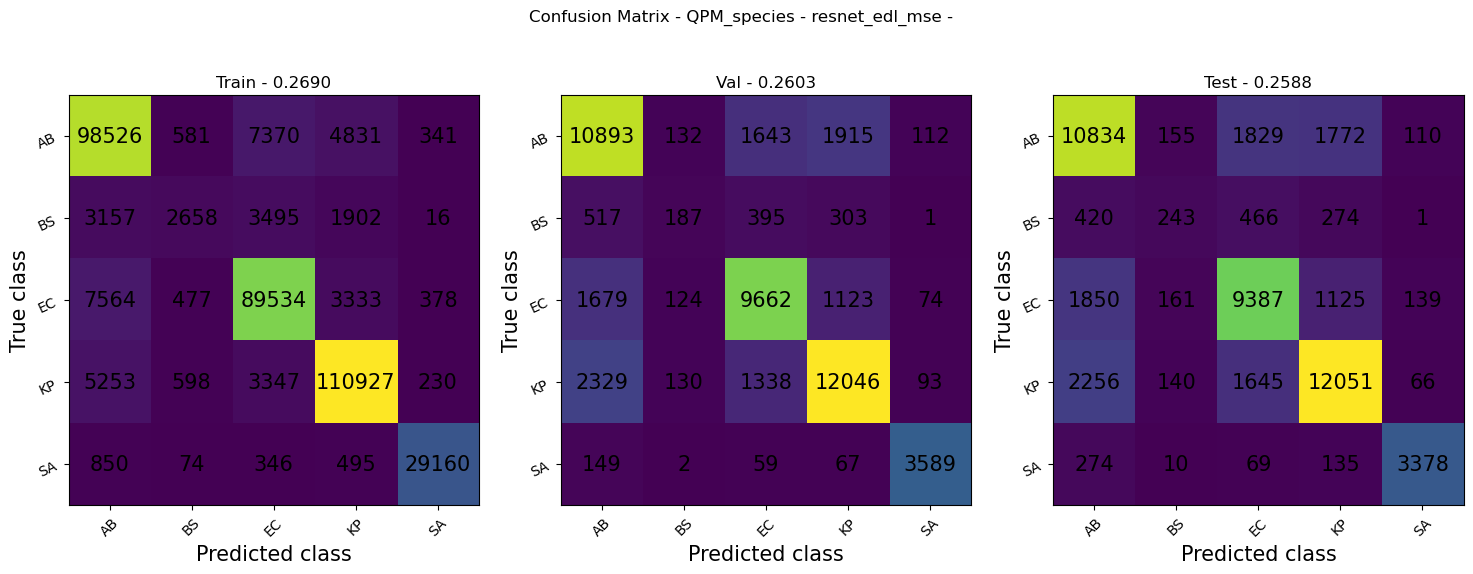

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


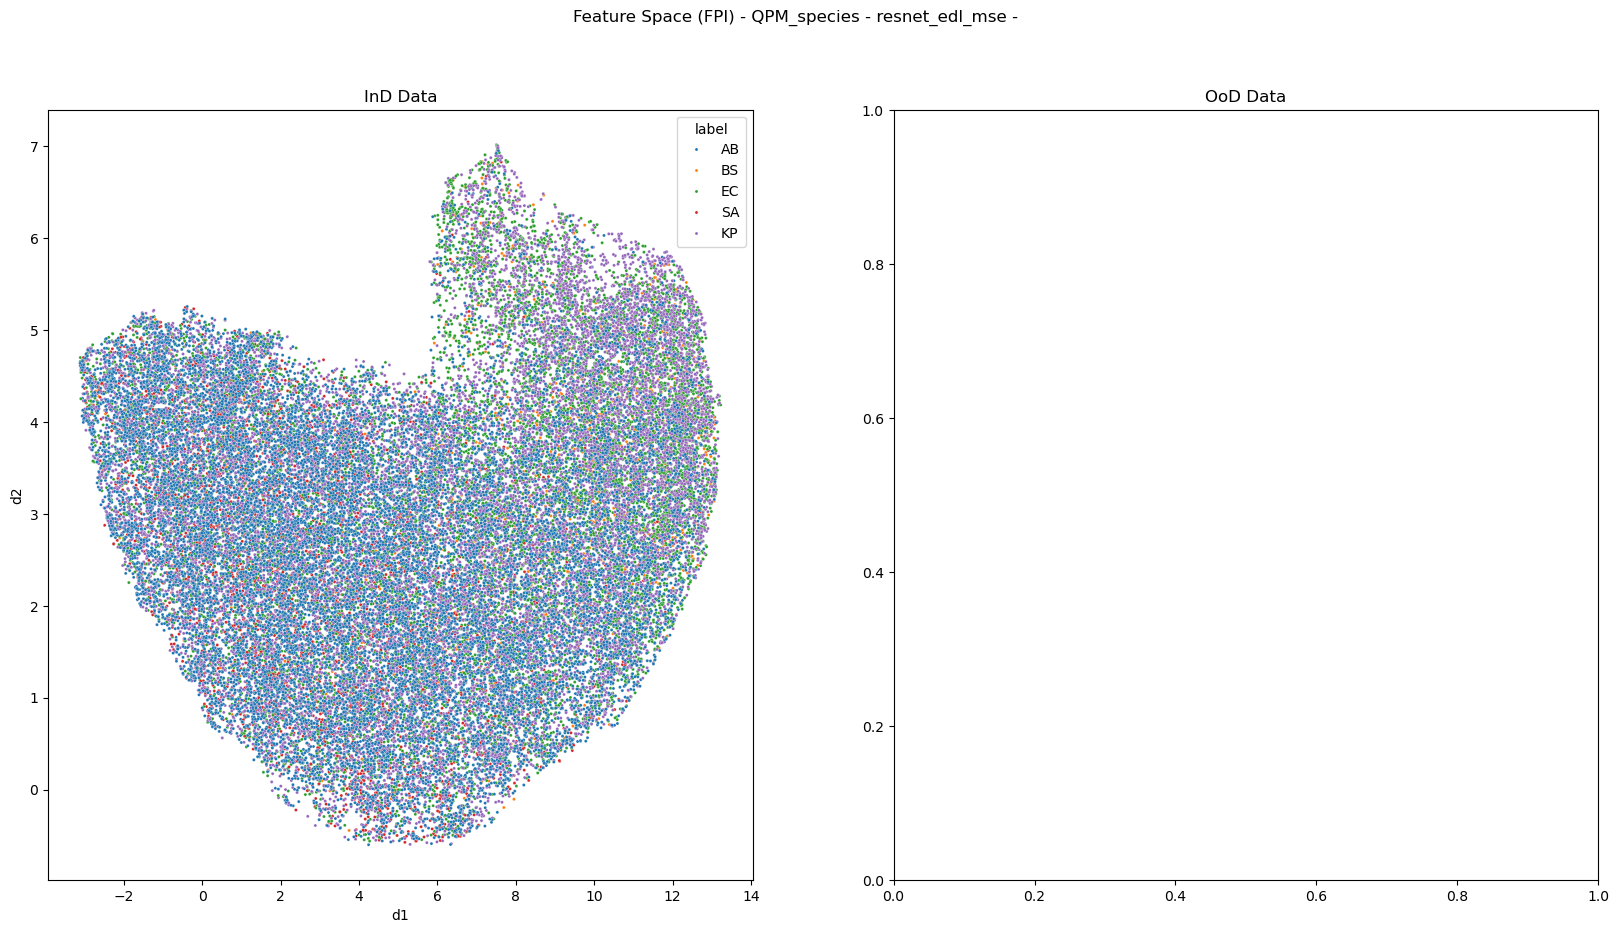

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

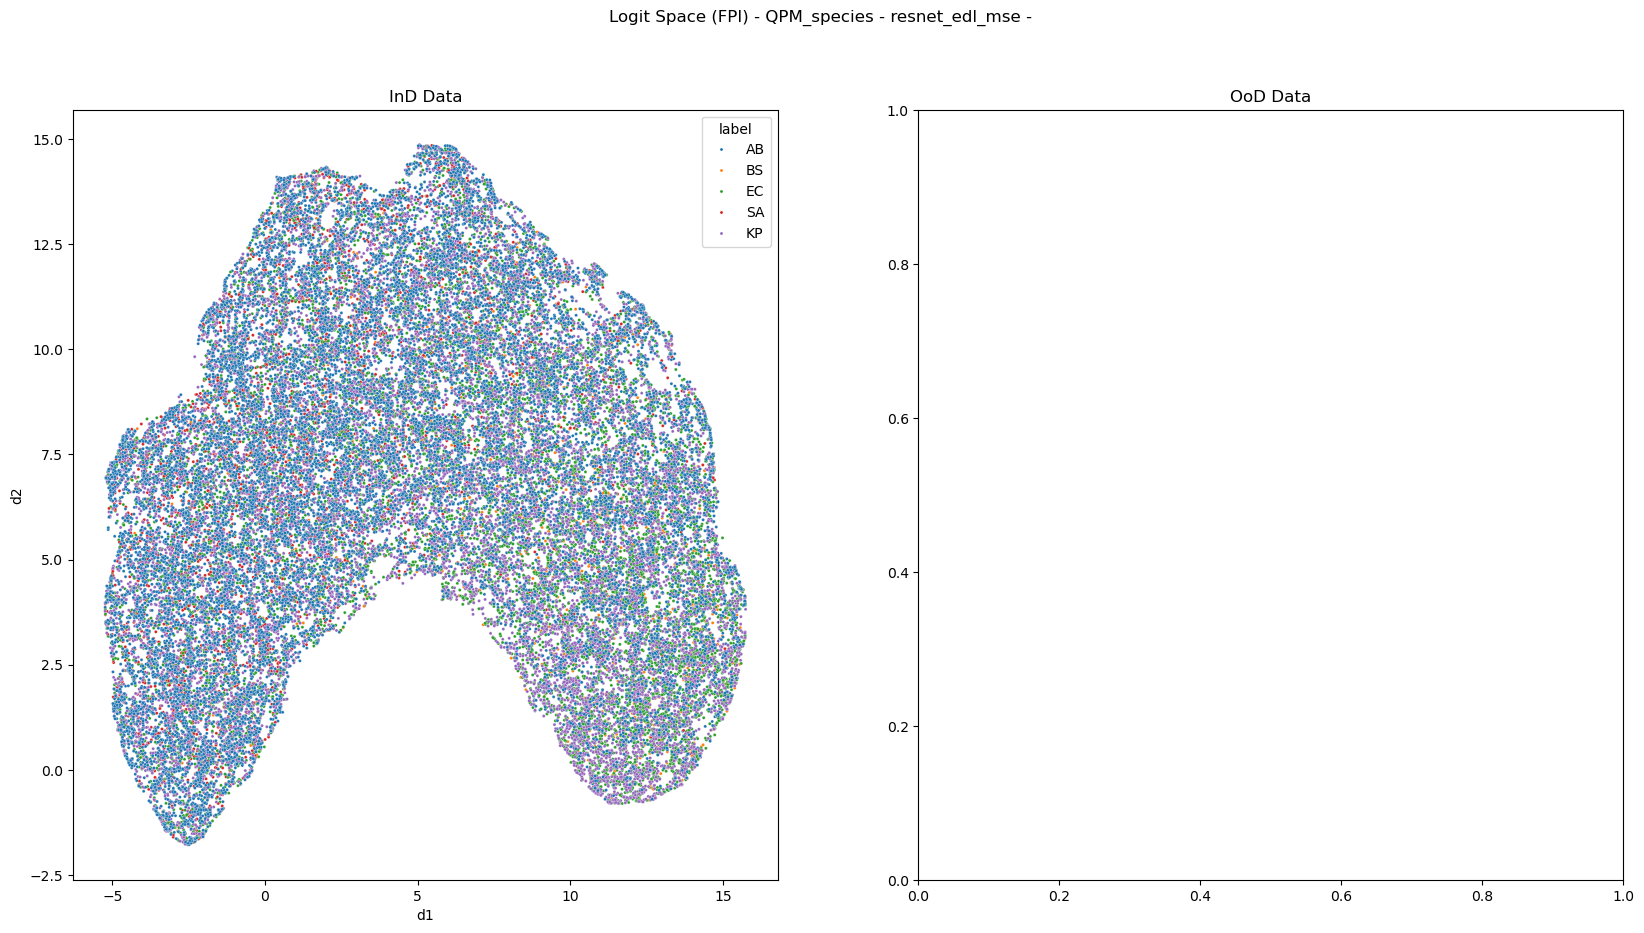

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

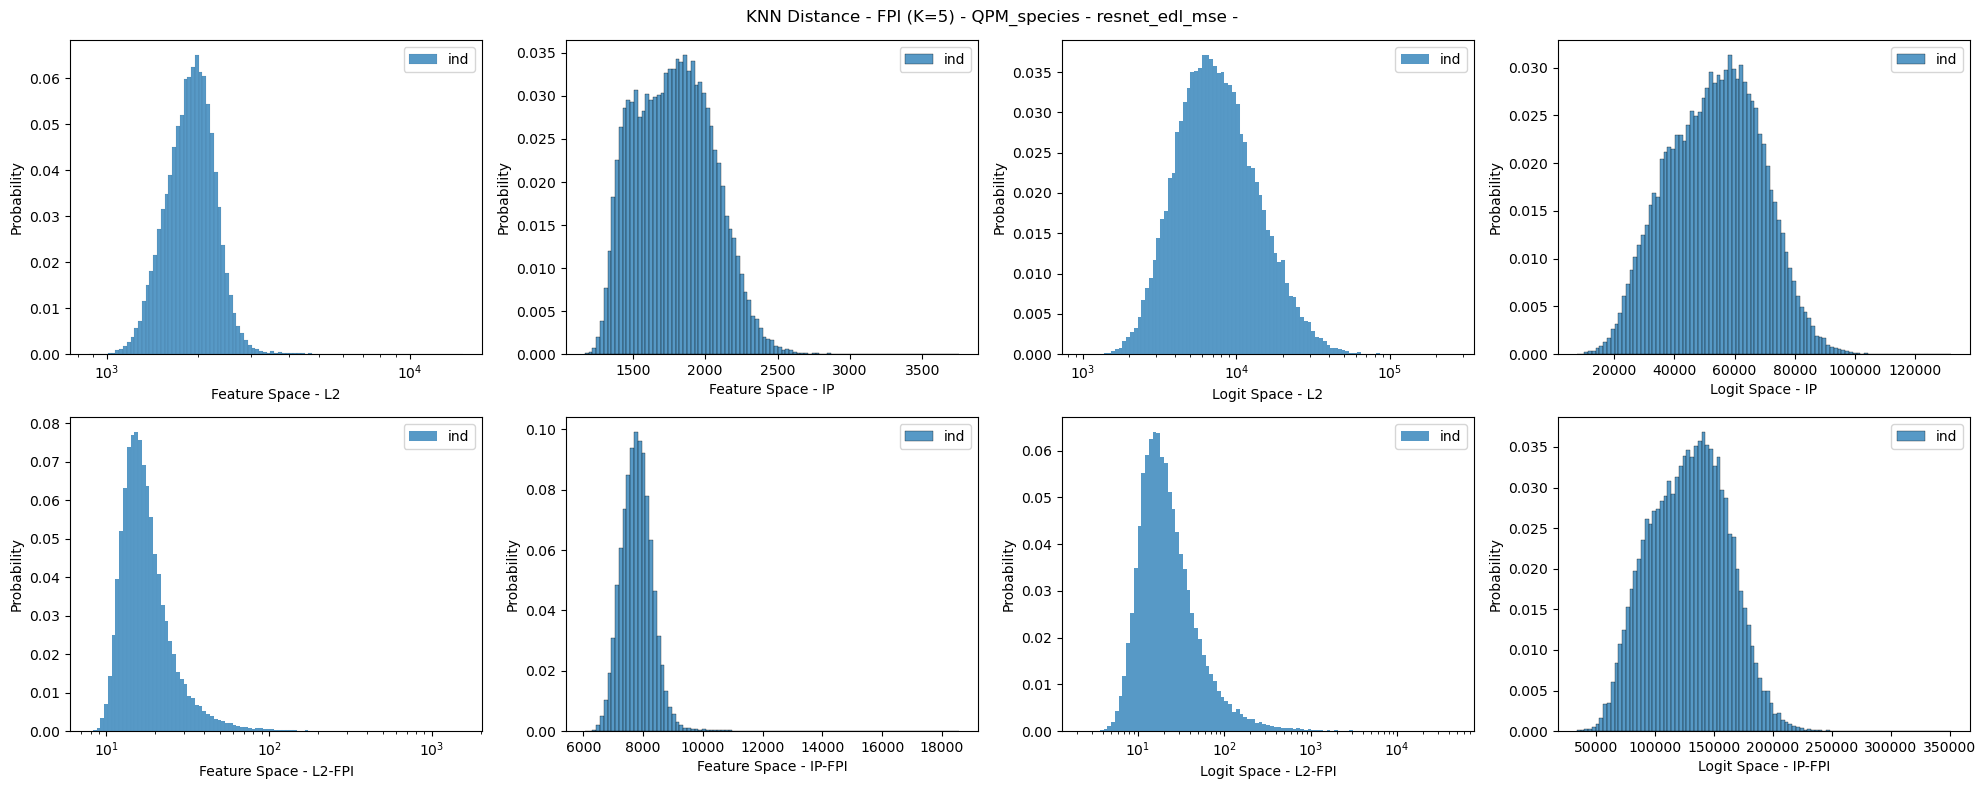

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

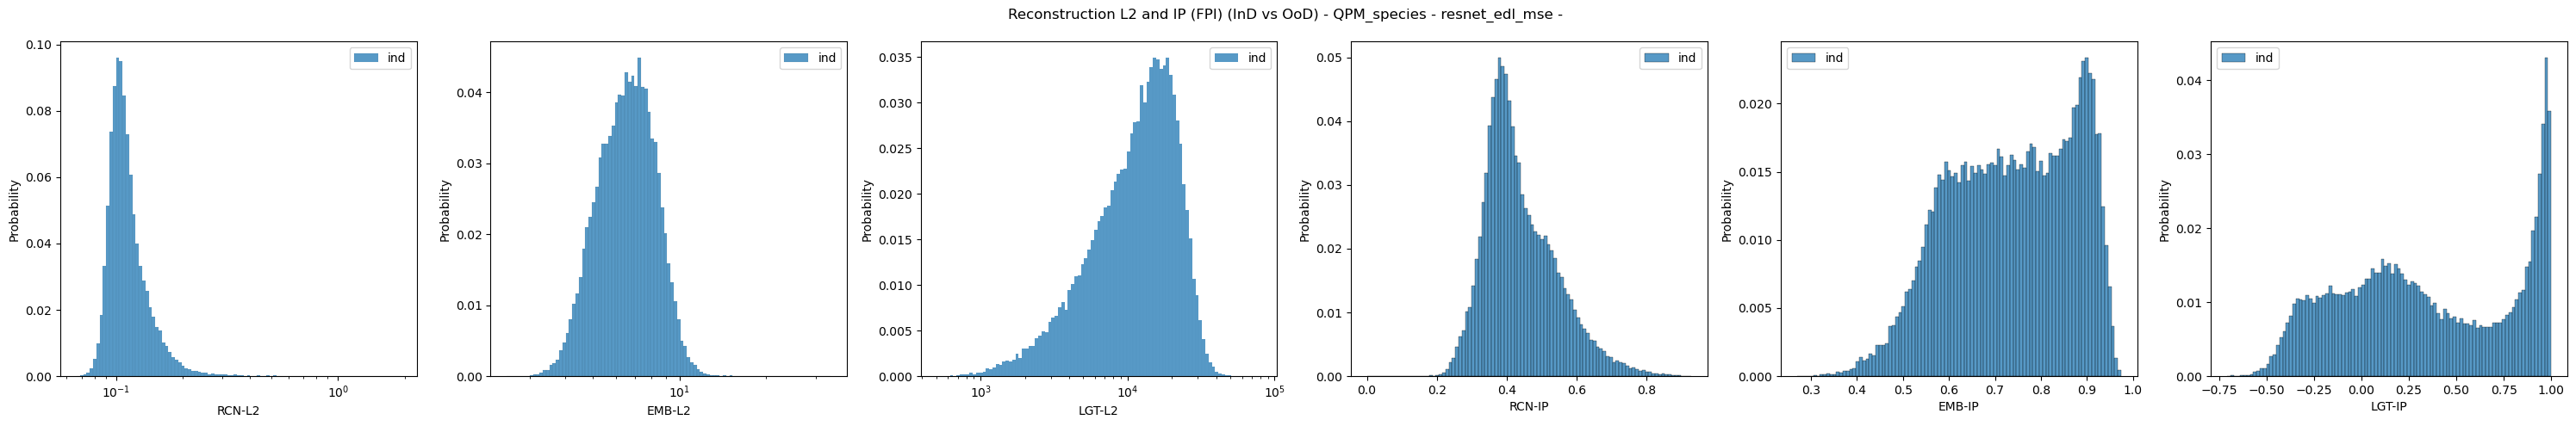

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

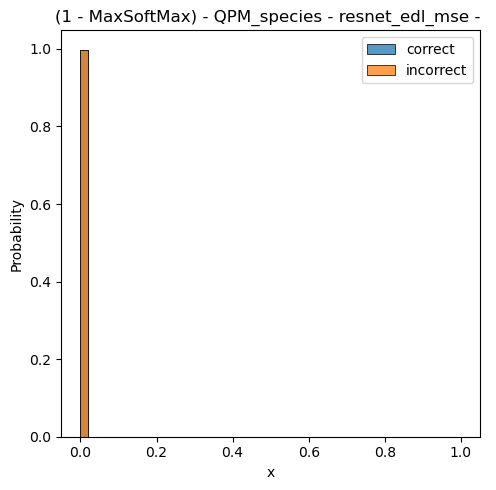

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

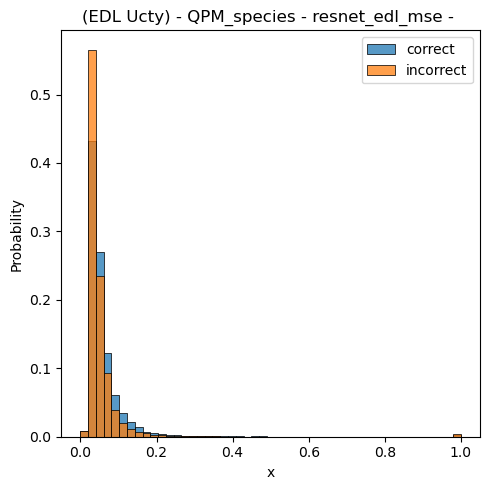

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()